# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



## Data Understanding

### Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from IPython.display import clear_output
import category_encoders
try:
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
except:
    !pip install autoimpute
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
clear_output();
%matplotlib inline


In [200]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [201]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [202]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

#### Duplicates

In [203]:
# duplicates
df.duplicated().sum()

229

In [204]:
# drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
train = df[train.columns]
target = df[target.columns]
df.duplicated().sum()

0

In [205]:
# feature duplicates having different targets
train.duplicated(keep=False).sum()

411

In [206]:
# drop all because I won't collect external feature
dup = train.duplicated(keep=False)
df = df.drop(dup[dup].index).reset_index(drop=True)
train = df[train.columns]
target = df[target.columns]
train.duplicated(keep=False).sum()

0

#### Random seed

In [207]:
random_seed=42
np.random.seed(random_seed)

### Data Describe and EDA

#### Pandas Profiling

In [208]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

#### Univariate analysis

Including Data re-expression, type casting, Outliers

In [209]:
def EDA_plot1(df,column):
    uniqs = len(df[column].dropna().unique())
    #히스토그램, 박스플롯
    if pd.api.types.is_numeric_dtype(df[column]) and uniqs>30:
        ax1=sns.boxplot(x=df[column],data=df)
        plt.show()
    if uniqs<=10:
        #바플롯세로
        ax1=sns.countplot(x=column,data=df)
        for p in ax1.patches:
            percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax1.annotate(percentage, (x, y), ha='center', va='center')
        plt.tight_layout()
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(8,4+uniqs/3),nrows=2,ncols=1)
        ax1=sns.countplot(y=column,data=df)
        plt.tight_layout()
        plt.show()

In [210]:
def EDA_plot2(df,column_name,rot=0):
    fig1, axs1 = plt.subplots(figsize=(16,6),nrows=1,ncols=2)
    order=sorted(df[f'{column_name}'].dropna().unique())
    ax1=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==0],ax=axs1[0], order=order)
    ax2=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==1],ax=axs1[1], order=order)
    ax1.tick_params(rotation=rot)
    ax2.tick_params(rotation=rot)
    ax1.set_title(f'count of {column_name} when target=0')
    ax2.set_title(f'count of {column_name} when target=1')
    
    
    col_sum0=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    col_sum1=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    a=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum0*100)
    b=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum1*100)
    c=(a-b).apply(lambda x: abs(x)).reset_index()
    fig2, axs2 = plt.subplots(figsize=(16,10),nrows=1,ncols=1)
    ax3=sns.barplot(x=f'{column_name}',y='vacc_h1n1_f',data=c,ax=axs2)
    ax3.tick_params(rotation=rot)
    ax3.set_title(f'ratio difference of counts of each categories of "{column_name}" columns by target')
    return

In [211]:
type_feature={}

##### (target) vacc_h1n1_f

- Description : Whether respondent received H1N1 flu vaccine.

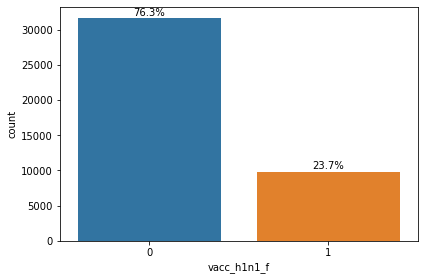

In [212]:
EDA_plot1(df,'vacc_h1n1_f')

- Note : Nominal, Imbalanced Data

In [213]:
type_feature['vacc_h1n1_f'] = 'bool'

##### vacc_seas_f

- Description : Whether respondent received seasonal flu vaccine.

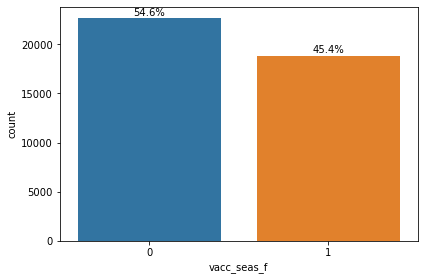

In [214]:
EDA_plot1(df,'vacc_seas_f')

- Note : boolean, Imbalanced Data, dependent variable

In [215]:
type_feature['vacc_seas_f'] = 'bool'

##### h1n1_concern 

- Description : Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.   

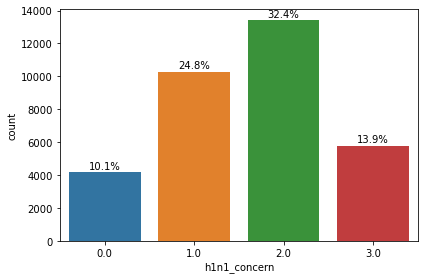

In [ ]:
EDA_plot1(df,'h1n1_concern')

- Note : ordinal categorical type

In [ ]:
type_feature['h1n1_concern'] = 'ordinal'

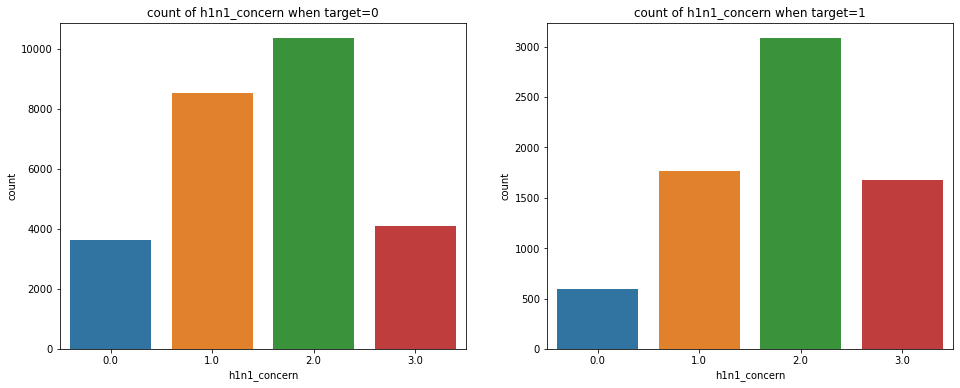

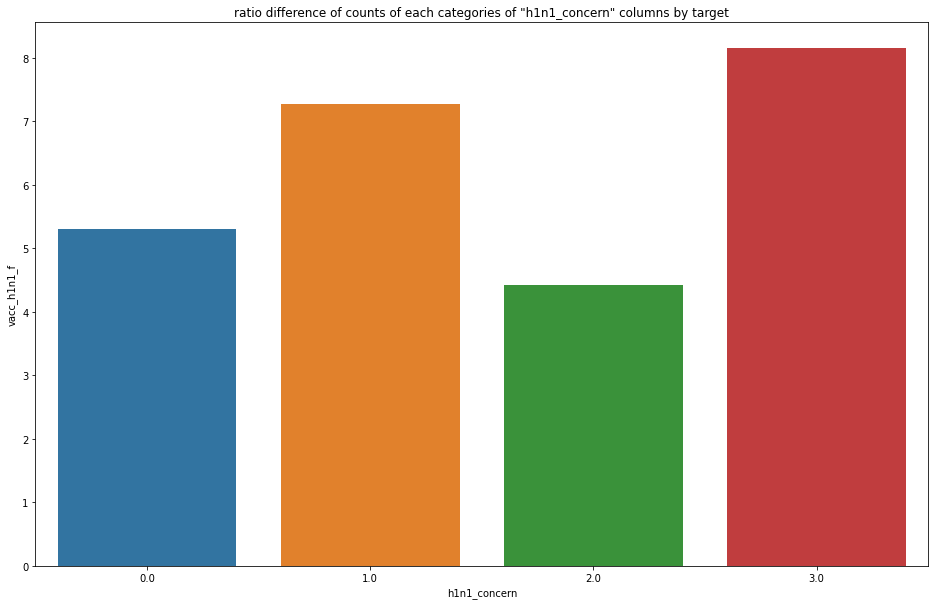

In [ ]:
EDA_plot2(df,'h1n1_concern')

##### h1n1_knowledge

- Description : Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   

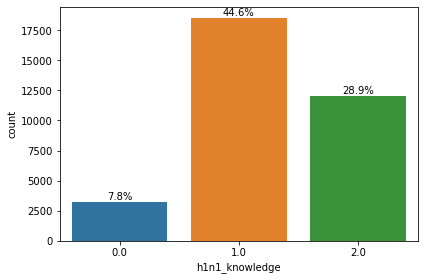

In [ ]:
EDA_plot1(df,'h1n1_knowledge')

- Note : ordinal categorical type

In [ ]:
type_feature['h1n1_knowledge'] = 'ordinal'

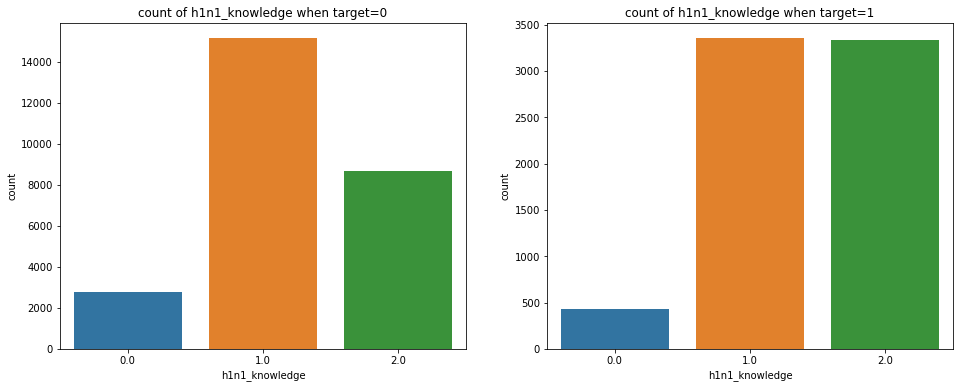

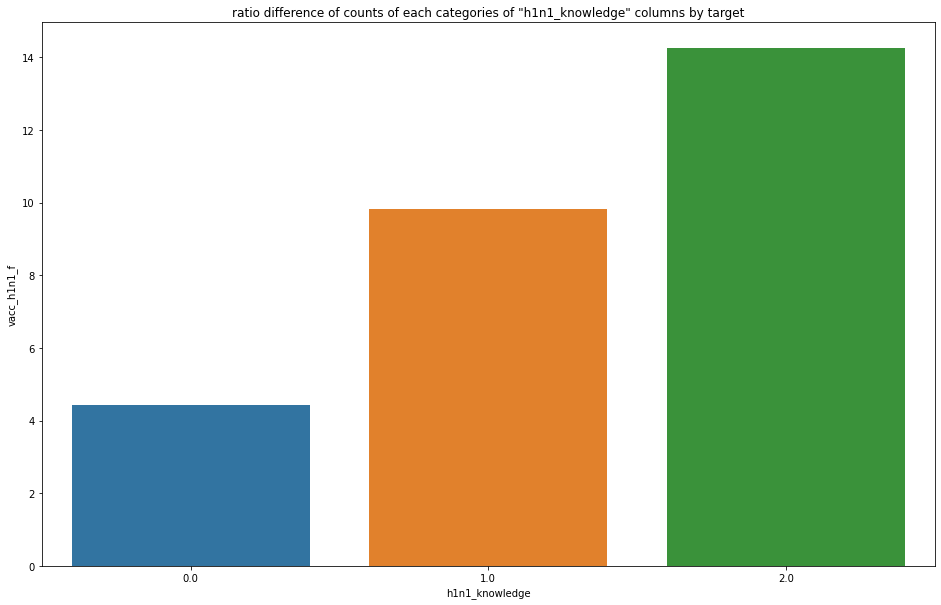

In [ ]:
EDA_plot2(df,'h1n1_knowledge')

##### behavioral_antiviral_meds

- Description : Has taken antiviral medications.

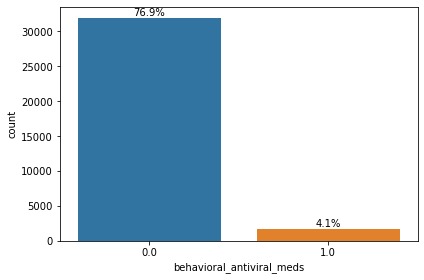

In [ ]:
EDA_plot1(df,'behavioral_antiviral_meds')

- Note : boolean, Imbalanced

In [ ]:
type_feature['behavioral_antiviral_meds'] = 'bool'

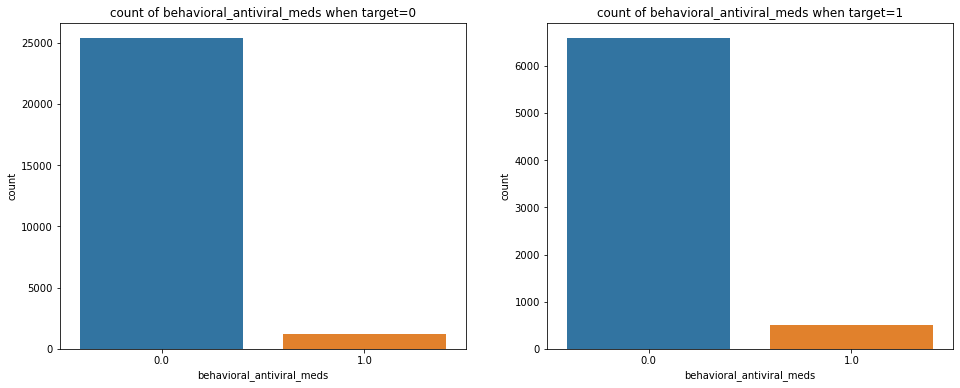

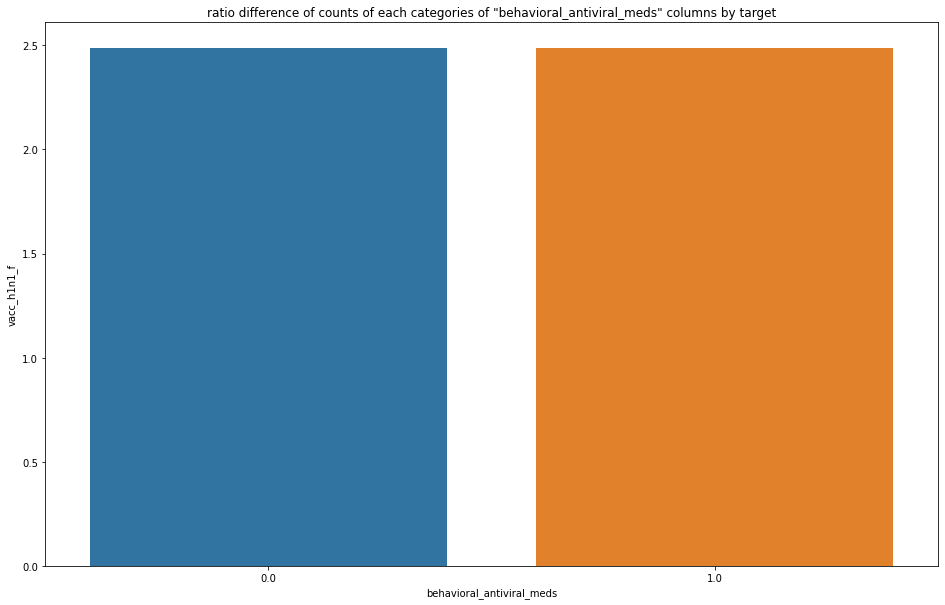

In [ ]:
EDA_plot2(df,'behavioral_antiviral_meds')

##### behavioral_avoidance

- Description : Has avoided close contact with others with flu-like symptoms.

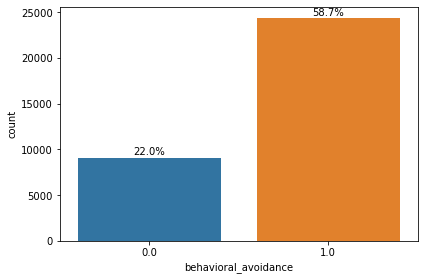

In [ ]:
EDA_plot1(df,'behavioral_avoidance')

- Note : boolean

In [ ]:
type_feature['behavioral_avoidance'] = 'bool'

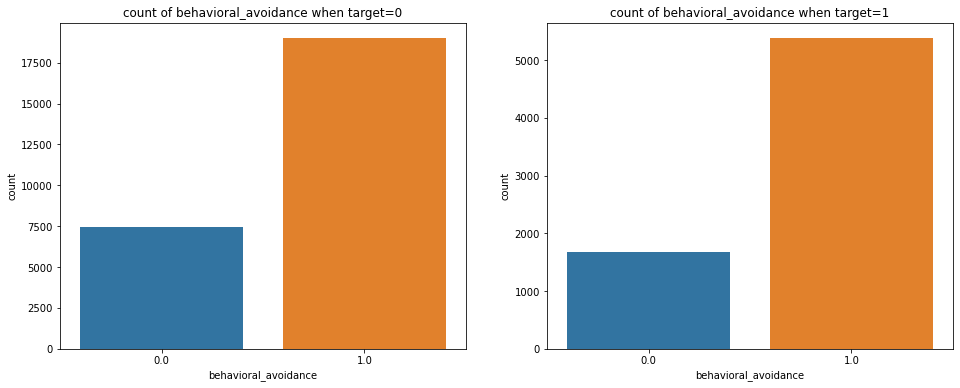

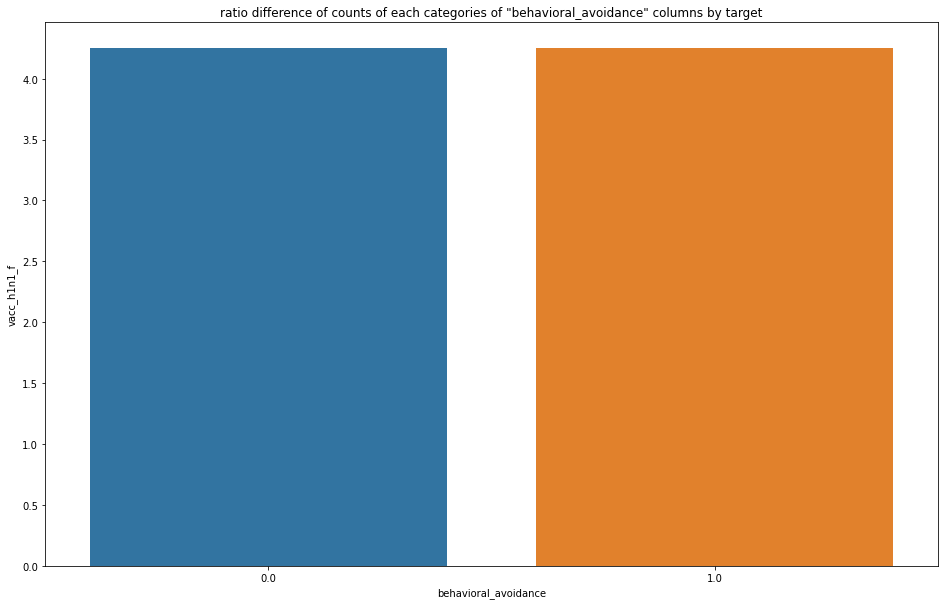

In [ ]:
EDA_plot2(df,'behavioral_avoidance')

##### behavioral_face_mask

- Description : Has bought a face mask.

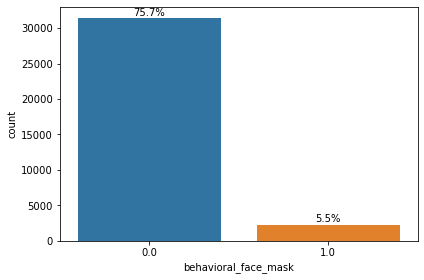

In [ ]:
EDA_plot1(df,'behavioral_face_mask')

- Note : boolean, Imbalanced

In [ ]:
type_feature['behavioral_face_mask'] = 'bool'

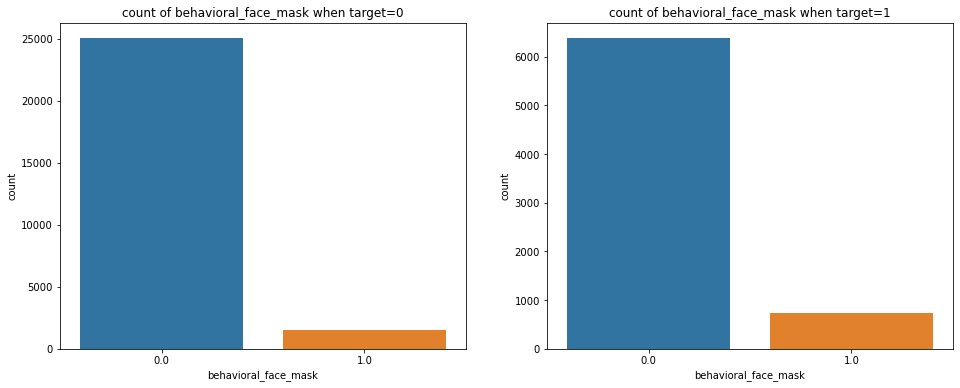

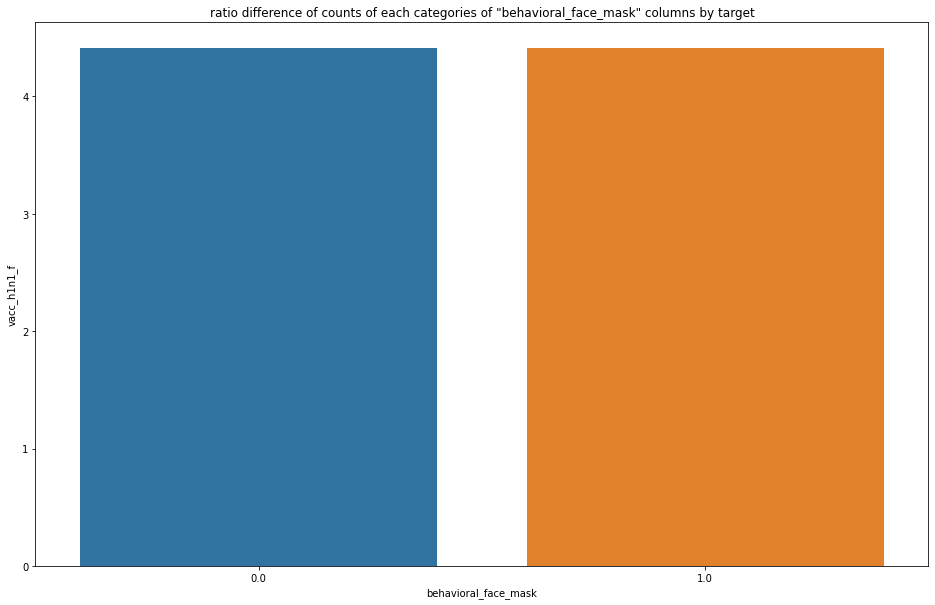

In [ ]:
EDA_plot2(df,'behavioral_face_mask')

##### behavioral_wash_hands

- Description : Has frequently washed hands or used hand sanitizer.

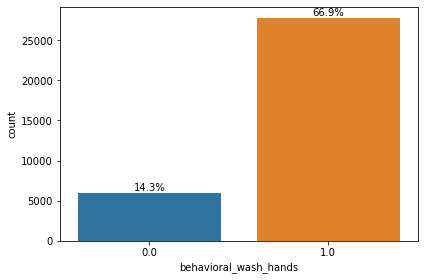

In [ ]:
EDA_plot1(df,'behavioral_wash_hands')

- Note : boolean

In [ ]:
type_feature['behavioral_wash_hands'] = 'bool'

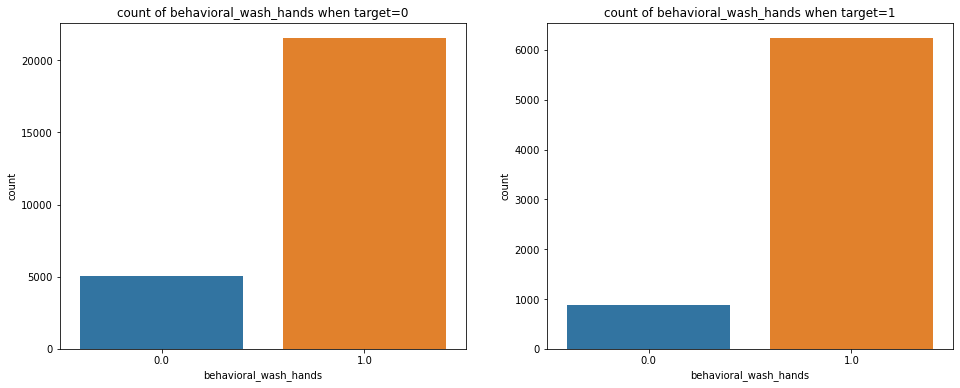

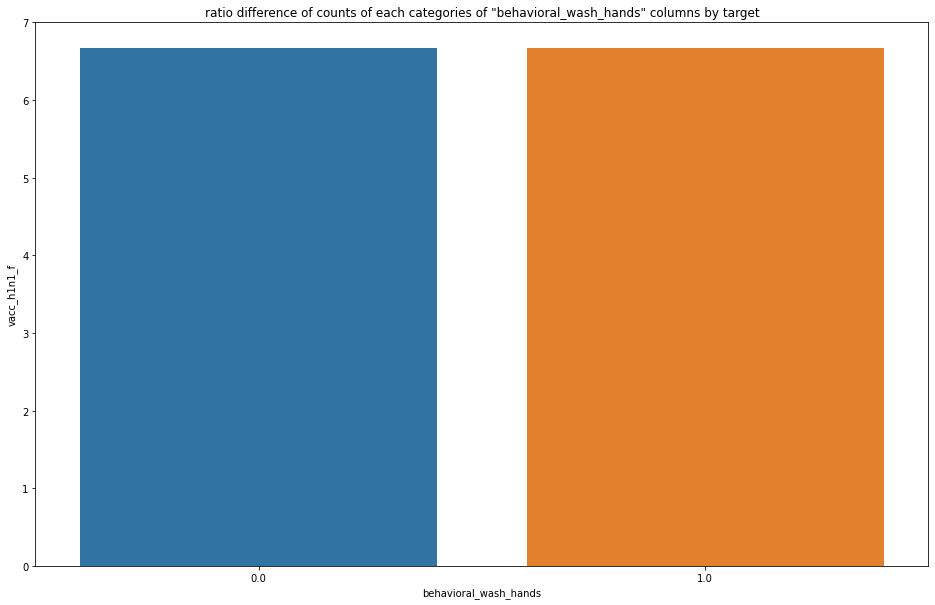

In [ ]:
EDA_plot2(df,'behavioral_wash_hands')

##### behavioral_large_gatherings

- Description : Has reduced time at large gatherings.

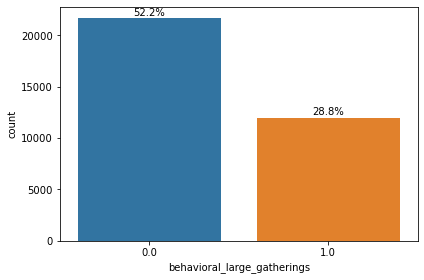

In [ ]:
EDA_plot1(df,'behavioral_large_gatherings')

- Note : boolean

In [ ]:
type_feature['behavioral_large_gatherings'] = 'bool'

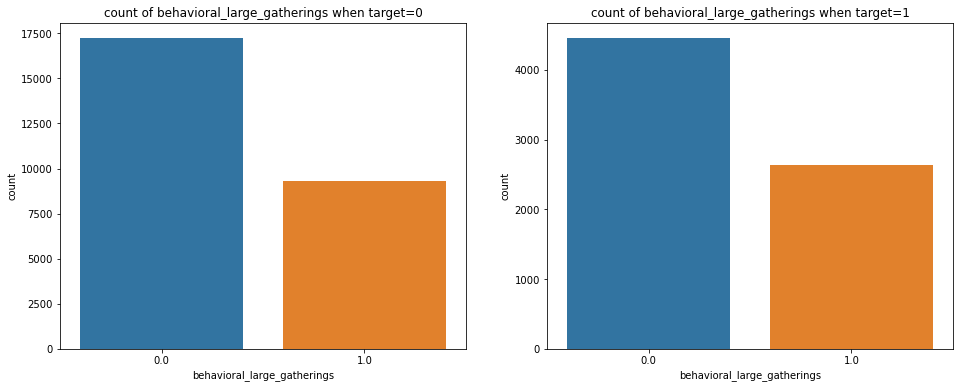

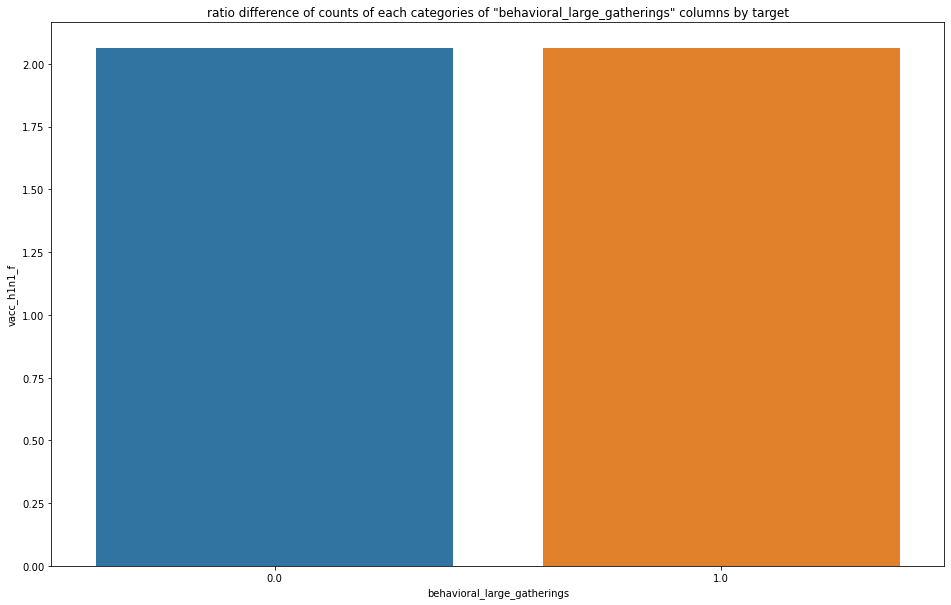

In [ ]:
EDA_plot2(df,'behavioral_large_gatherings')

##### behavioral_outside_home

- Description : Has reduced contact with people outside of own household.

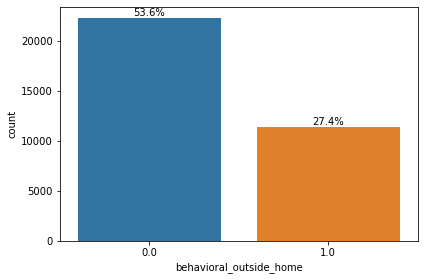

In [ ]:
EDA_plot1(df,'behavioral_outside_home')

In [ ]:
type_feature['behavioral_outside_home'] = 'bool'

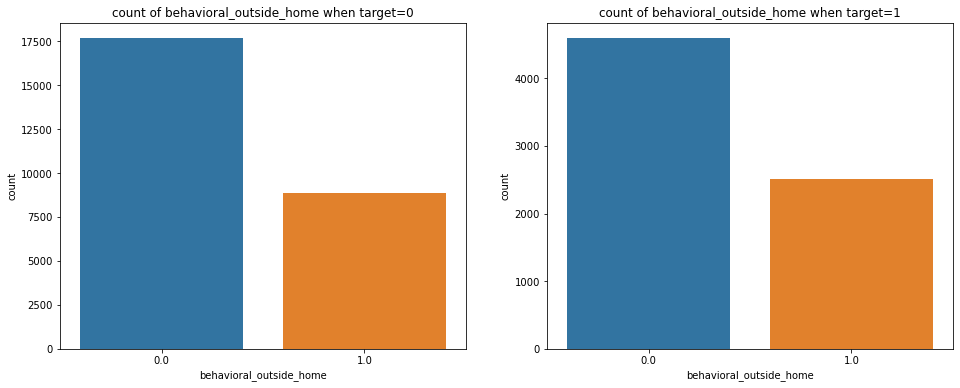

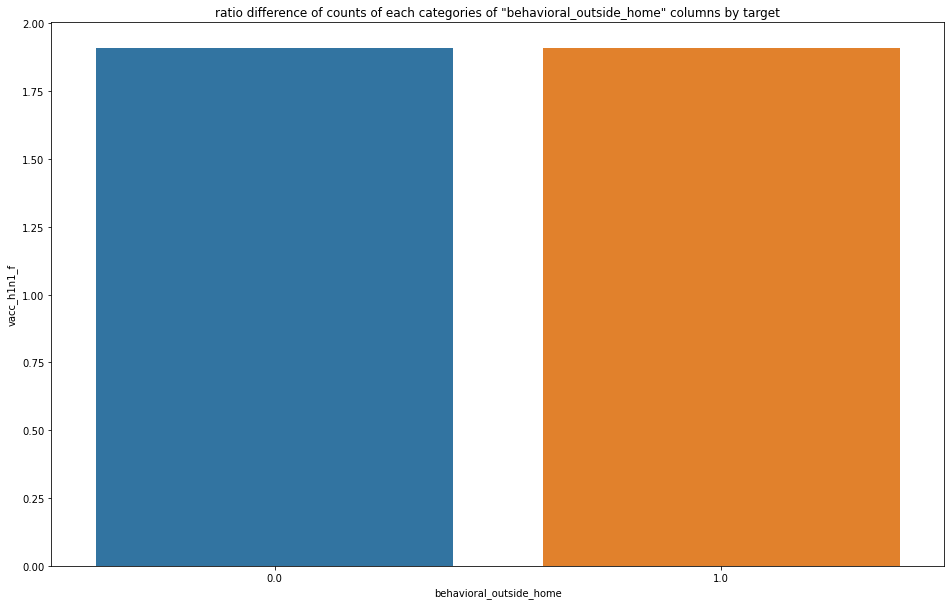

In [ ]:
EDA_plot2(df,'behavioral_outside_home')

##### behavioral_touch_face

- Description : Has avoided touching eyes, nose, or mouth.

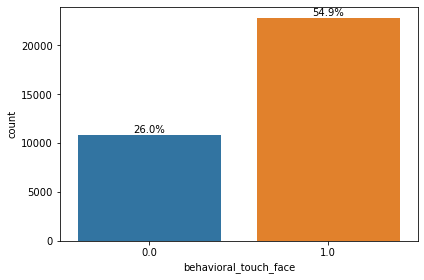

In [ ]:
EDA_plot1(df,'behavioral_touch_face')

- Note : boolean

In [ ]:
type_feature['behavioral_touch_face'] = 'bool'

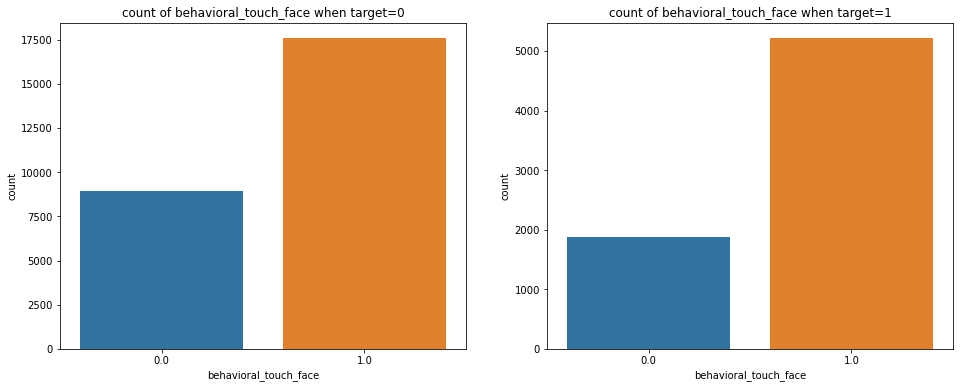

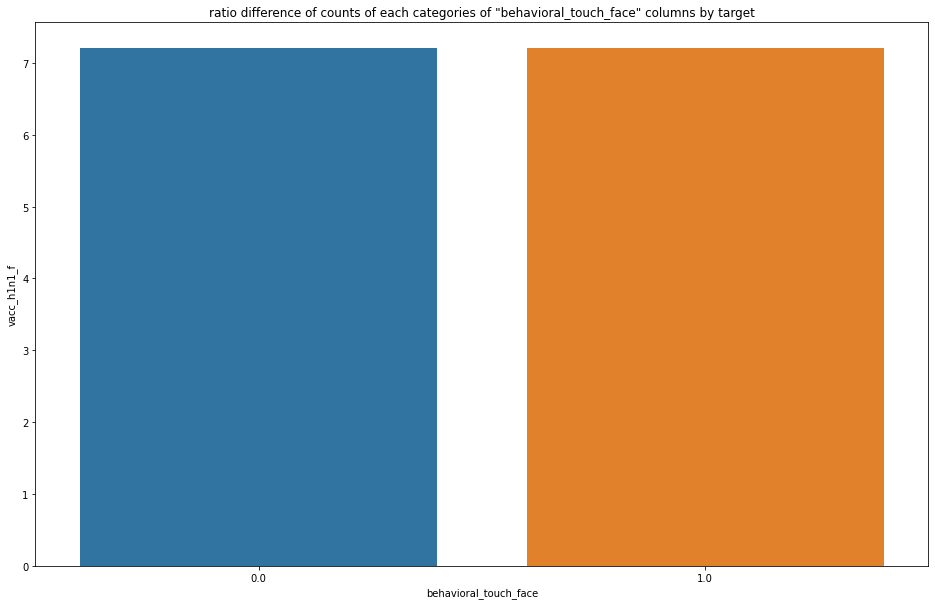

In [ ]:
EDA_plot2(df,'behavioral_touch_face')

##### doctor_recc_h1n1

- Description : H1N1 flu vaccine was recommended by doctor.

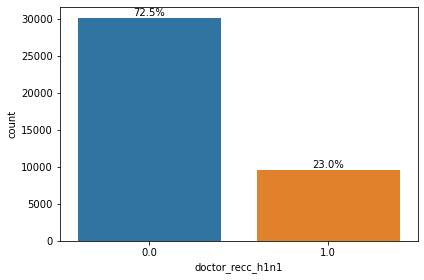

In [ ]:
EDA_plot1(df,'doctor_recc_h1n1')

In [ ]:
type_feature['doctor_recc_h1n1'] = 'bool'

- Note : boolean

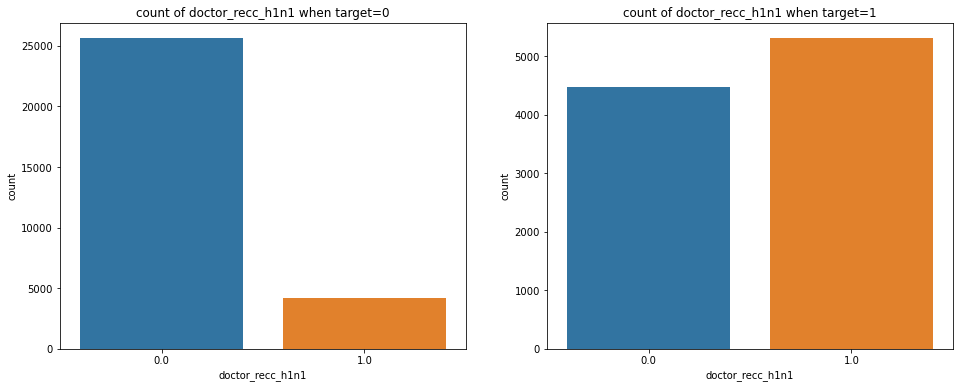

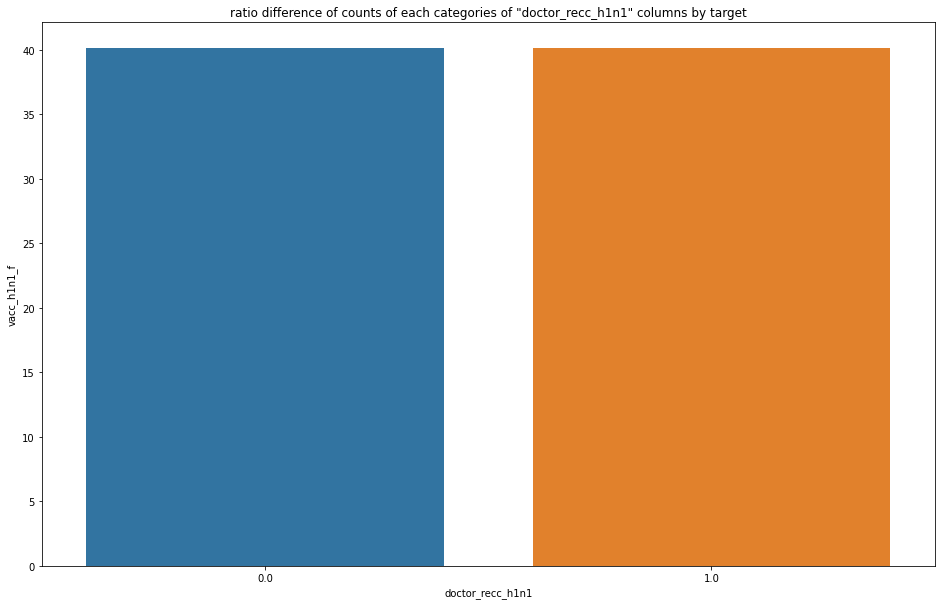

In [ ]:
EDA_plot2(df,'doctor_recc_h1n1')

##### doctor_recc_seasonal

- Description : Seasonal flu vaccine was recommended by doctor.

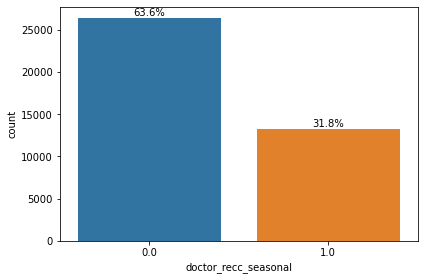

In [ ]:
EDA_plot1(df,'doctor_recc_seasonal')

- Note : boolean, seasonal

In [ ]:
type_feature['doctor_recc_seasonal'] = 'bool'

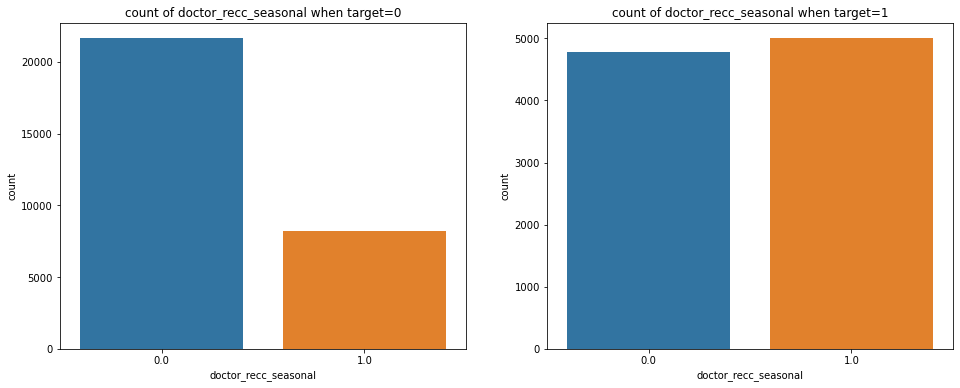

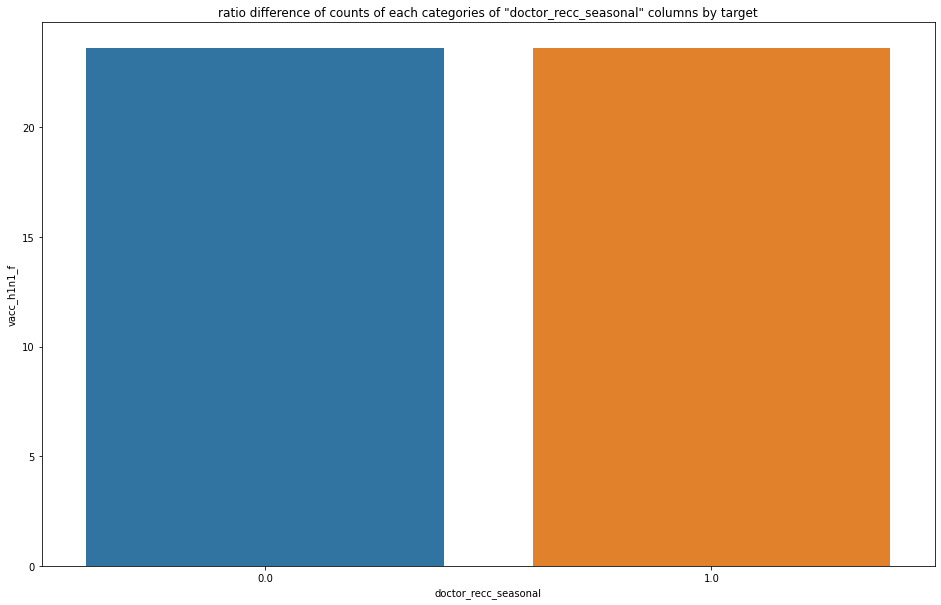

In [ ]:
EDA_plot2(df,'doctor_recc_seasonal')

##### chronic_med_condition

- Description : Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. 

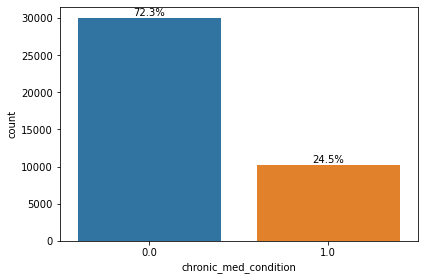

In [ ]:
EDA_plot1(df,'chronic_med_condition')

- Note : boolean

In [ ]:
type_feature['chronic_med_condition'] = 'bool'

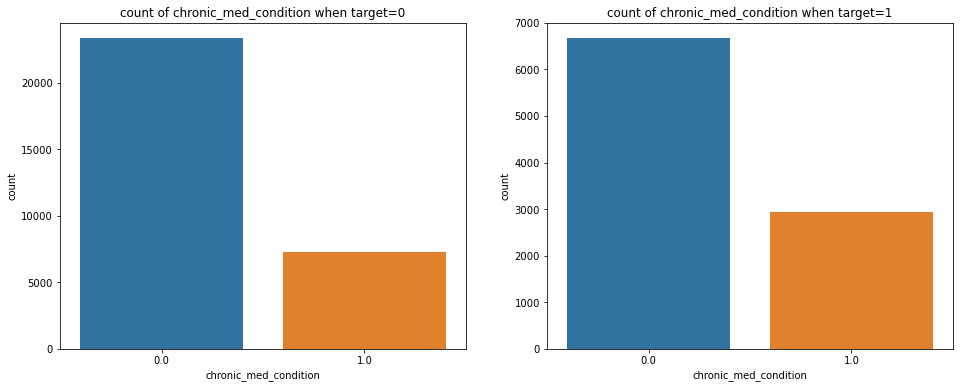

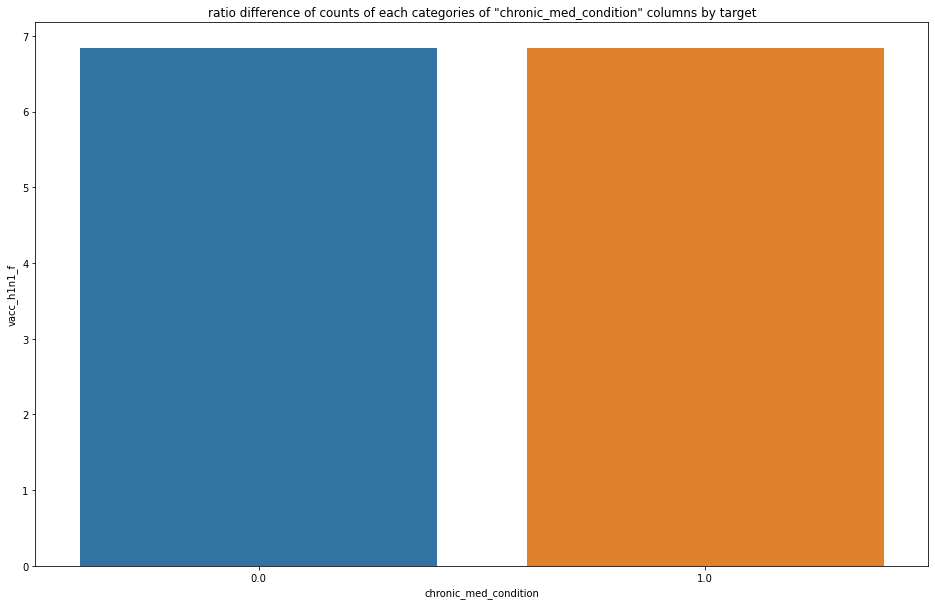

In [ ]:
EDA_plot2(df,'chronic_med_condition')

##### child_under_6_months

- Description : Has regular close contact with a child under the age of six months.

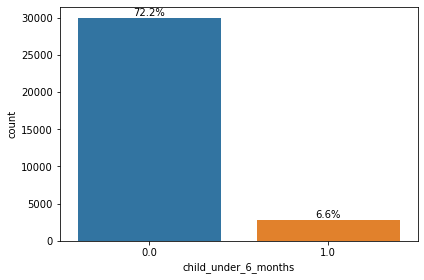

In [ ]:
EDA_plot1(df,'child_under_6_months')

- Note : boolean, Imbalanced

In [ ]:
type_feature['child_under_6_months'] = 'bool'

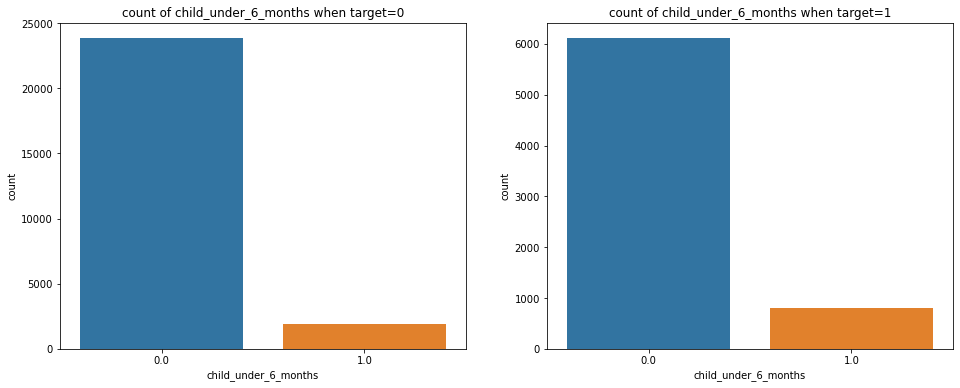

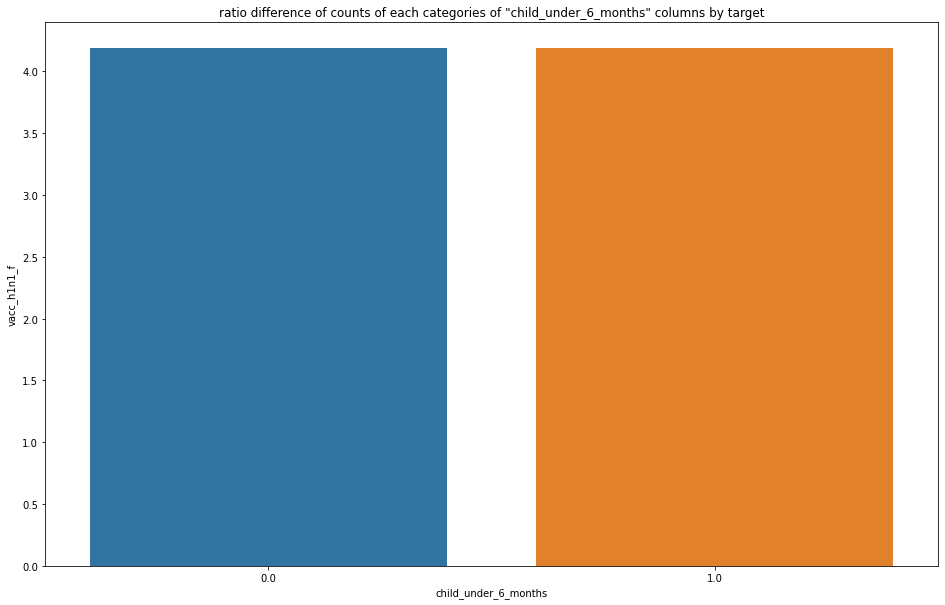

In [ ]:
EDA_plot2(df,'child_under_6_months')

##### health_insurance

- Description : Has health insurance.

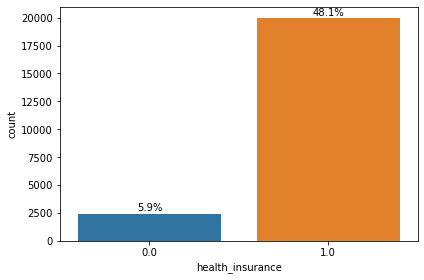

In [ ]:
EDA_plot1(df,'health_insurance')

- Note : boolean

In [ ]:
type_feature['health_insurance'] = 'bool'

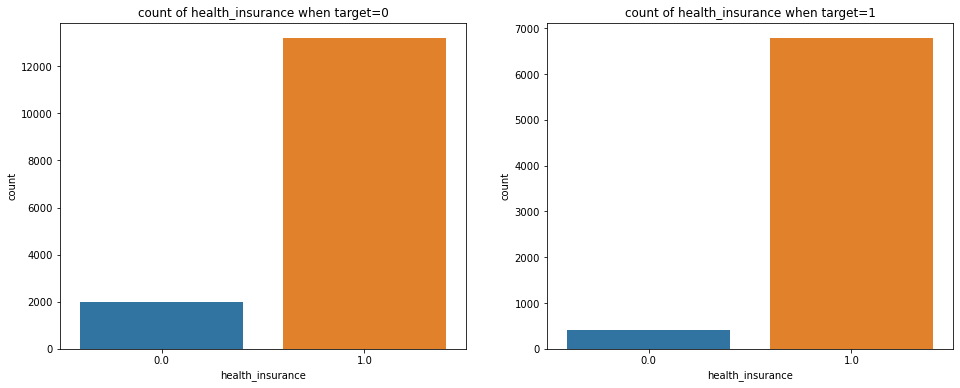

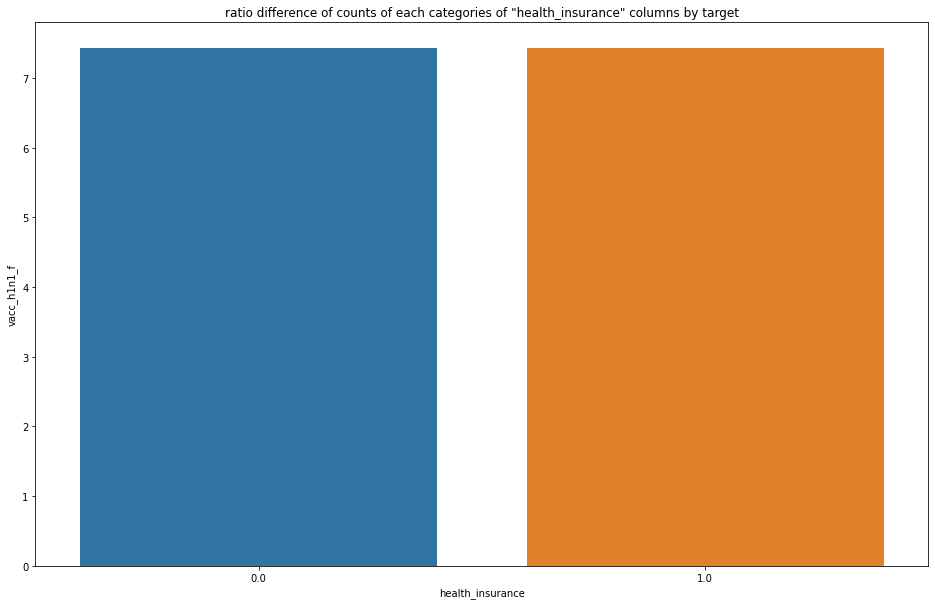

In [ ]:
EDA_plot2(df,'health_insurance')

##### health_worker

- Description : Is a healthcare worker.

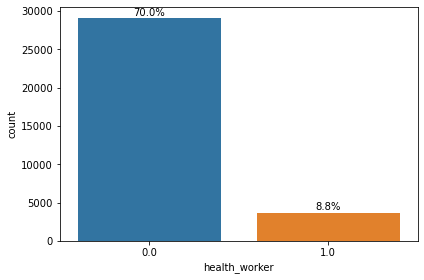

In [ ]:
EDA_plot1(df,'health_worker')

- Note : boolean

In [ ]:
type_feature['health_worker'] = 'bool'

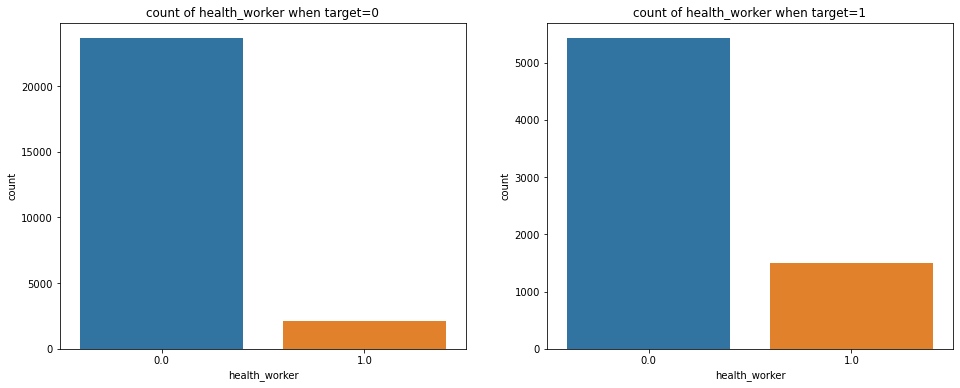

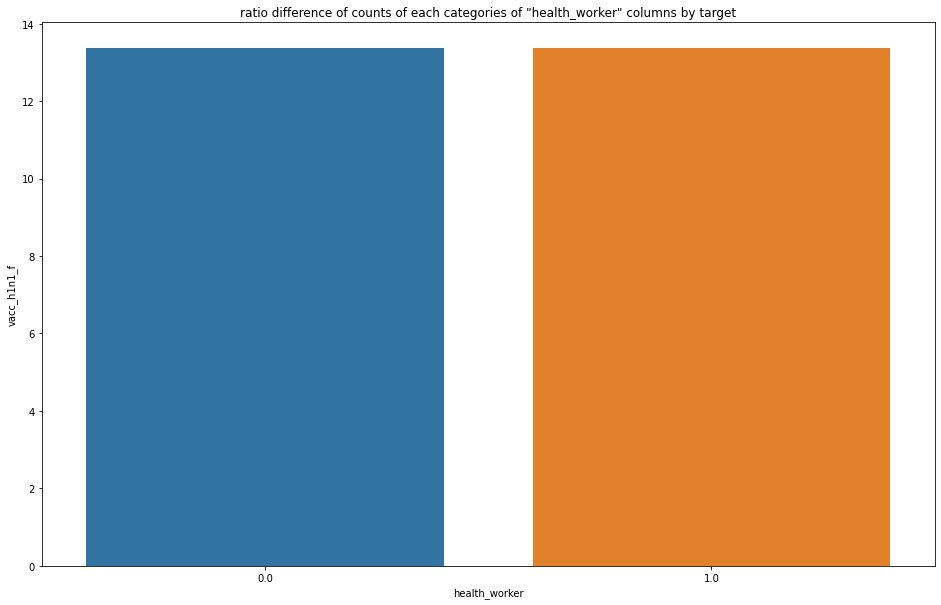

In [ ]:
EDA_plot2(df,'health_worker')

##### opinion_h1n1_vacc_effective

- Description : Respondent's opinion about H1N1 vaccine effectiveness.   

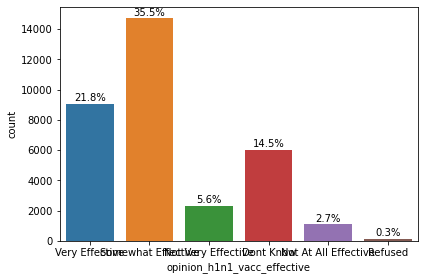

In [ ]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [ ]:
df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Very Effective',3,inplace=True)
type_feature['opinion_h1n1_vacc_effective'] = 'ordinal'

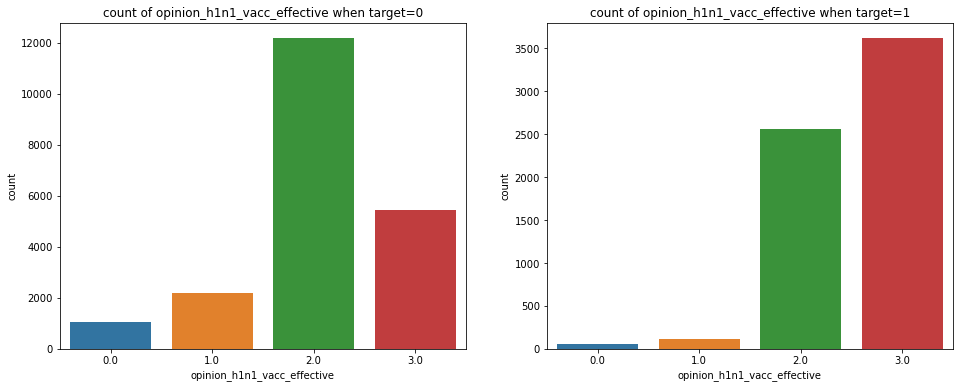

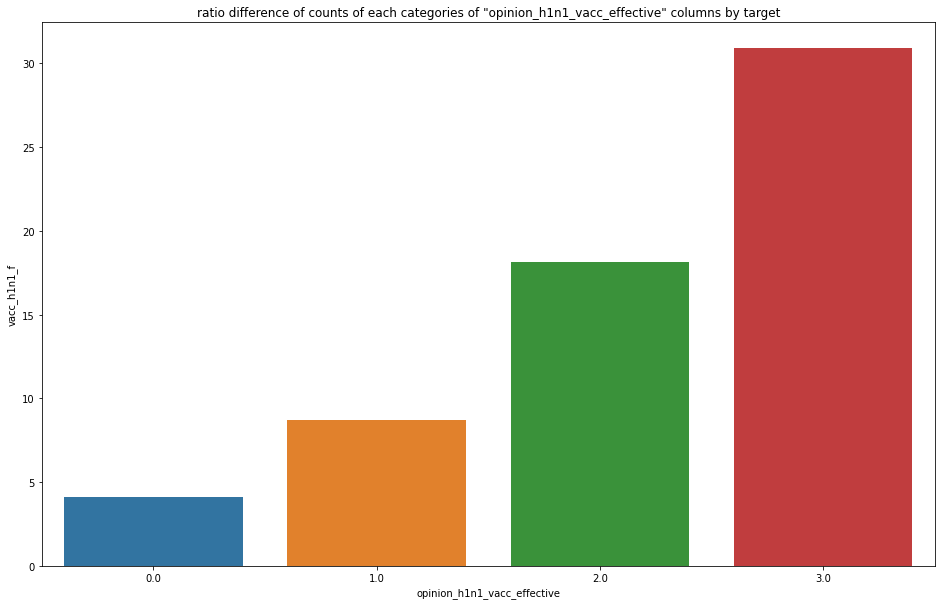

In [ ]:
EDA_plot2(df,'opinion_h1n1_vacc_effective')

##### opinion_h1n1_risk
Remarks : Don't Know, Refused -> nan

- Description : Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.  

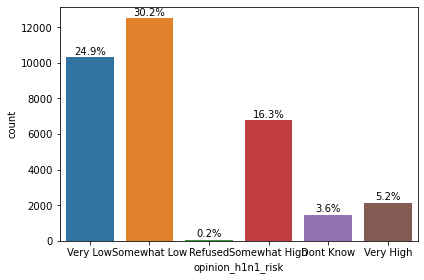

In [ ]:
EDA_plot1(df,'opinion_h1n1_risk')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [ ]:
df['opinion_h1n1_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_h1n1_risk'].replace('Very High',4,inplace=True)
type_feature['opinion_h1n1_risk'] = 'ordinal'

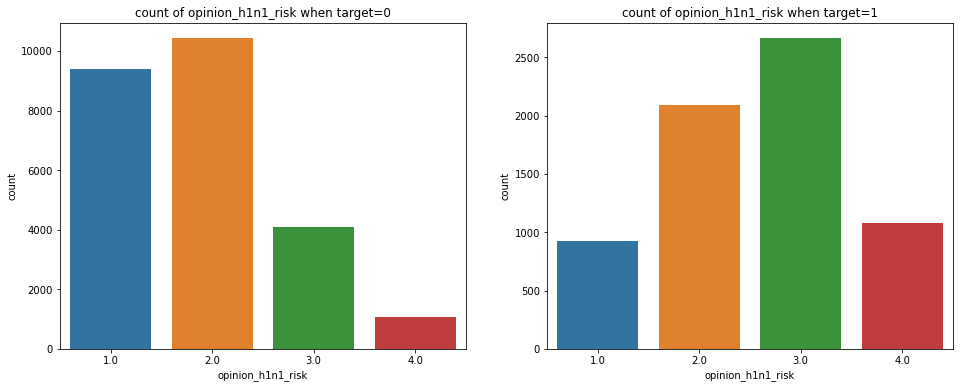

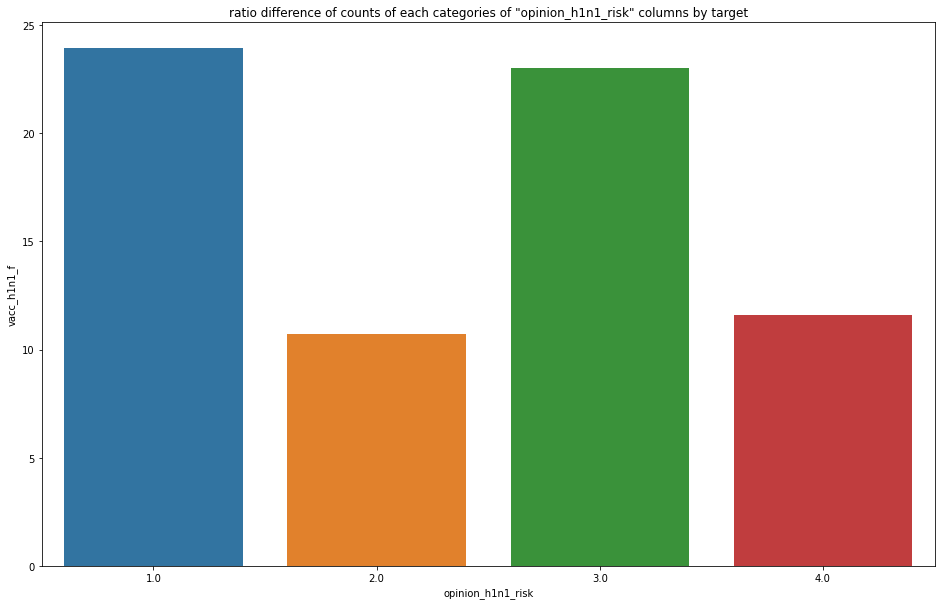

In [ ]:
EDA_plot2(df,'opinion_h1n1_risk')

##### opinion_h1n1_sick_from_vacc

- Description : Respondent's worry of getting sick from taking H1N1 vaccine.   

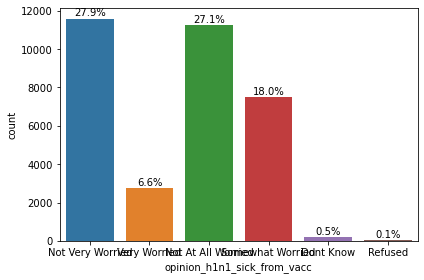

In [ ]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [ ]:
df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',3,inplace=True)
type_feature['opinion_h1n1_sick_from_vacc'] = 'ordinal'

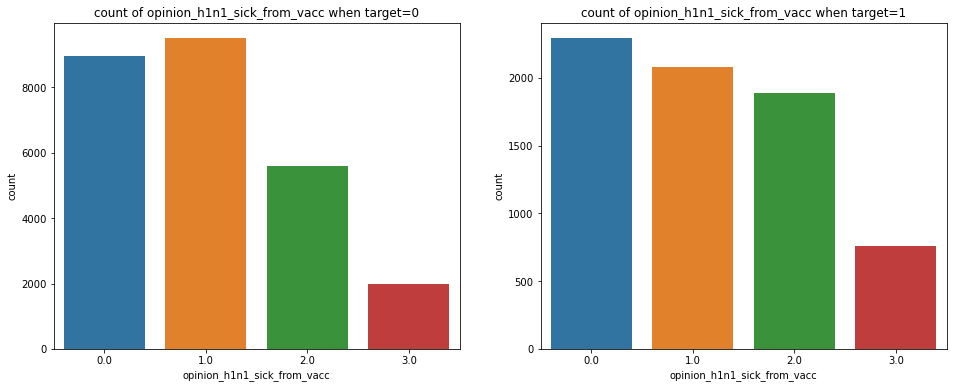

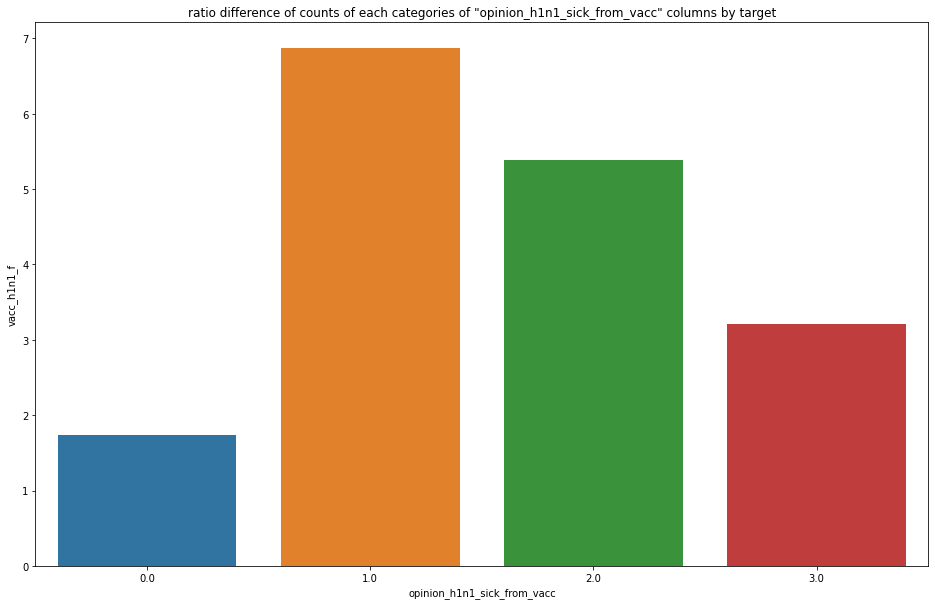

In [ ]:
EDA_plot2(df,'opinion_h1n1_sick_from_vacc')

##### opinion_seas_vacc_effective

- Description : Respondent's opinion about seasonal flu vaccine effectiveness.   

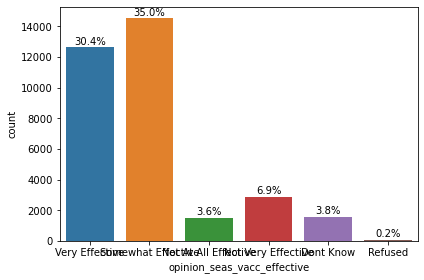

In [ ]:
EDA_plot1(df,'opinion_seas_vacc_effective')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [ ]:
df['opinion_seas_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_seas_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_seas_vacc_effective'].replace('Very Effective',3,inplace=True)
type_feature['opinion_seas_vacc_effective'] = 'ordinal'

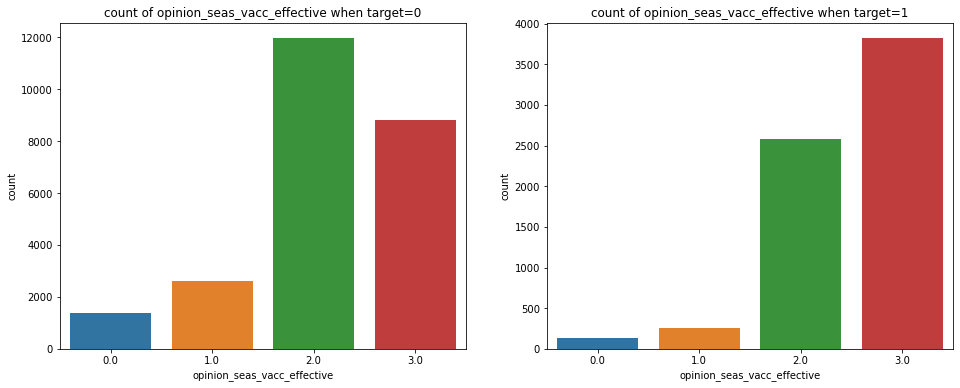

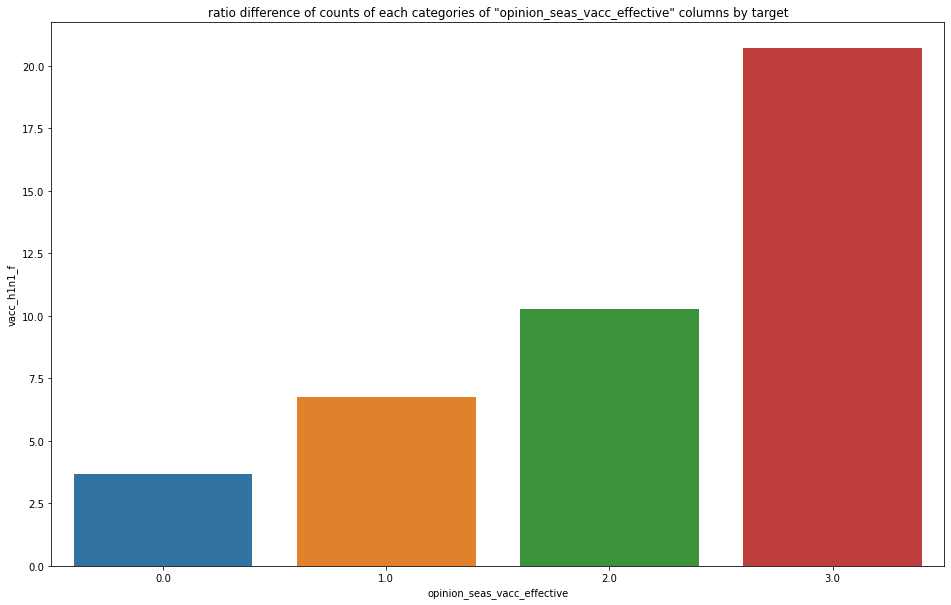

In [ ]:
EDA_plot2(df,'opinion_seas_vacc_effective')

##### opinion_seas_risk

- Description : Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   

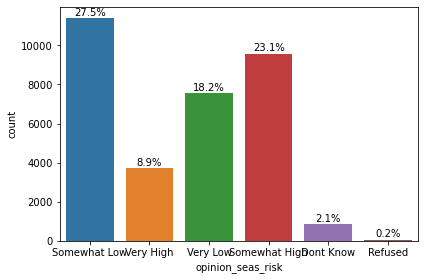

In [ ]:
EDA_plot1(df,'opinion_seas_risk')

- Note : ordered categorical type, Don't Know/Refused -> nan, seasonal

In [ ]:
df['opinion_seas_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_seas_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_seas_risk'].replace('Very High',4,inplace=True)
type_feature['opinion_seas_risk'] = 'ordinal'

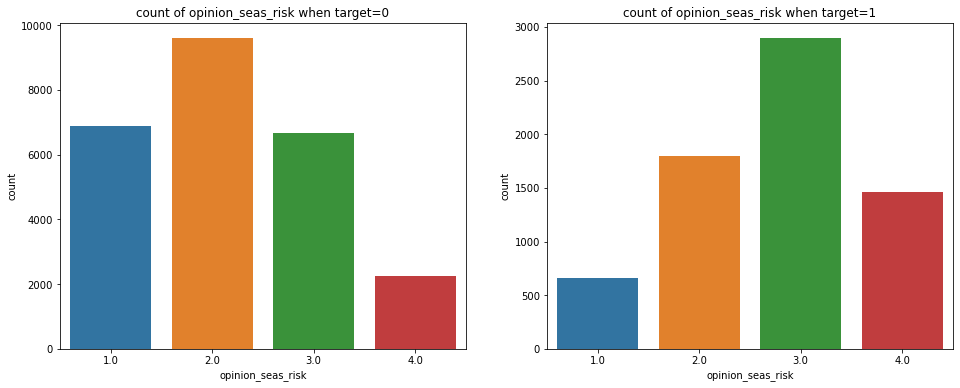

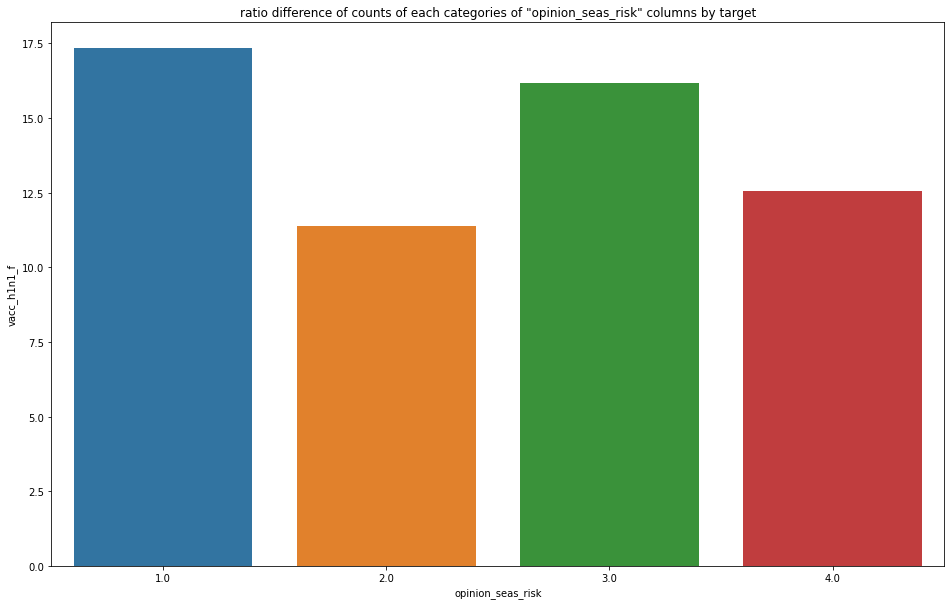

In [ ]:
EDA_plot2(df,'opinion_seas_risk')

##### opinion_seas_sick_from_vacc

- Description : Respondent's worry of getting sick from taking seasonal flu vaccine.  

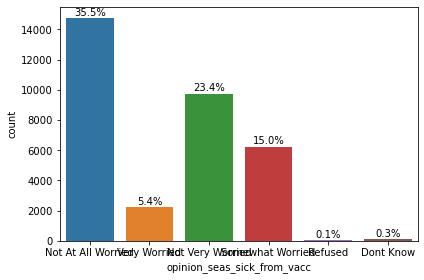

In [ ]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

- Note : ordered categorical type, Don't Know/Refused -> nan, seasonal

In [ ]:
df['opinion_seas_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Very Worried',3,inplace=True)
type_feature['opinion_seas_sick_from_vacc'] = 'ordinal'

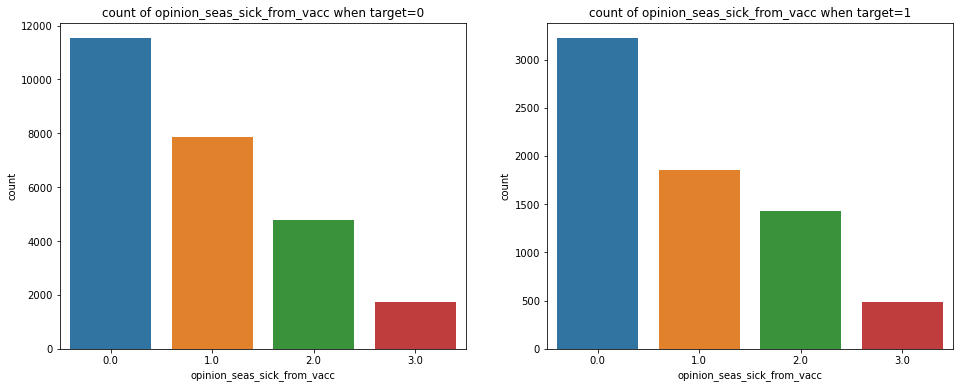

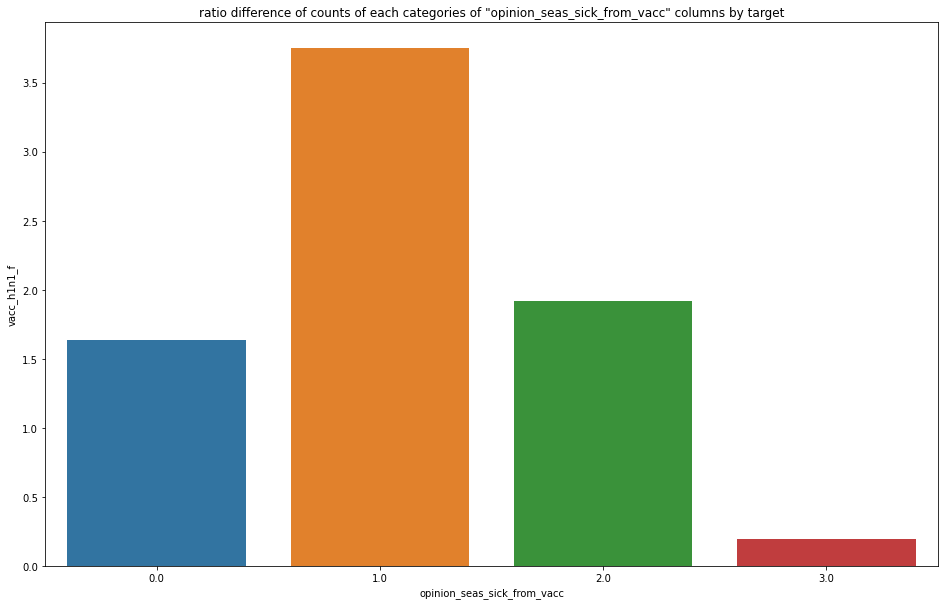

In [ ]:
EDA_plot2(df,'opinion_seas_sick_from_vacc')

##### agegrp

- Description : Age group of respondent.   

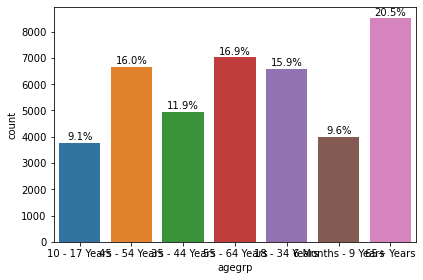

In [ ]:
EDA_plot1(df,'agegrp')

- Note : ordered categorical type

In [ ]:
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)
type_feature['agegrp'] = 'ordinal'

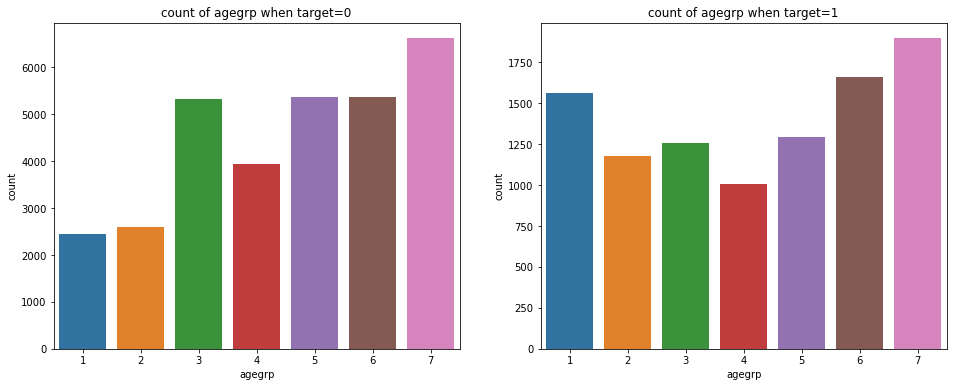

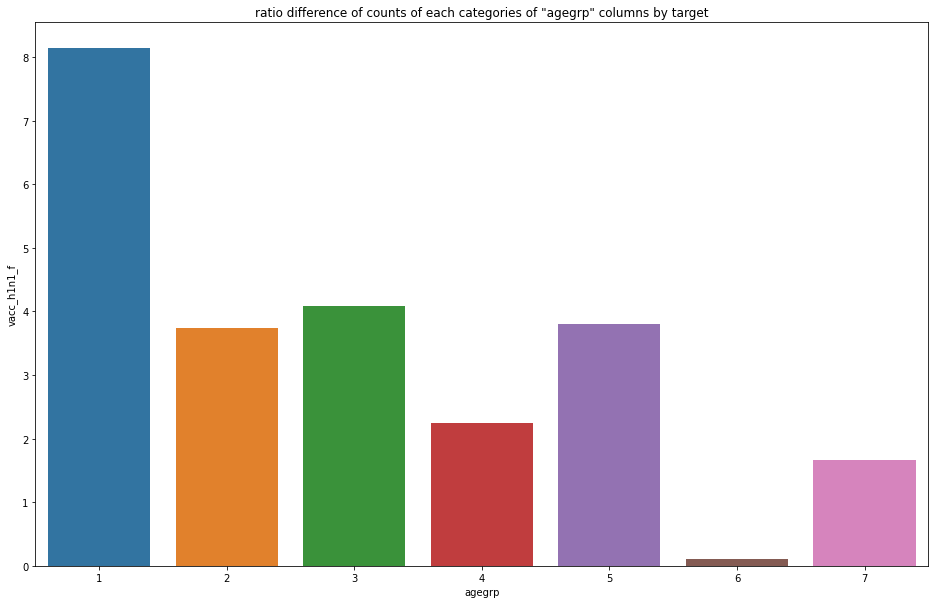

In [ ]:
EDA_plot2(df,'agegrp')

##### education_comp

- Description : Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   

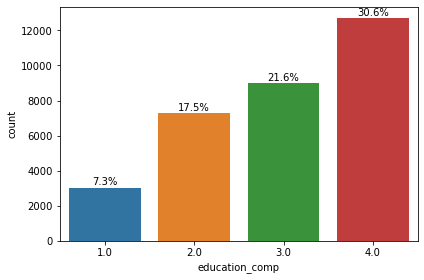

In [ ]:
EDA_plot1(df,'education_comp')

- Note : ordered categorical type

In [ ]:
type_feature['education_comp'] = 'ordinal'

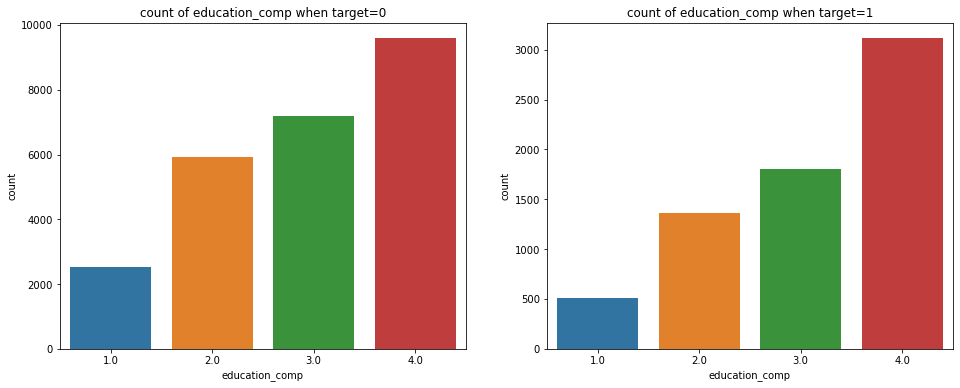

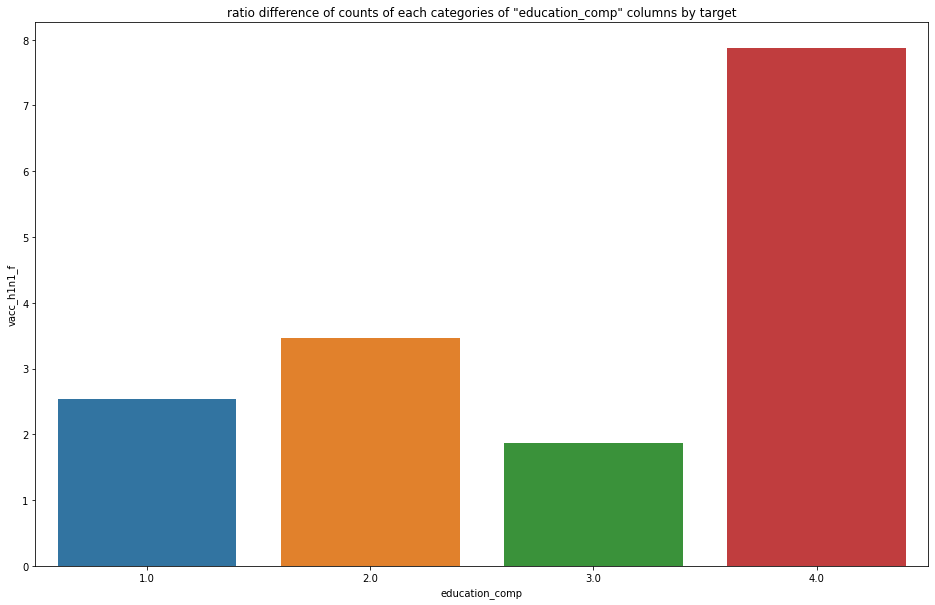

In [ ]:
EDA_plot2(df,'education_comp')

##### raceeth4_i

- Description : Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   

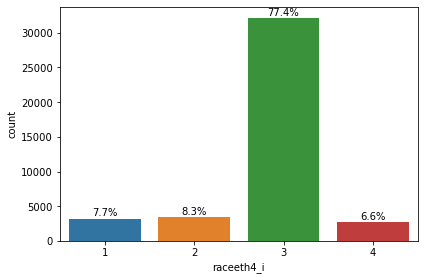

In [ ]:
EDA_plot1(df,'raceeth4_i')

- Note : categorical type

In [ ]:
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
type_feature['raceeth4_i'] = 'nominal'

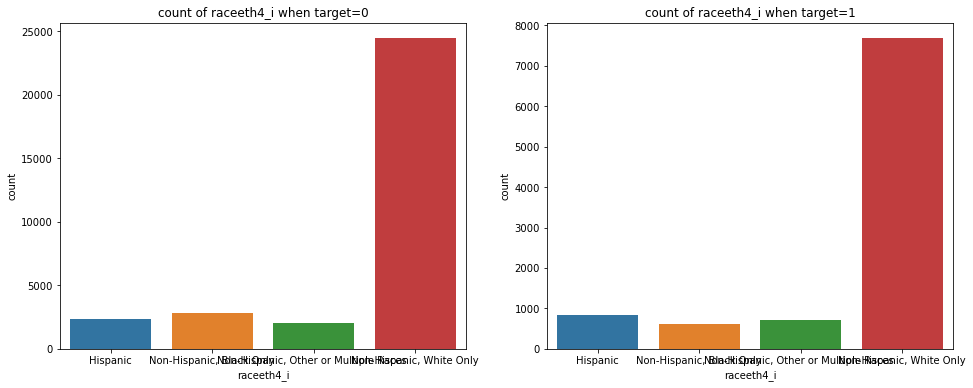

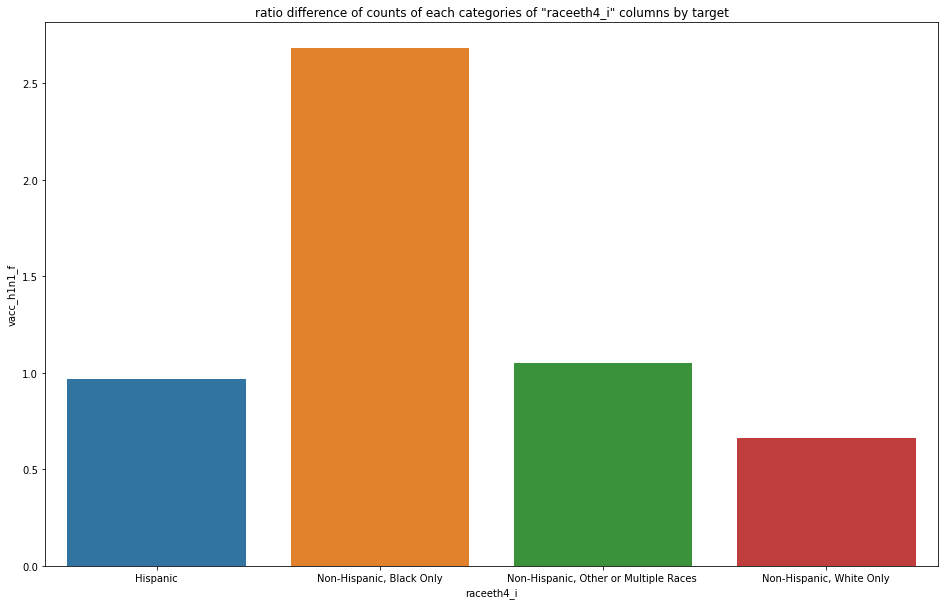

In [ ]:
EDA_plot2(df,'raceeth4_i')

##### sex_i

- Description : Sex of respondent.   
1 = Male; 2 = Female   

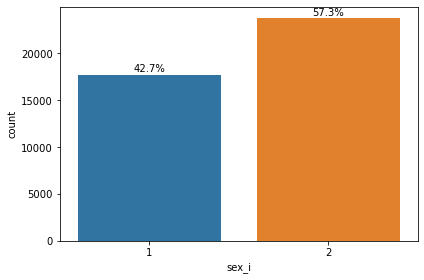

In [ ]:
EDA_plot1(df,'sex_i')

- Note : boolean, Male=True, Female=False

In [ ]:
df['sex_i'].replace(2,0,inplace=True)
type_feature['sex_i'] = 'bool'

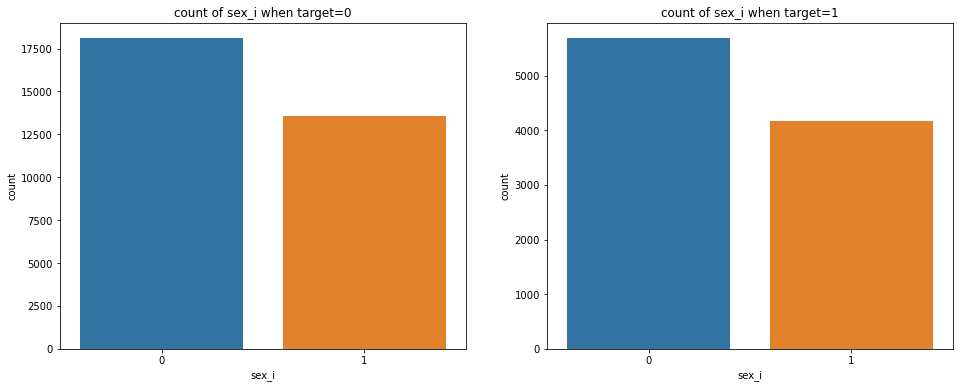

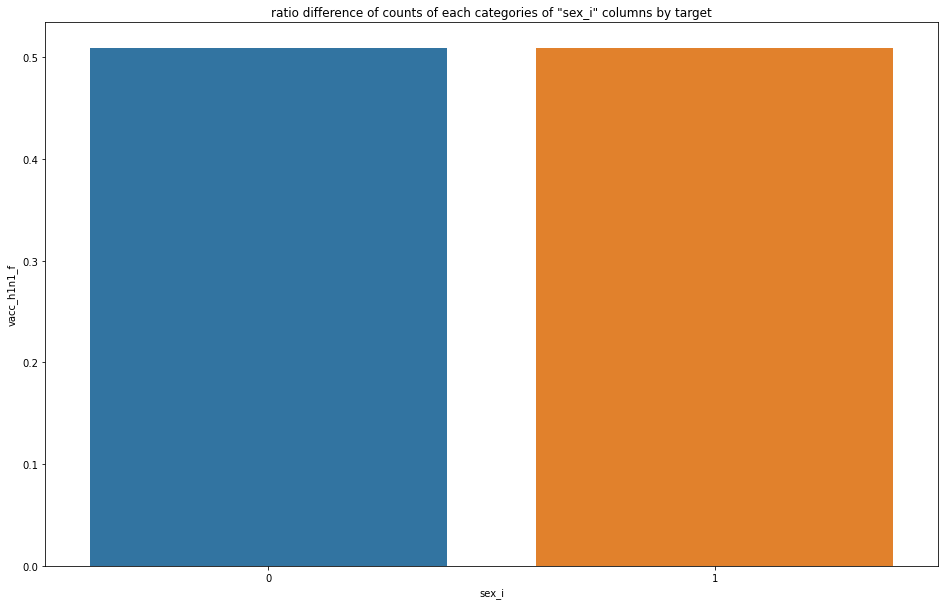

In [ ]:
EDA_plot2(df,'sex_i')

##### inc_pov

- Description : Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 = > $75,000; 2 = <= $75,000; 3 = Below Poverty; 4 = Unknown   

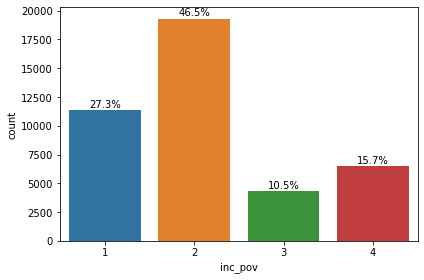

In [ ]:
EDA_plot1(df,'inc_pov')

- Note : ordered categorical type, 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [ ]:
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)
type_feature['inc_pov'] = 'ordinal'

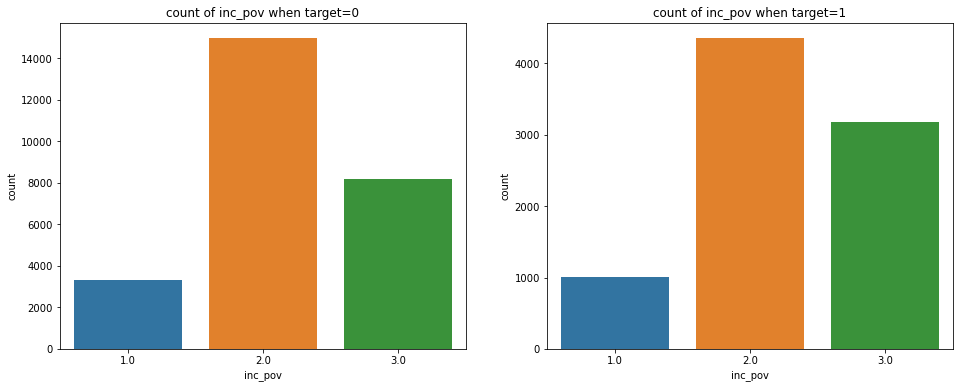

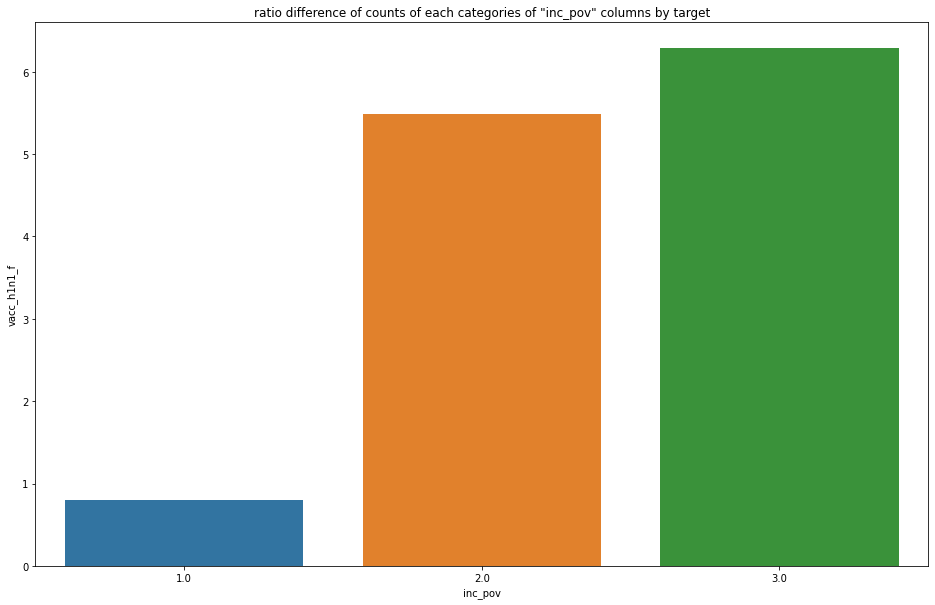

In [ ]:
EDA_plot2(df,'inc_pov')

##### marital

- Description : Marital status of respondent.   
1 = Married; 2 = Not Married   

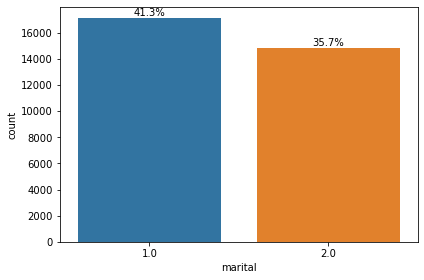

In [ ]:
EDA_plot1(df,'marital')

- Note : boolean

In [ ]:
df['marital'].replace(2,0,inplace=True)
type_feature['marital'] = 'bool'

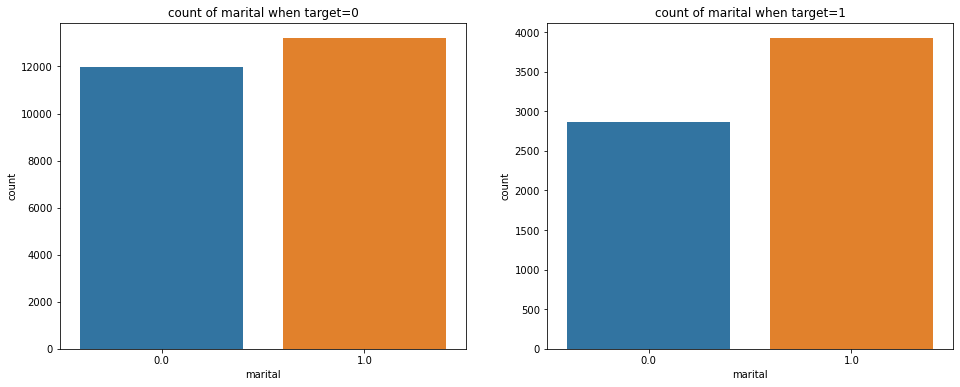

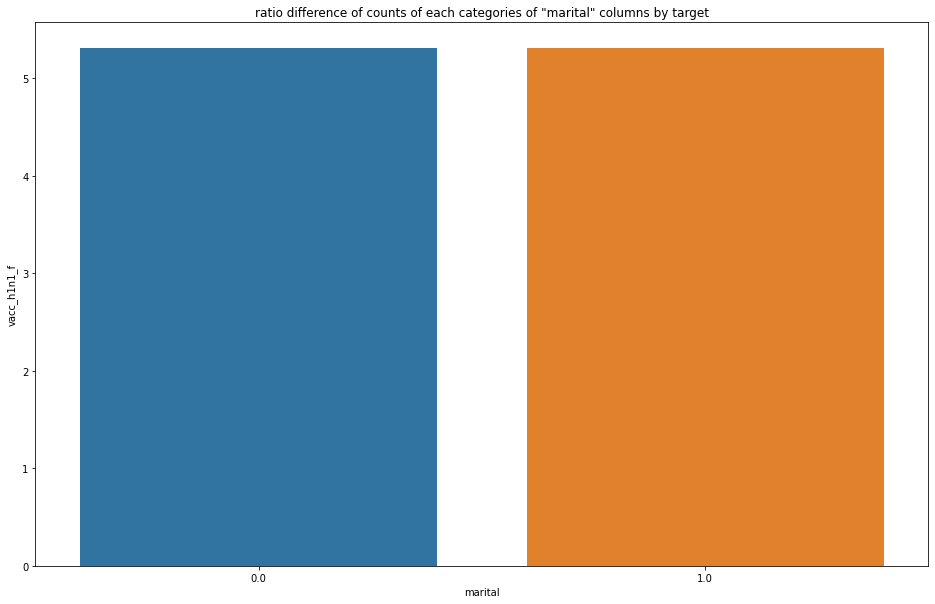

In [ ]:
EDA_plot2(df,'marital')

##### rent_own_r

- Description : Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   

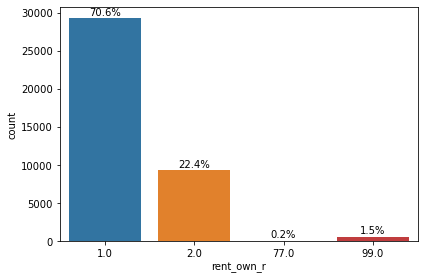

In [ ]:
EDA_plot1(df,'rent_own_r')

- Note : boolean, Outliers(77,99 -> np.nan)

In [ ]:
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(2,0,inplace=True)
type_feature['rent_own_r'] = 'bool'

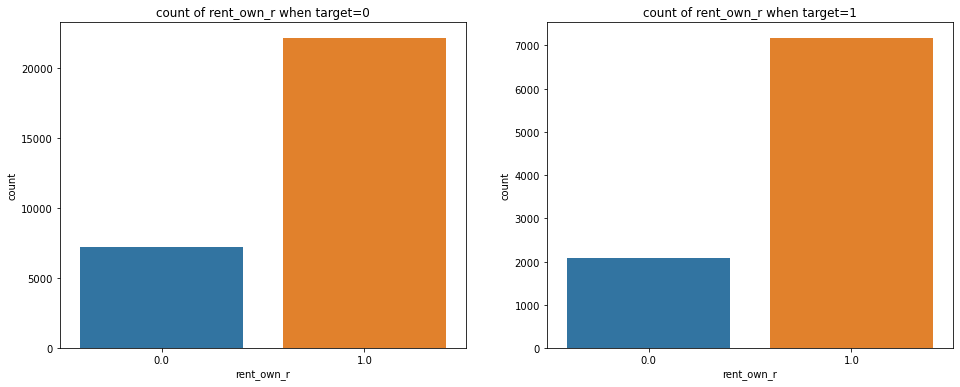

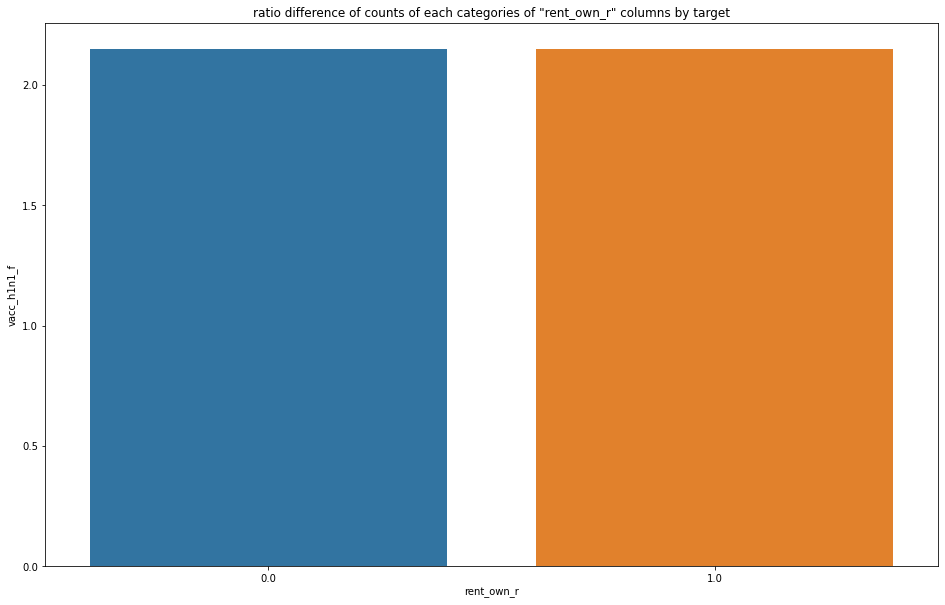

In [ ]:
EDA_plot2(df,'rent_own_r')

##### employment_status

- Description : Employment status of respondent.   

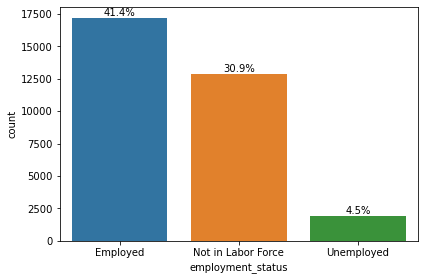

In [ ]:
EDA_plot1(df,'employment_status')

- Note : ordered categorical type

In [ ]:
df['employment_status'].replace('Unemployed',0,inplace=True)
df['employment_status'].replace('Not in Labor Force',1,inplace=True)
df['employment_status'].replace('Employed',2,inplace=True)
type_feature['employment_status'] = 'ordinal'

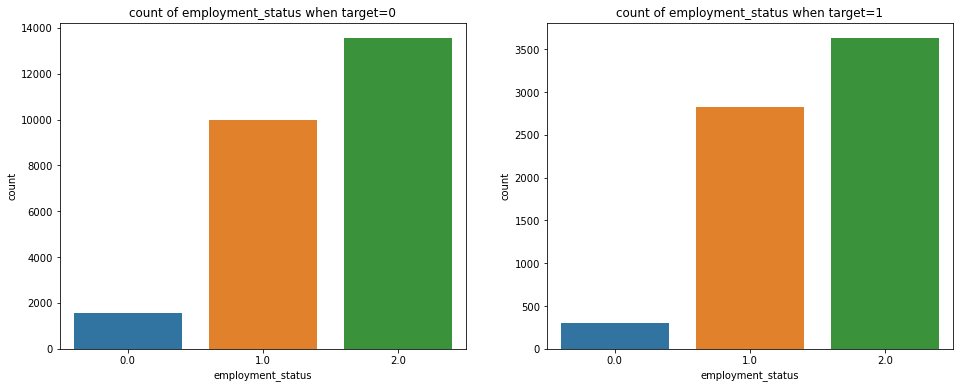

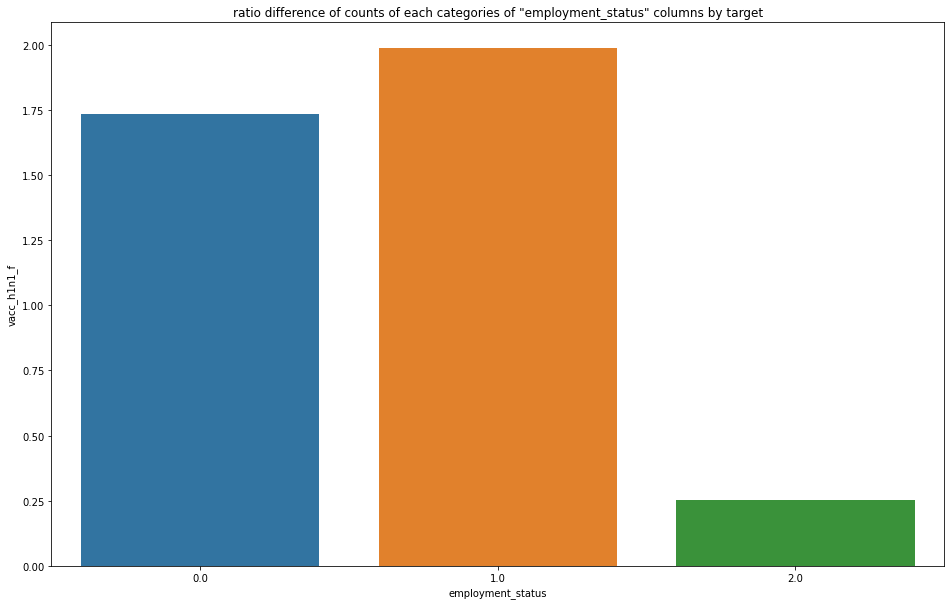

In [ ]:
EDA_plot2(df,'employment_status')

##### census_region

- Description : True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   

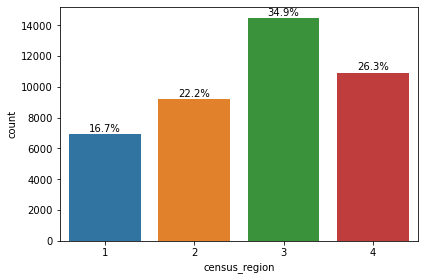

In [ ]:
EDA_plot1(df,'census_region')

- Note : categorical type, location information

In [ ]:
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
type_feature['census_region'] = 'nominal'

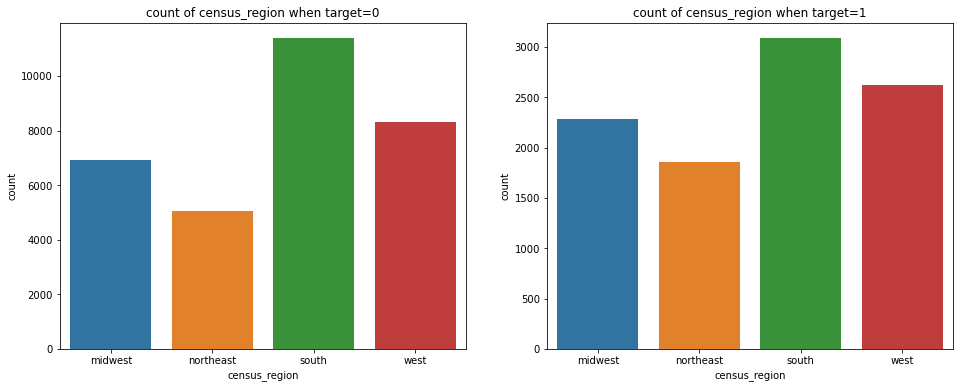

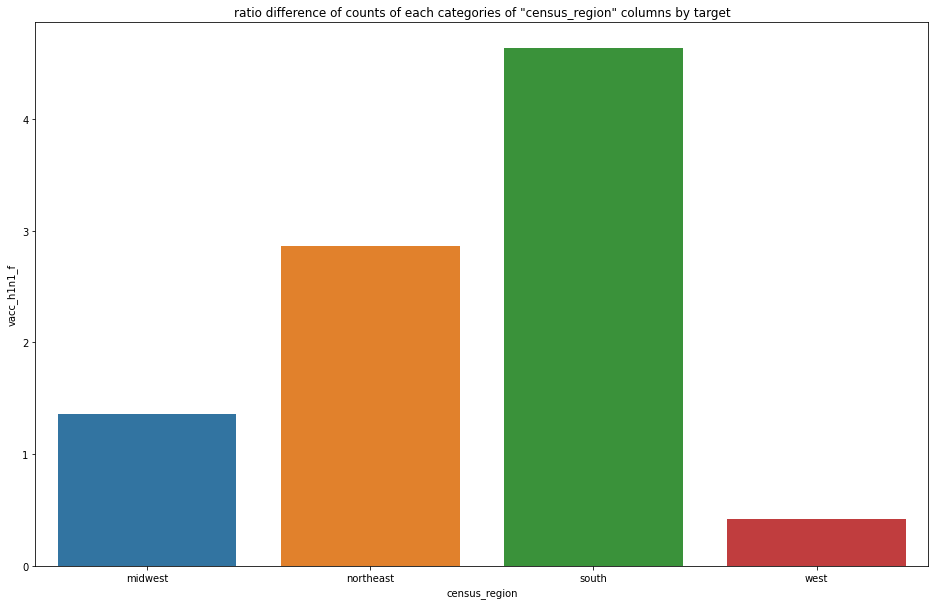

In [ ]:
EDA_plot2(df,'census_region')

##### census_msa

- Description : Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   

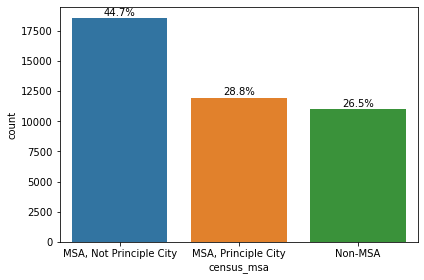

In [ ]:
EDA_plot1(df,'census_msa')

- Note : ordered categorical type, location information

In [ ]:
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)
type_feature['census_msa'] = 'ordinal'

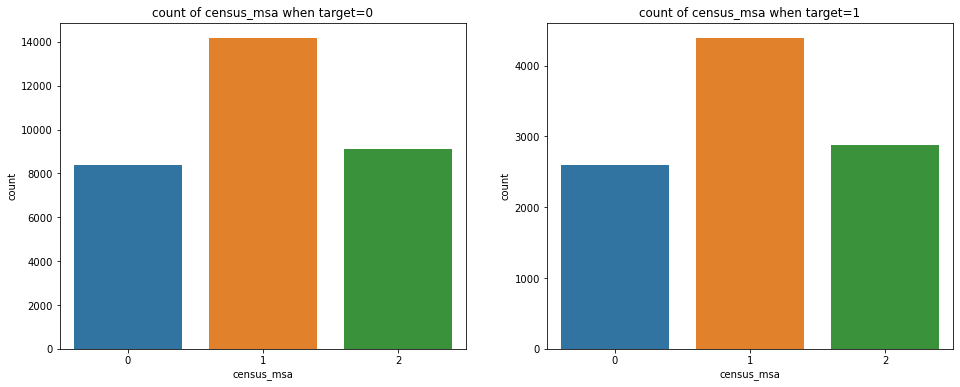

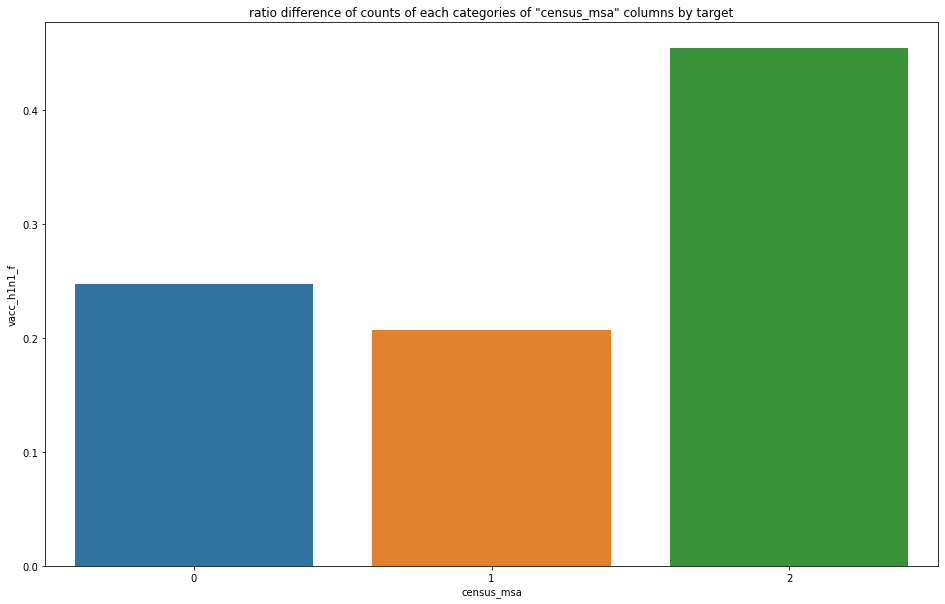

In [ ]:
EDA_plot2(df,'census_msa')

##### n_adult_r

- Description : Number of other adults in household.   

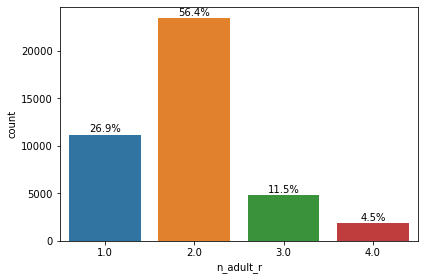

In [ ]:
EDA_plot1(df,'n_adult_r')

- Note : ordered categorical type, corr with n_people_r

In [ ]:
type_feature['n_adult_r'] = 'interval'

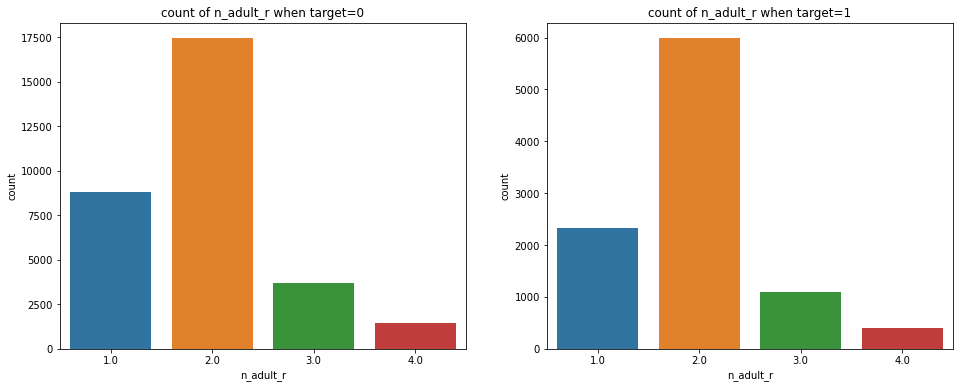

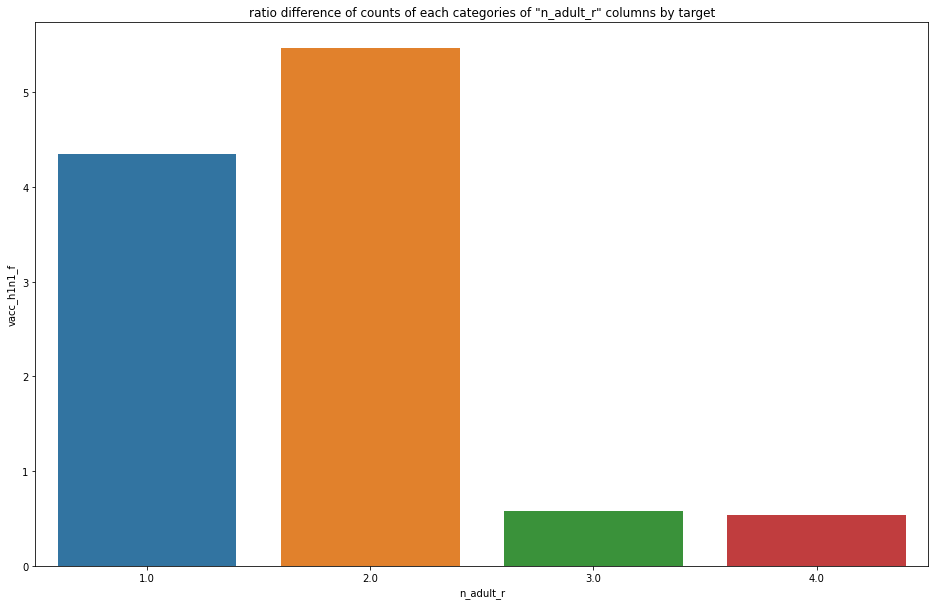

In [ ]:
EDA_plot2(df,'n_adult_r')

##### household_children

- Description : Number of children in household.   

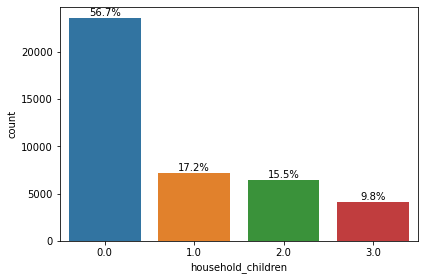

In [ ]:
EDA_plot1(df,'household_children')

- Note : ordered categorical type, corr with n_people_r

In [ ]:
type_feature['household_children'] = 'interval'

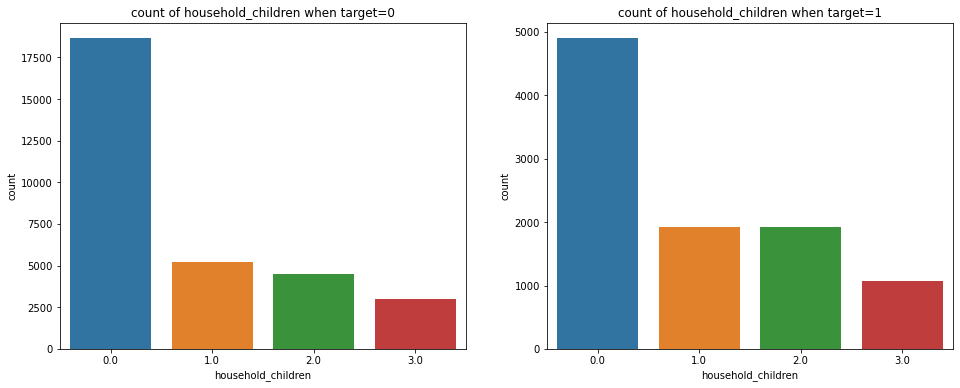

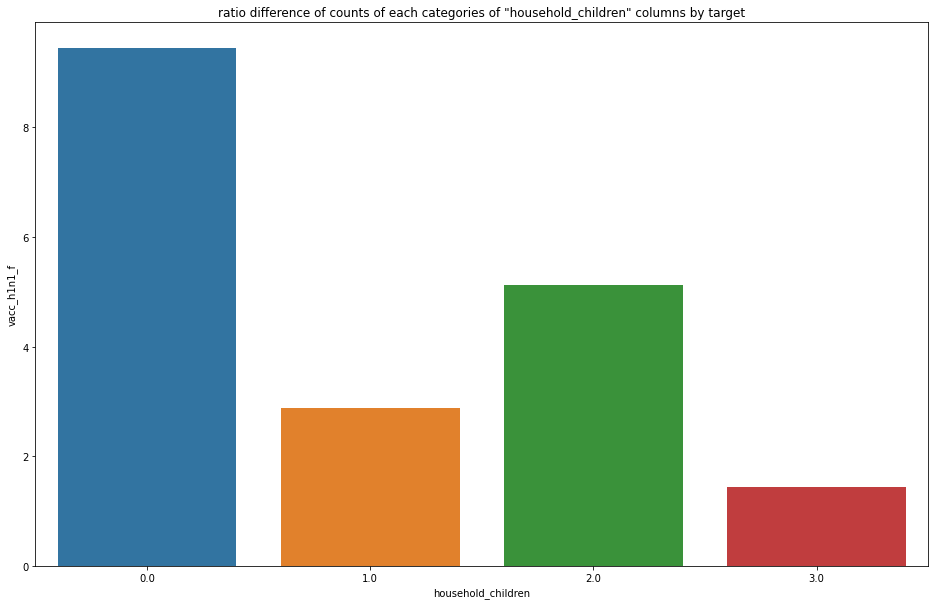

In [ ]:
EDA_plot2(df,'household_children')

##### n_people_r

- Description : Number of adults in the household.   

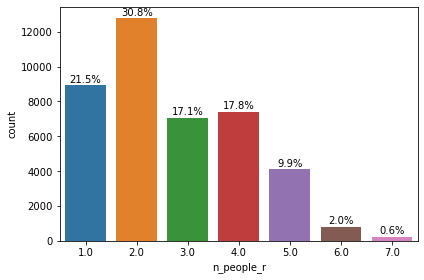

In [ ]:
EDA_plot1(df,'n_people_r')

- Note : ordered categorical type, corr with n_adult_r and household_children

In [ ]:
type_feature['n_people_r'] = 'interval'

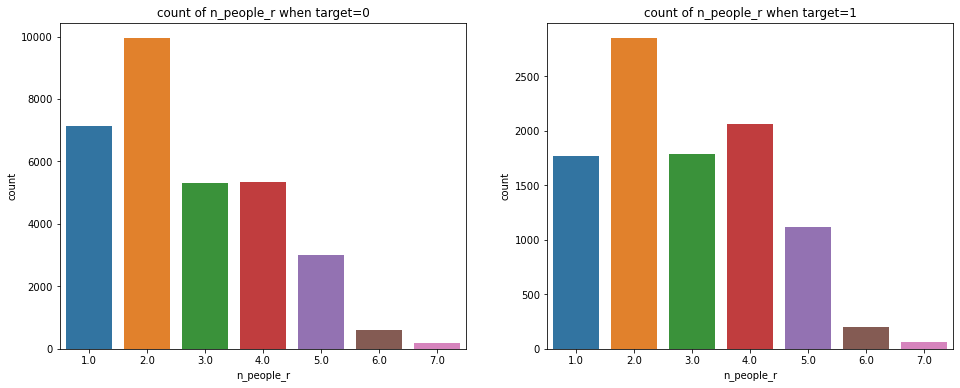

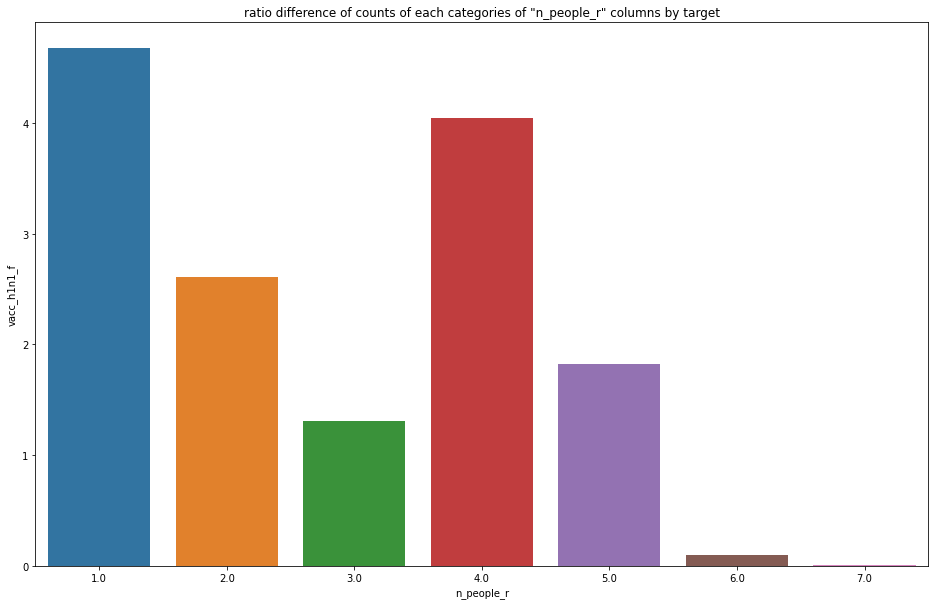

In [ ]:
EDA_plot2(df,'n_people_r')

##### employment_industry

- Description : Type of industry respondent is employed in.   

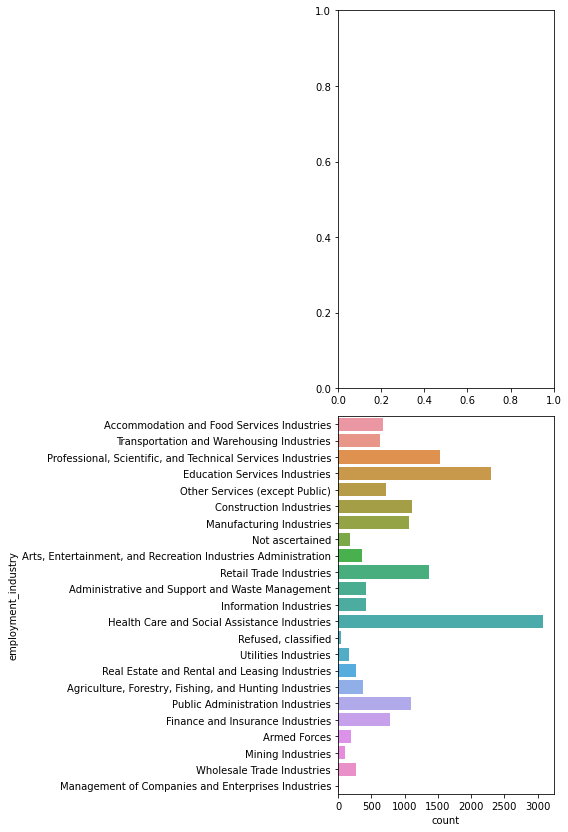

In [ ]:
EDA_plot1(df,'employment_industry')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_occupation

In [ ]:
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_industry'] = 'nominal'

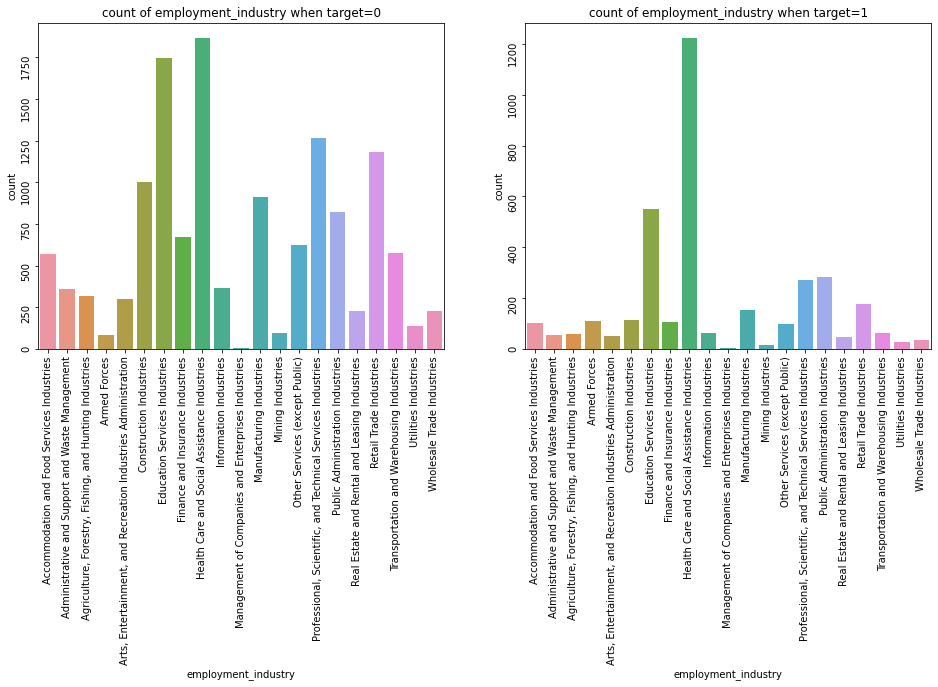

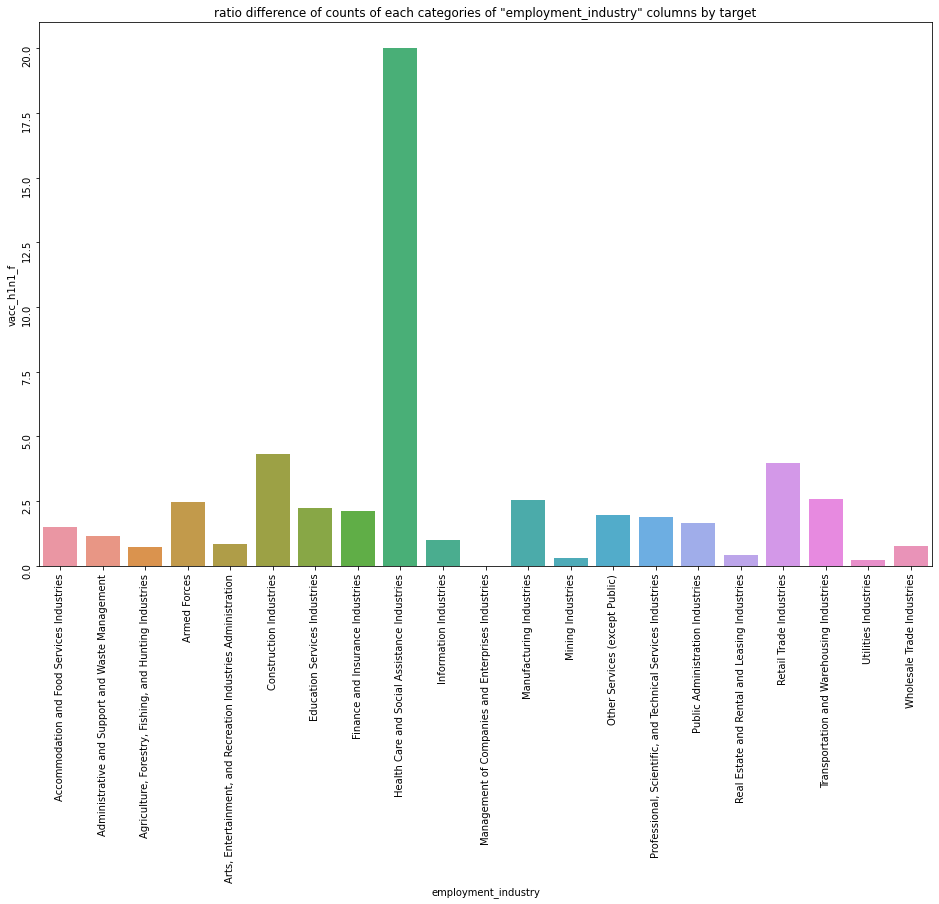

In [ ]:
EDA_plot2(df,'employment_industry',rot=90)

##### employment_occupation

- Description : Type of occupation of respondent. Values are represented as short random character strings.   

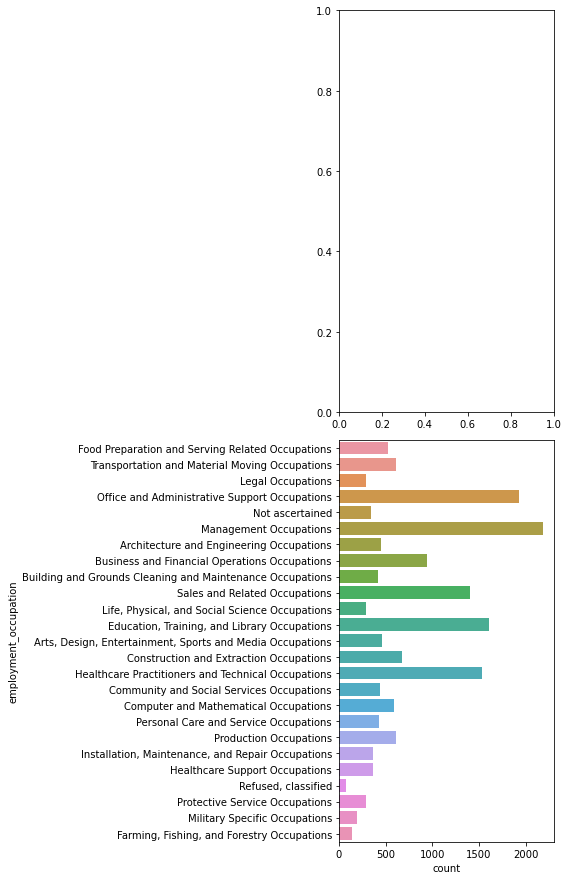

In [ ]:
EDA_plot1(df,'employment_occupation')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_industry

In [ ]:
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_occupation'] = 'nominal'

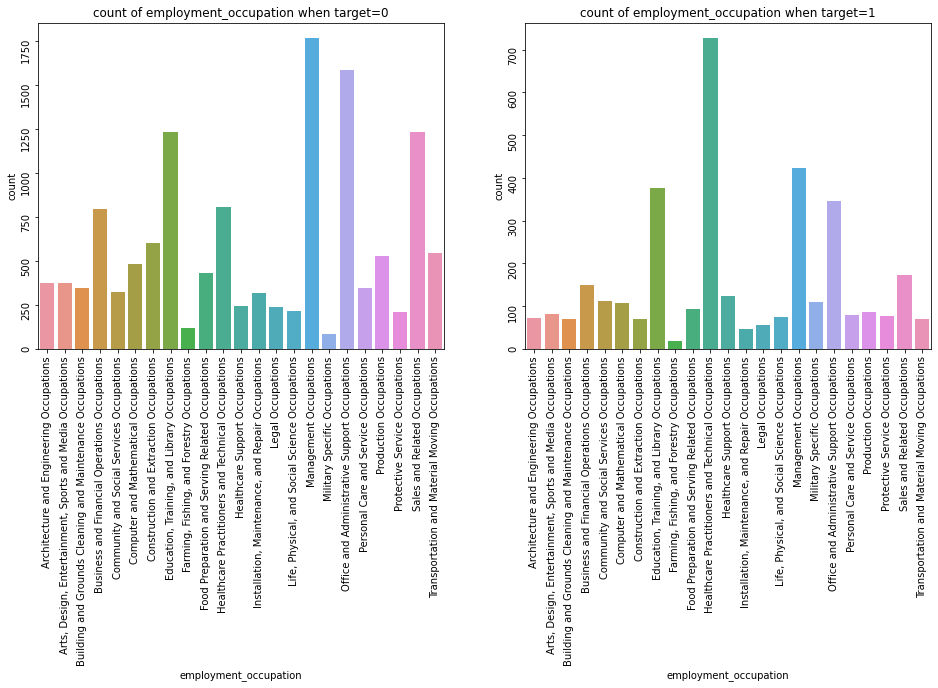

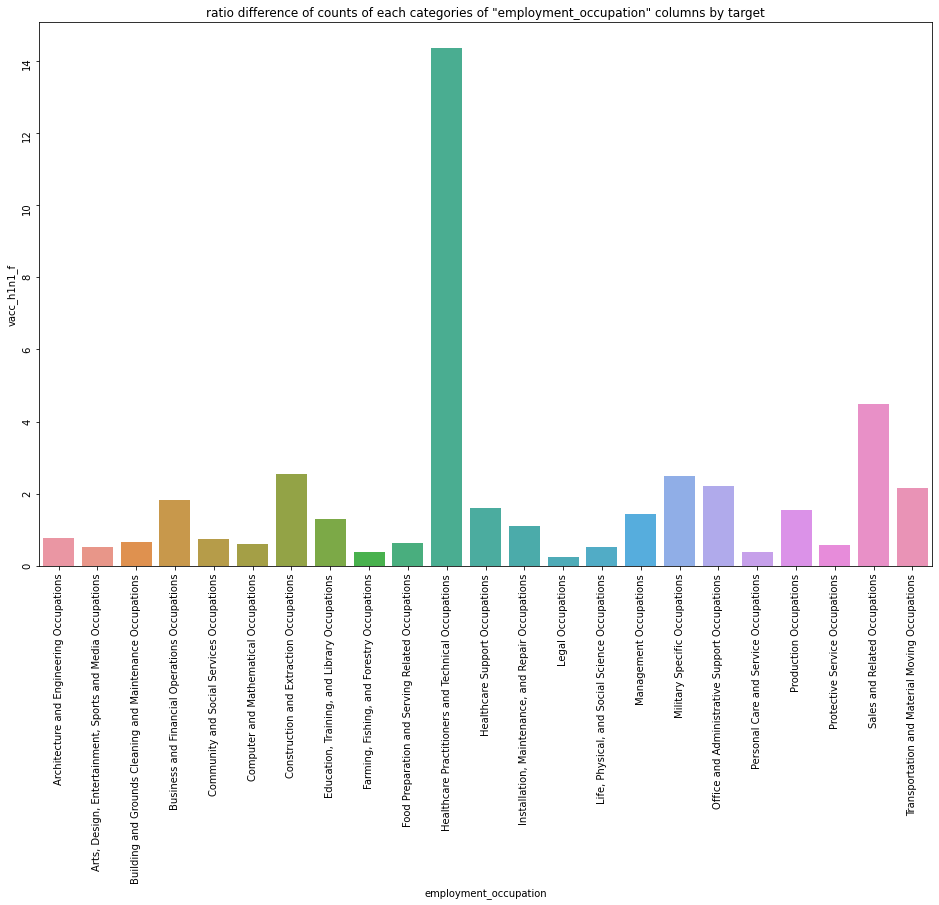

In [ ]:
EDA_plot2(df,'employment_occupation',rot=90)

##### hhs_region

- Description : HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   

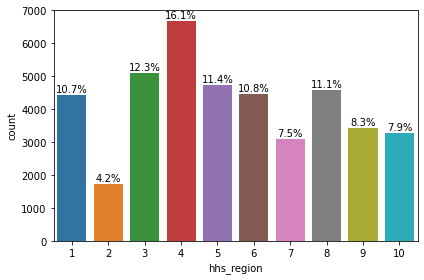

In [ ]:
EDA_plot1(df,'hhs_region')

- Note : categorical type, location information, high cardinality

In [ ]:
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
type_feature['hhs_region'] = 'nominal'

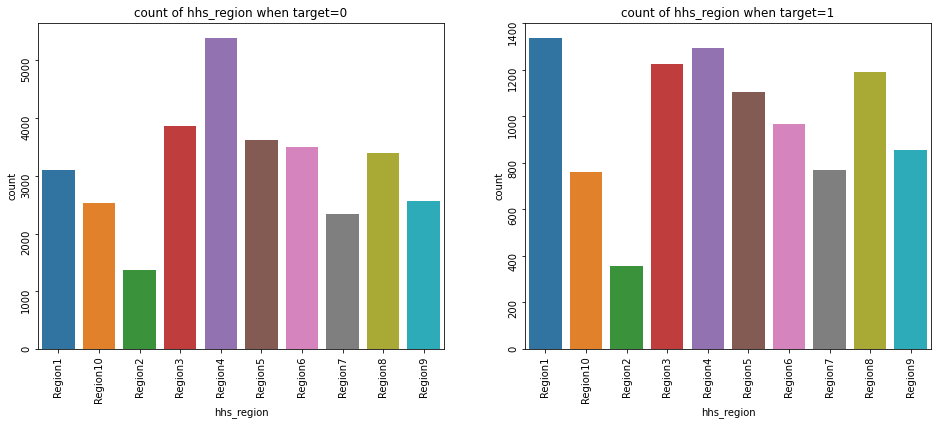

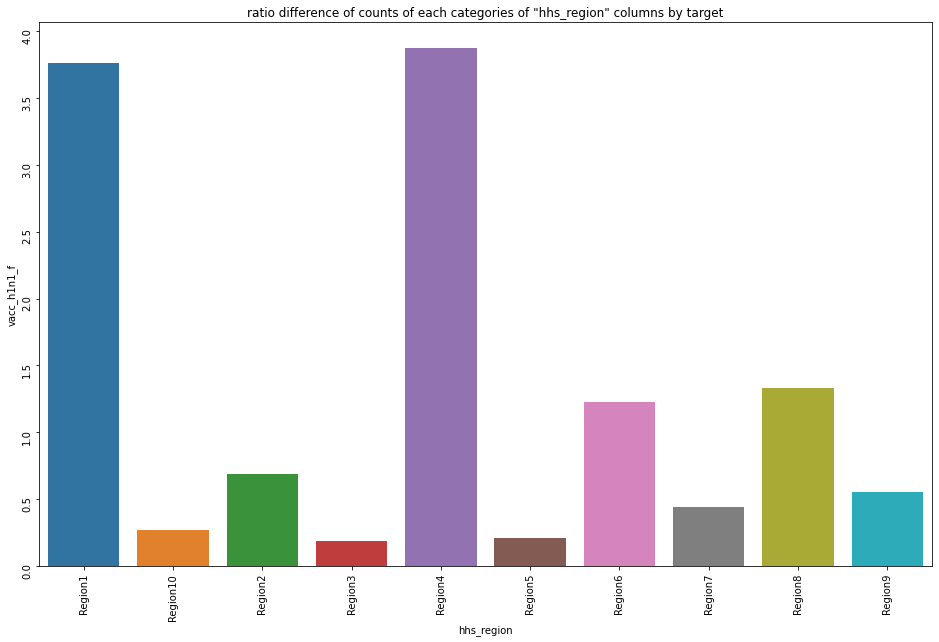

In [ ]:
EDA_plot2(df,'hhs_region',rot=90)

##### state

- Description : State of residence   

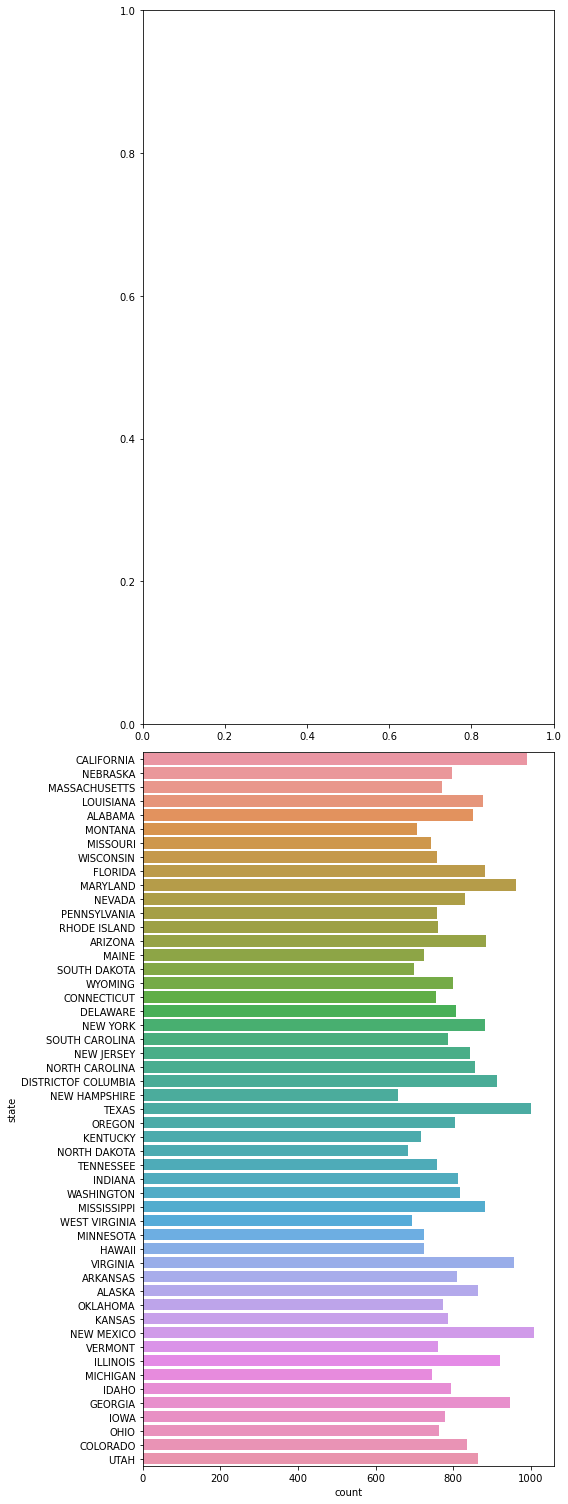

In [ ]:
EDA_plot1(df,'state')

- Note : categorical type, local information, high cardinality

In [ ]:
df['state'].replace('ALABAMA','AL',inplace=True)
df['state'].replace('ALASKA','AK',inplace=True)
df['state'].replace('ARIZONA','AZ',inplace=True)
df['state'].replace('ARKANSAS','AR',inplace=True)
df['state'].replace('CALIFORNIA','CA',inplace=True)
df['state'].replace('COLORADO','CO',inplace=True)
df['state'].replace('CONNECTICUT','CT',inplace=True)
df['state'].replace('DELAWARE','DE',inplace=True)
df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
df['state'].replace('FLORIDA','FL',inplace=True)
df['state'].replace('GEORGIA','GA',inplace=True)
df['state'].replace('HAWAII','HI',inplace=True)
df['state'].replace('IDAHO','ID',inplace=True)
df['state'].replace('ILLINOIS','IL',inplace=True)
df['state'].replace('INDIANA','IN',inplace=True)
df['state'].replace('IOWA','IA',inplace=True)
df['state'].replace('KANSAS','KS',inplace=True)
df['state'].replace('KENTUCKY','KY',inplace=True)
df['state'].replace('LOUISIANA','LA',inplace=True)
df['state'].replace('MAINE','ME',inplace=True)
df['state'].replace('MARYLAND','MD',inplace=True)
df['state'].replace('MASSACHUSETTS','MA',inplace=True)
df['state'].replace('MICHIGAN','MI',inplace=True)
df['state'].replace('MINNESOTA','MN',inplace=True)
df['state'].replace('MISSISSIPPI','MS',inplace=True)
df['state'].replace('MISSOURI','MO',inplace=True)
df['state'].replace('MONTANA','MT',inplace=True)
df['state'].replace('NEBRASKA','NE',inplace=True)
df['state'].replace('NEVADA','NV',inplace=True)
df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
df['state'].replace('NEW JERSEY','NJ',inplace=True)
df['state'].replace('NEW MEXICO','NM',inplace=True)
df['state'].replace('NEW YORK','NY',inplace=True)
df['state'].replace('NORTH CAROLINA','NC',inplace=True)
df['state'].replace('NORTH DAKOTA','ND',inplace=True)
df['state'].replace('OHIO','OH',inplace=True)
df['state'].replace('OKLAHOMA','OK',inplace=True)
df['state'].replace('OREGON','OR',inplace=True)
df['state'].replace('PENNSYLVANIA','PA',inplace=True)
df['state'].replace('RHODE ISLAND','RI',inplace=True)
df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
df['state'].replace('TENNESSEE','TN',inplace=True)
df['state'].replace('TEXAS','TX',inplace=True)
df['state'].replace('UTAH','UT',inplace=True)
df['state'].replace('VERMONT','VT',inplace=True)
df['state'].replace('VIRGINIA','VA',inplace=True)
df['state'].replace('WASHINGTON','WA',inplace=True)
df['state'].replace('WEST VIRGINIA','WV',inplace=True)
df['state'].replace('WISCONSIN','WI',inplace=True)
df['state'].replace('WYOMING','WY',inplace=True)
type_feature['state'] = 'nominal'

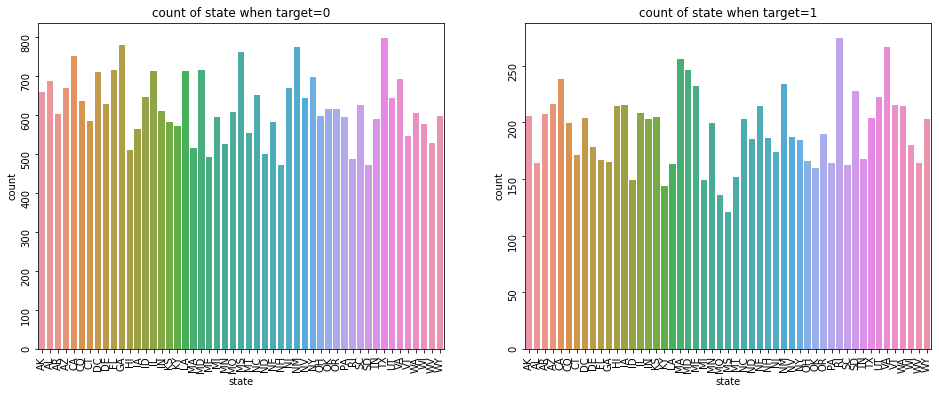

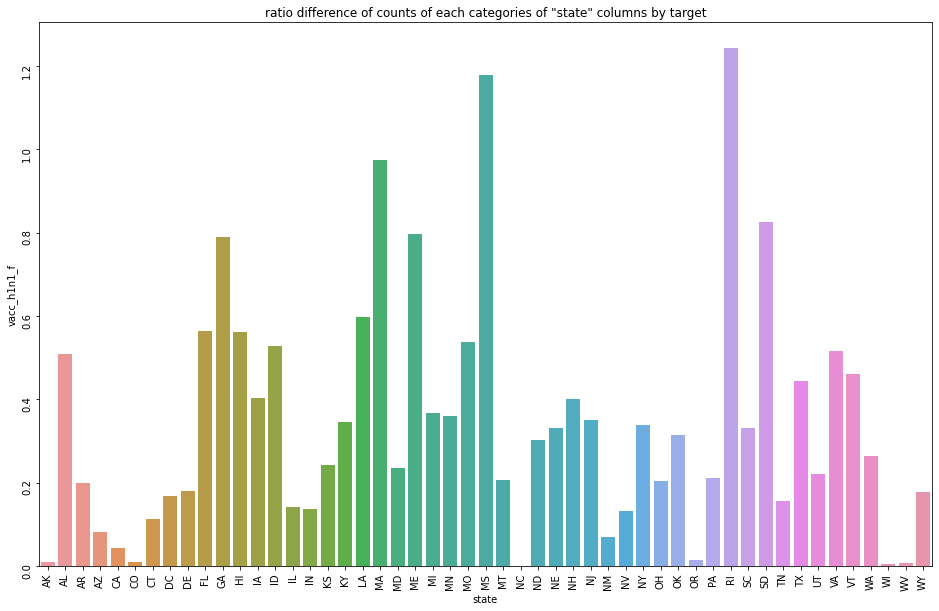

In [ ]:
EDA_plot2(df,'state',rot=90)

##### map visualization
feature : state, hhs_region, census_region

In [ ]:
import json
import requests
from matplotlib.patches import Polygon
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
dc={"type":"Feature","id":"DC","properties":{"name":"District of Columbia"},"geometry":{"type":"Polygon","coordinates":[[[-77.040741, 38.791222],[-76.909294, 38.895284],[-77.035264, 38.993869],[-77.117418, 38.933623]]]}}
state_geo=dict(json.loads(requests.get(state_geo).text))['features']
state_geo.append(dc)

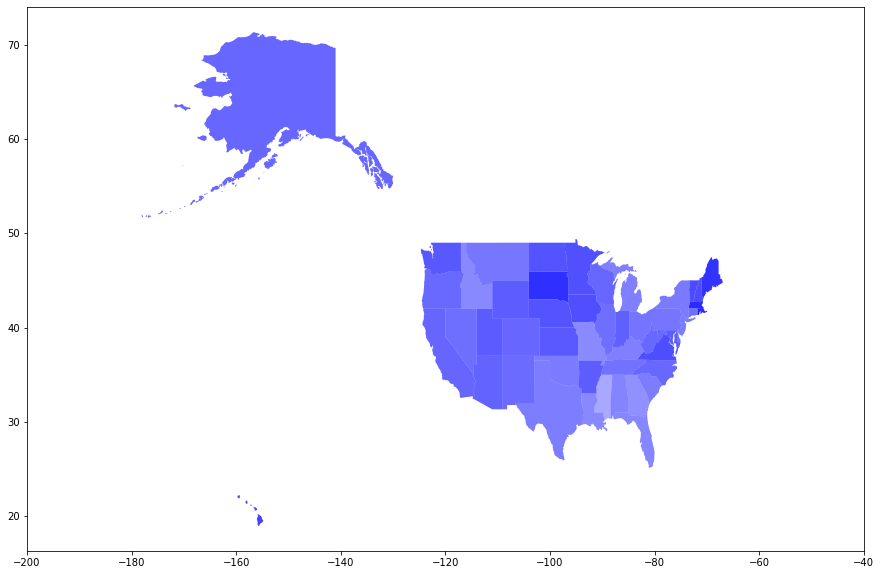

In [ ]:
# vaccine rate group by state
vacc_rate_geo=df[['state','vacc_h1n1_f']].groupby(['state']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

In [ ]:
# region relationships, census_msa can't be seperated by state
hhs={}
for i in range(10):
    hhs[f'Region{i+1}']=[]
census={
    'west':[],
    'midwest':[],
    'northeast':[],
    'south':[]
}
for s in df['state'].unique():
    hhs[df[df['state']==s]['hhs_region'].unique()[0]].append(s)
    census[df[df['state']==s]['census_region'].unique()[0]].append(s)
region_dict={}
for s in df['state'].unique():
    region_dict[s]=[df[df['state']==s]['hhs_region'].unique()[0],df[df['state']==s]['census_region'].unique()[0]]

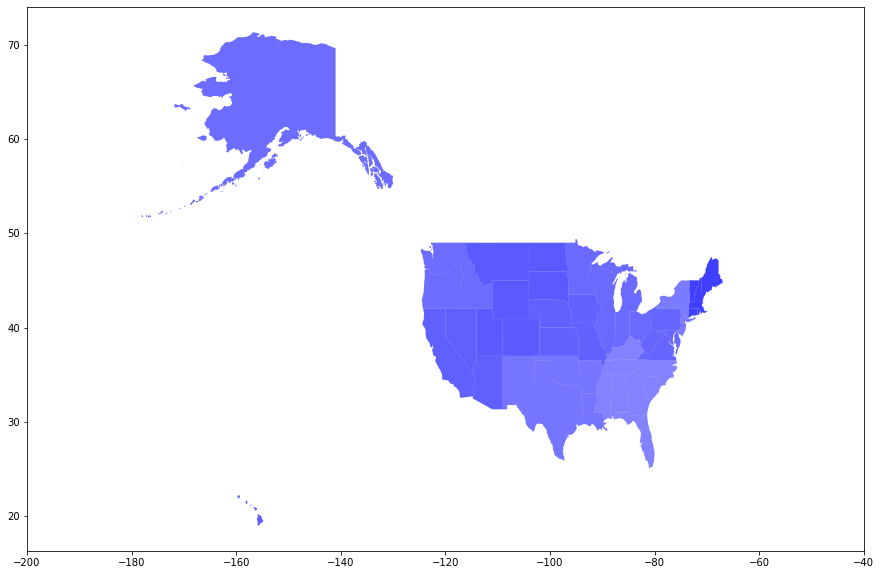

In [ ]:
# vaccine rate group by hhs_region
vacc_rate_hhs=df[['hhs_region','vacc_h1n1_f']].groupby(['hhs_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

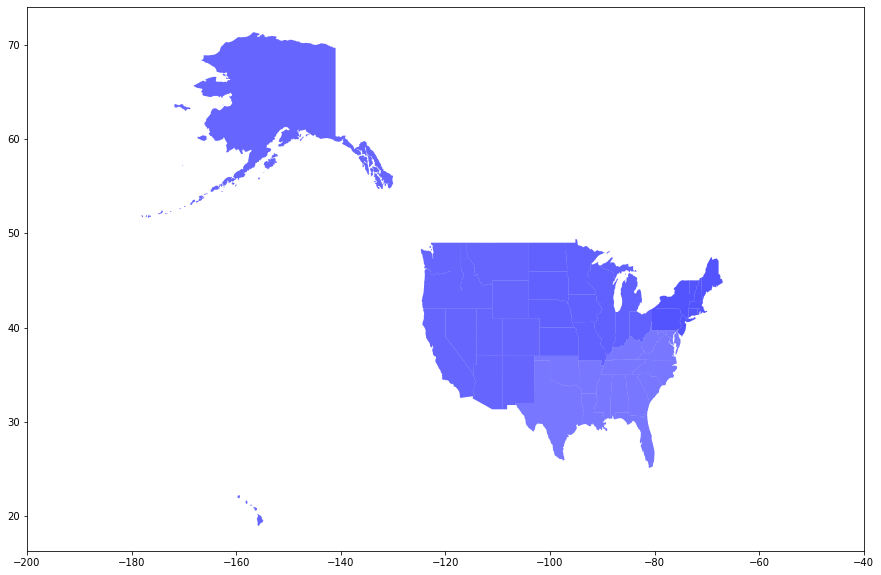

In [ ]:
# vaccine rate group by census_region
vacc_rate_census=df[['census_region','vacc_h1n1_f']].groupby(['census_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

(state, hhs_region, census_region)x(vacc_h1n1_f, ...) more EDA probability

#### Multivariate analysis

##### Missing pattern and Structurally missing data

In [ ]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns = map(lambda x: x+'_mv',df.columns)
df_MV.head()

h1n1_concern_mv  h1n1_knowledge_mv  behavioral_antiviral_meds_mv  \
0             True               True                          True   
1            False              False                         False   
2            False              False                         False   
3            False              False                         False   
4            False              False                         False   

   behavioral_avoidance_mv  behavioral_face_mask_mv  behavioral_wash_hands_mv  \
0                     True                     True                      True   
1                    False                    False                     False   
2                    False                    False                     False   
3                    False                    False                     False   
4                    False                    False                     False   

   behavioral_large_gatherings_mv  behavioral_outside_home_mv  \
0                            True                        True   
1                           False                       False   
2                           False                       False   
3                           False                       False   
4                           False                       False   

   behavioral_touch_face_mv  doctor_recc_h1n1_mv  ...  census_msa_mv  \
0                      True                False  ...          False   
1                     False                False  ...          False   
2                     False                False  ...          False   
3                     False                False  ...          False   
4                     False                False  ...          False   

   n_adult_r_mv  household_children_mv  n_people_r_mv  employment_industry_mv  \
0         False                  False          False                    True   
1         False                  False          False                   False   
2         False                  False          False                   False   
3         False                  False          False                   False   
4         False                  False          False                   False   

   employment_occupation_mv  hhs_region_mv  state_mv  vacc_h1n1_f_mv  \
0                      True          False     False           False   
1                     False          False     False           False   
2                     False          False     False           False   
3                     False          False     False           False   
4                     False          False     False           False   

   vacc_seas_f_mv  
0           False  
1           False  
2           False  
3           False  
4           False  

[5 rows x 40 columns]

<AxesSubplot:>

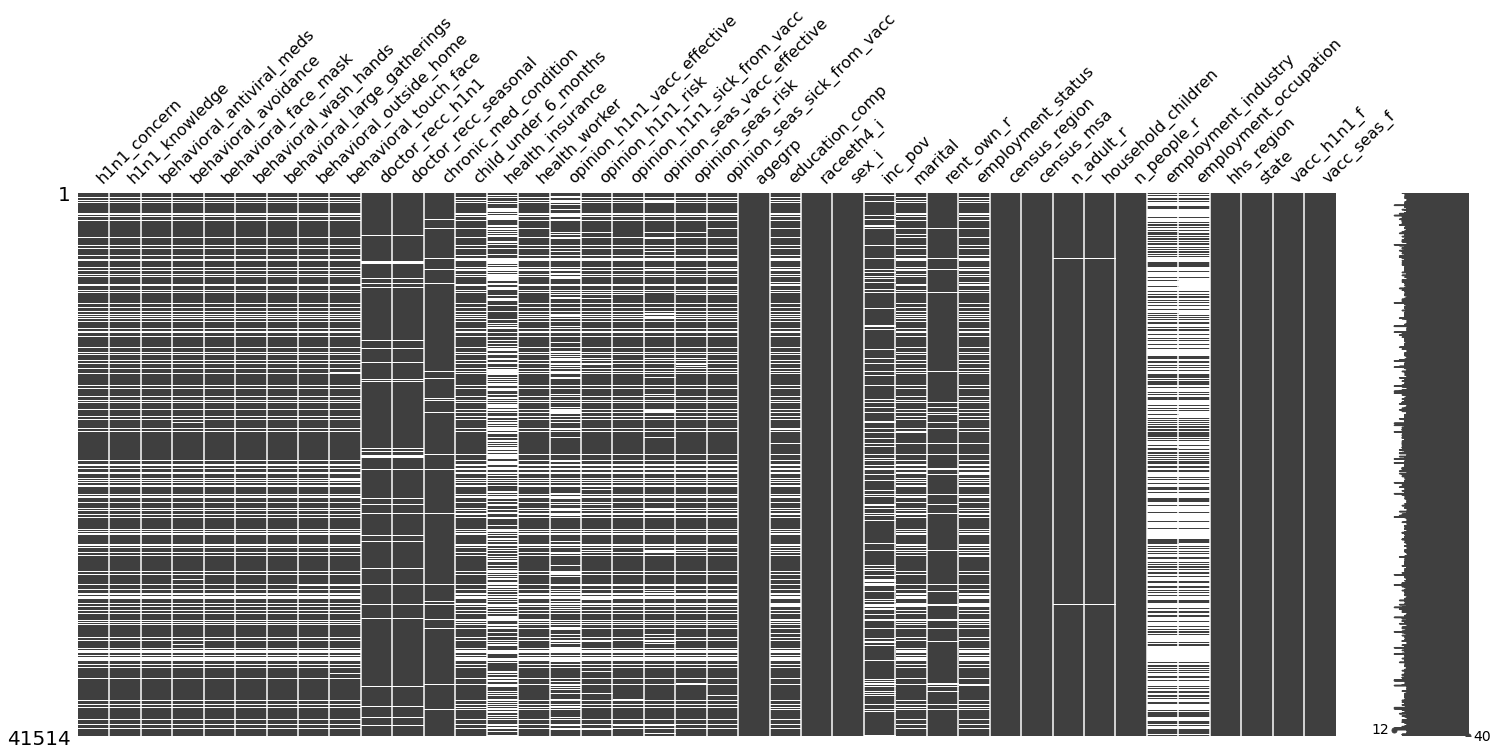

In [ ]:
msno.matrix(df)

<AxesSubplot:>

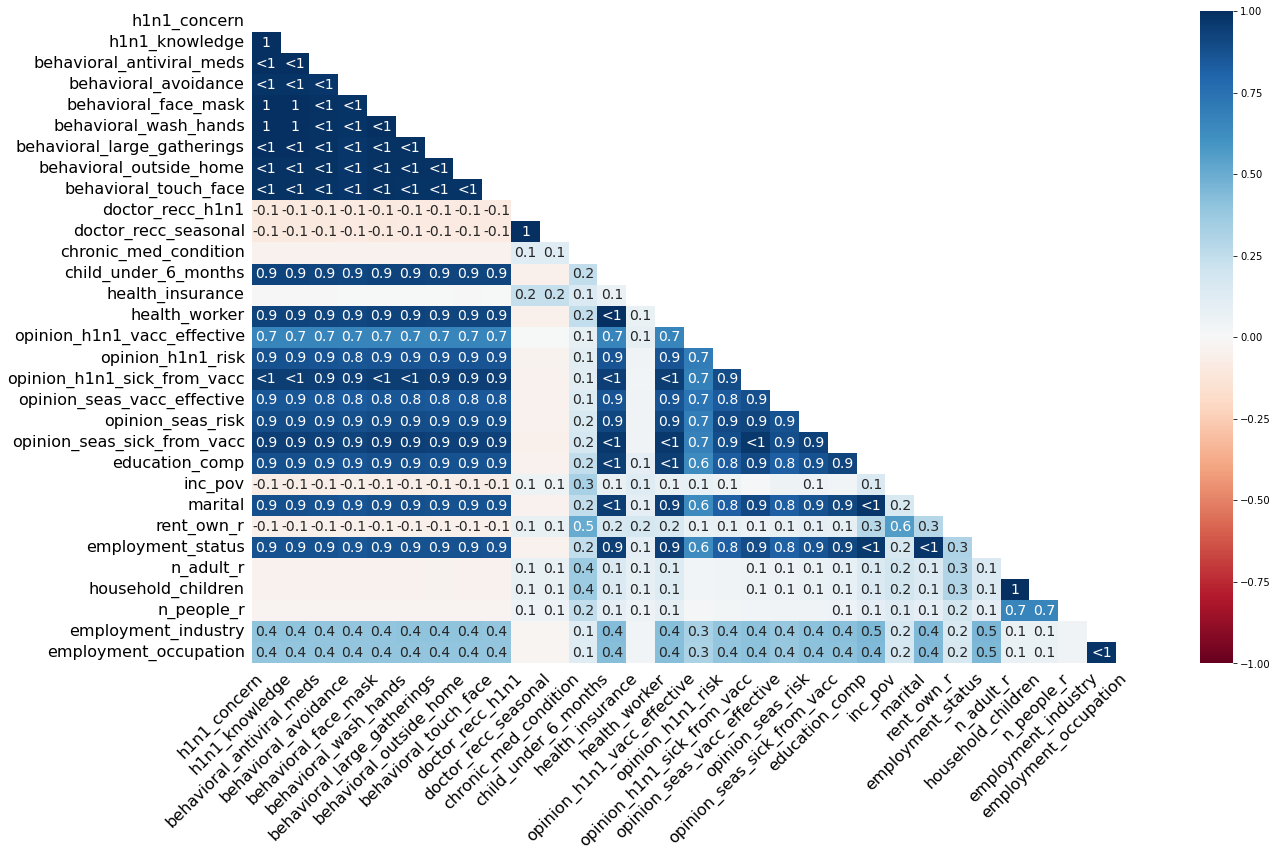

In [ ]:
msno.heatmap(df)

<AxesSubplot:ylabel='Density'>

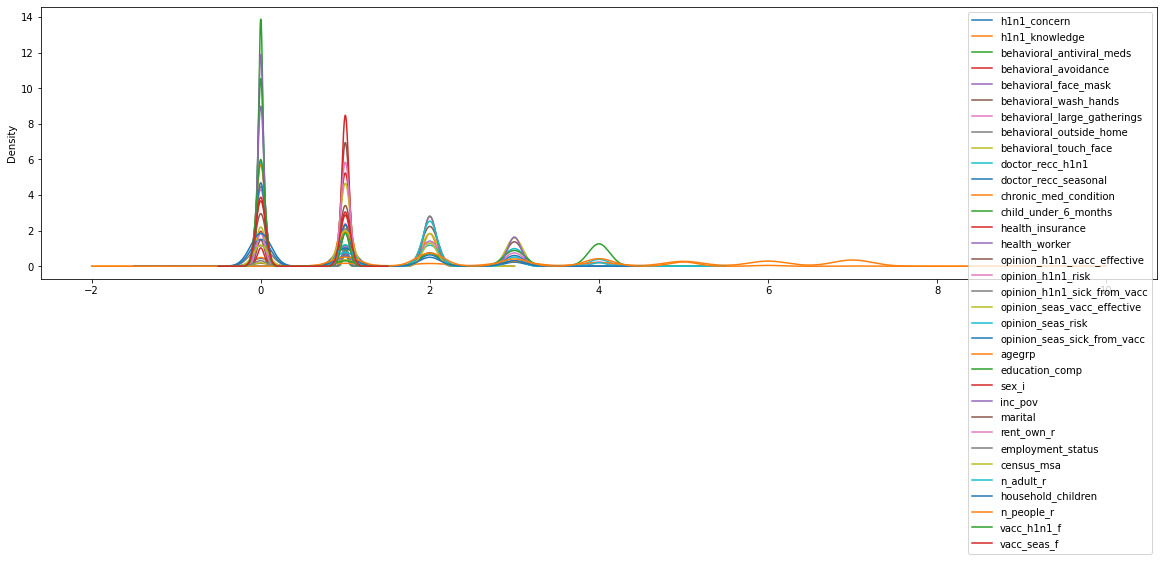

In [ ]:
df.plot.density(figsize=(20,5))

- Missing patterns   
    - pattern_A
        - h1n1_concern
        - h1n1_knowledge
        - behavioral_antiviral_meds
        - behavioral_avoidance
        - behavioral_face_mask
        - behavioral_wash_hands
        - behavioral_large_gatherings
        - behavioral_outside_home
        - behavioral_touch_face
        - child_under_6_months
        - health_worker
        - opinion_h1n1_vacc_effective *
        - opinion_h1n1_risk
        - opinion_h1n1_sick_from_vacc
        - opinion_seas_vacc_effective
        - opinion_seas_risk
        - opinion_seas_sick_from_vacc
        - education_comp
        - marital
        - employment_status
    - pattern_B
        - doctor_recc_h1n1
        - doctor_recc_seasonal
    - pattern_C
        - n_adult_r
        - househole_children
        - n_people_r
    - pattern_D
        - employment_industry
        - employment_occupation

- Structurally missing data

In [ ]:
#corr 직접 구해야함. corr()메소드는 50개만 구함, 이거따로 바로 위로올라갈지도
df_MV_corr=pd.concat([df,df_MV],axis=1)
df.shape, df_MV.shape, df_MV_corr.shape
#이 방법 말고 structurely missing data 검출가능한가?
# smd는 특정 카테고리가 특정 feature에서 전부 nan값이 떠야함 아니면 대부분?
# 즉 특정 카테고리가 특정 feature에서 전부 nan이 뜨는 경우들 중 smd가 있음.

((41514, 40), (41514, 40), (41514, 80))

In [ ]:
#agegrp에 하기전에 무직 Null값채우기 해야함. 개별분석에서 agegrp이랑 겹치는줄알고 지움
df[df['employment_status']=='Unemployed']['employment_industry'].value_counts()

Series([], Name: employment_industry, dtype: int64)

Filling some MVs with age_group
- 1: '6 Months - 9 Years'
- 2: '10 - 17 Years'
- 3: '18 - 34 Years'
- 4: '35 - 44 Years'
- 5: '45 - 54 Years'
- 6: '55 - 64 Years'
- 7: '65+ Years'


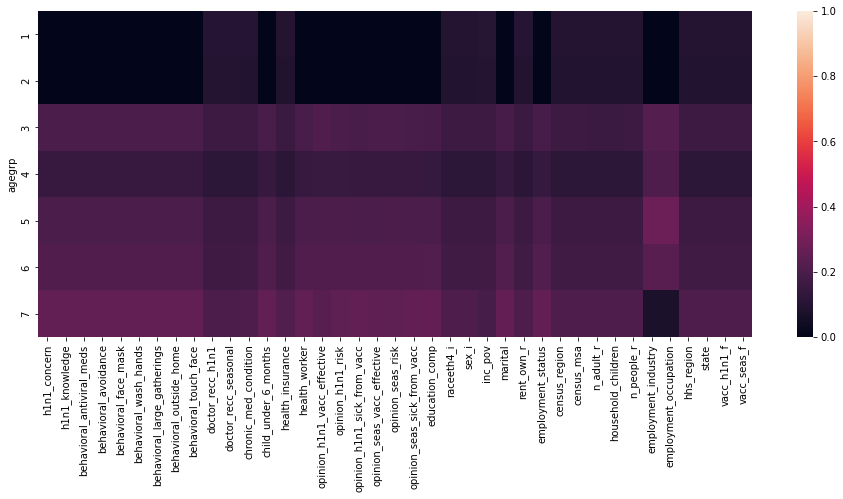

In [ ]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)


In [ ]:
#1,2,7그룹으로 결측치 채우기
df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
df['marital']=df.apply(lambda x: False if x['agegrp'] in (1,2) else x['marital'],axis=1)
df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] == 7 else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)


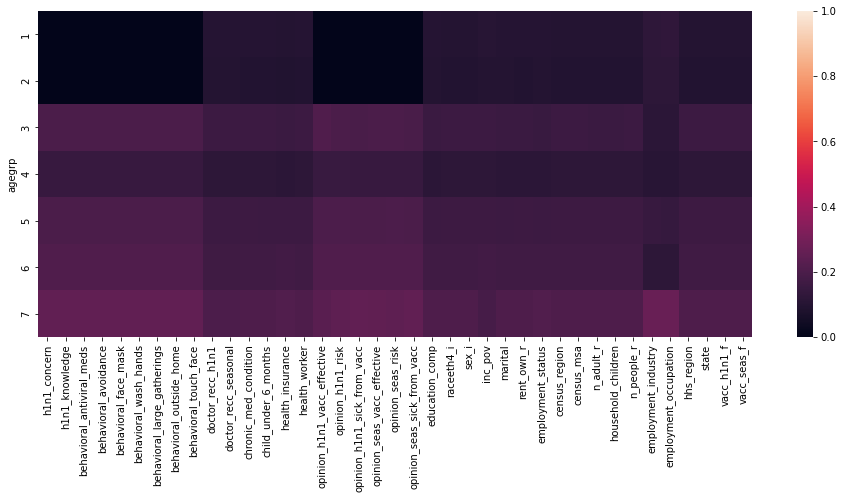

In [ ]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)

<AxesSubplot:>

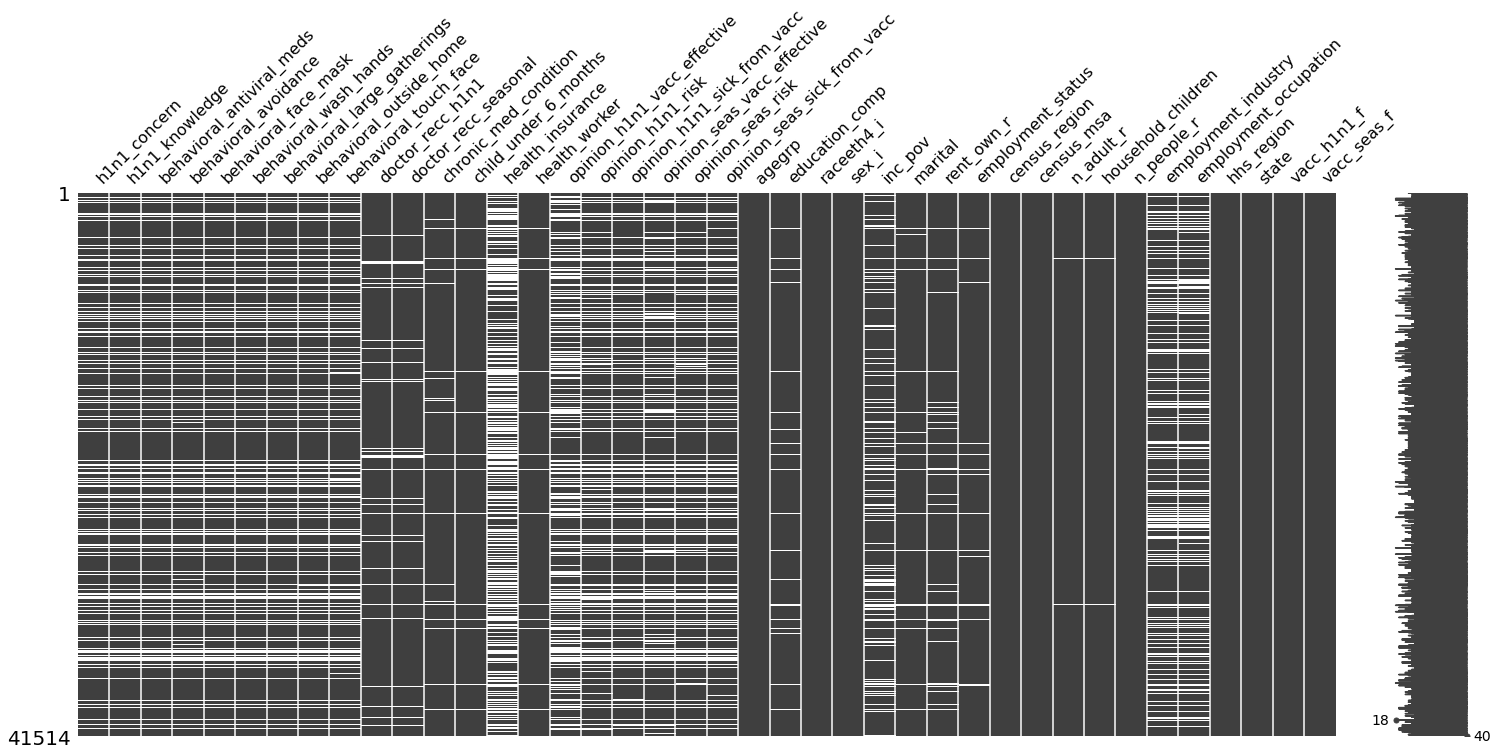

In [ ]:
msno.matrix(df)

In [ ]:
# n_people_r = n_adult_r + household_children
for i in range(len(df)):
    pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
    if np.isnan(pList).sum()==1:
        if np.isnan(pList[0]):
            df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
        elif np.isnan(pList[1]):
            df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
        else:
            df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
            

MCAR

In [ ]:
# feature - MV_dummy_feature chi2 test
# H0 : they are independent.
# Ha : they are not independent.
# p<0.05 : dismiss H0 and select Ha.
# p>0.05 : don't know.
# p<0.05 for at least 1 featrue : It is related to some features so it is not MCAR.
# p>0.05 for all features : It can be MCAR. more analysis needed. store at suspect.
suspect=[]
for i in df_MV.columns:
    molu=True
    if df_MV[i].sum()==0:
        print(f'there is no MV in {i}')
        continue
    for j in df.columns:
        obs=pd.crosstab(df_MV[i],df[j])
        p=scipy.stats.chi2_contingency(obs)[1]
        if p<0.05 :
            print(f'{i} is not MCAR')
            molu=False
            break
    if molu:
        print(f'{i} can be MCAR')
        suspect.append(i)


h1n1_concern_mv is not MCAR
h1n1_knowledge_mv is not MCAR
behavioral_antiviral_meds_mv is not MCAR
behavioral_avoidance_mv is not MCAR
behavioral_face_mask_mv is not MCAR
behavioral_wash_hands_mv is not MCAR
behavioral_large_gatherings_mv is not MCAR
behavioral_outside_home_mv is not MCAR
behavioral_touch_face_mv is not MCAR
doctor_recc_h1n1_mv is not MCAR
doctor_recc_seasonal_mv is not MCAR
chronic_med_condition_mv is not MCAR
child_under_6_months_mv is not MCAR
health_insurance_mv is not MCAR
health_worker_mv is not MCAR
opinion_h1n1_vacc_effective_mv is not MCAR
opinion_h1n1_risk_mv is not MCAR
opinion_h1n1_sick_from_vacc_mv is not MCAR
opinion_seas_vacc_effective_mv is not MCAR
opinion_seas_risk_mv is not MCAR
opinion_seas_sick_from_vacc_mv is not MCAR
there is no MV in agegrp_mv
education_comp_mv is not MCAR
there is no MV in raceeth4_i_mv
there is no MV in sex_i_mv
inc_pov_mv is not MCAR
marital_mv is not MCAR
rent_own_r_mv is not MCAR
employment_status_mv is not MCAR
there is no

In [ ]:
print(suspect)

[]


##### Test of Independence

In [ ]:
# nominal-nominal : chi2 and fisher
# bool-ordinal : Mann Whitney U test groupby bool
# nominal-ordinal : Kruskal–Wallis groupby nominal
# ordinal-ordinal : Mann Whitney U test

for i in itertools.combinations(df.columns,2):
    if not set(i)-set(('nominal','bool')):
        obs=pd.crosstab(df[i[0]],df[i[1]])
        obsl=list(itertools.chain.from_iterable(np.array(obs)))
        l=len(obsl)
        a=len(list(itertools.filterfalse(lambda x: x<5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2)))))
        if a<l/5: # fisher
            if l==4:
                p=scipy.stats.fisher_exact(obs)
                if p<0.05:
                    print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
        else: # chi2
            p=scipy.stats.chi2_contingency(obs,correction=False)[1]
            if p<0.05:
                print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')

    elif not set(i)-set(('ordinal','interval')): # 
        p=scipy.stats.mannwhitneyu(i[0],i[1])
        if p[1]<0.05:
            print(i[0],i[1],p)
    elif set(i)==set(('bool','interval')) or set(i)==set(('bool','ordinal')):
        if i[0]=='bool':
            a=df[df[i[0]]==1]
            b=df[df[i[0]]==0]
        else:
            a=df[df[i[1]]==1]
            b=df[df[i[1]]==0]
        p=scipy.stats.mannwhitneyu(a,b)
        if p[1]<0.05:
            print(i[0],i[1],p)
    else:
        catlist=[]
        if i[0]=='nominal':
            for cat in df[i[0]].unique():
                catlist.append(df[df[i[0]]==cat][i[1]])
        else:
            for cat in df[i[1]].unique():
                catlist.append(df[df[i[1]]==cat][i[0]])
        p=scipy.stats.kruskal(*catlist)
        if p[1]<0.05:
            print(i[0],i[1],p)

agegrp raceeth4_i KruskalResult(statistic=1712.5512905965722, pvalue=0.0)
agegrp sex_i KruskalResult(statistic=375.20895373700347, pvalue=1.3742461197643081e-83)
agegrp census_region KruskalResult(statistic=26.165995728675643, pvalue=8.803823338120655e-06)
agegrp census_msa KruskalResult(statistic=118.9279330082987, pvalue=1.496674899268618e-26)
agegrp hhs_region KruskalResult(statistic=29.11160896836757, pvalue=0.0006205382585624457)
agegrp state KruskalResult(statistic=237.82384623790026, pvalue=2.928803581924807e-26)
agegrp vacc_h1n1_f KruskalResult(statistic=205.4041017667274, pvalue=1.3823318715982148e-46)
agegrp vacc_seas_f KruskalResult(statistic=1604.978142934509, pvalue=0.0)
raceeth4_i sex_i KruskalResult(statistic=16.315295695615948, pvalue=5.3629317094093134e-05)
raceeth4_i census_region KruskalResult(statistic=867.1773909165554, pvalue=1.164973729494628e-187)
raceeth4_i census_msa KruskalResult(statistic=903.3405873388914, pvalue=6.951584716735408e-197)
raceeth4_i hhs_regio

##### Correlation

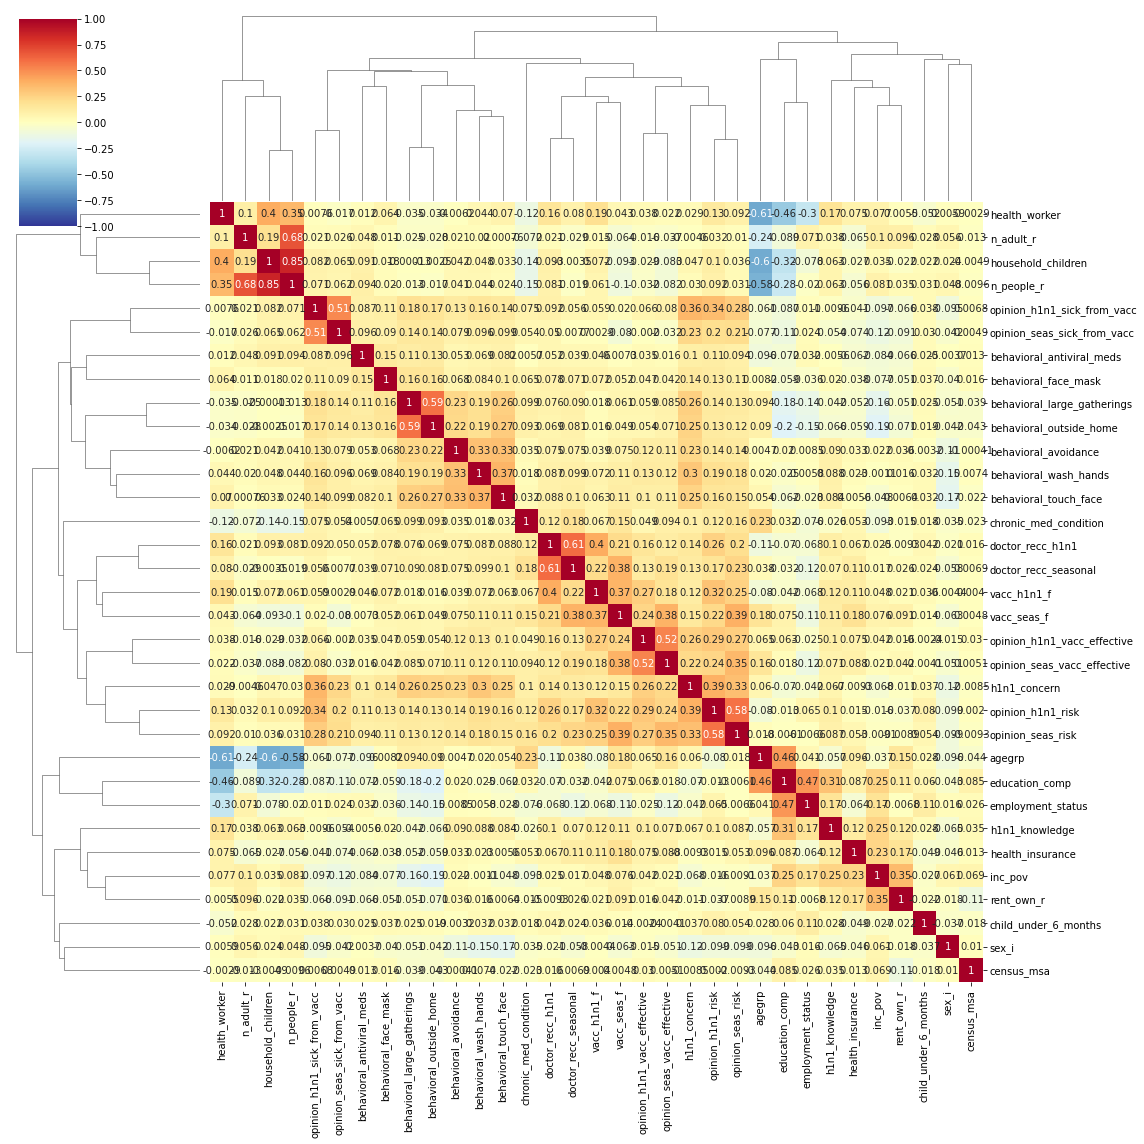

In [ ]:
corr = df.corr(method='pearson')
sns.clustermap(corr, 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            figsize=(16,16)
            )

Note : household_children, n_people_r are correlated but

In [ ]:
# n_adult_r + household_children = n_people_r
for i in range(len(df)):
    if np.isnan(df['n_adult_r'][i]) or np.isnan(df['household_children'][i]) or np.isnan(df['n_people_r'][i]):
        continue
    if df['n_adult_r'][i]+df['household_children'][i]!=df['n_people_r'][i]:
        print(f"{df['n_adult_r'][i]},{df['household_children'][i]},{df['n_people_r'][i]}")

##### Clustering

In [ ]:
!pip install kpod

In [ ]:
# one-hot encoder
def encoder(df):
    encode_needed = [x for x in type_feature if type_feature[x]=='nominal']
    encoded = pd.get_dummies(df,columns=encode_needed)
    col_list = encoded.columns.tolist()
    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(',','_')
        col_list[i] = col_list[i].replace(' ','_')
    encoded.columns = col_list
    return encoded

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# X shoudl be a numpy matrix, very likely sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix
# T1 > T2 for overlapping clusters
# T1 = Distance to centroid point to not include in other clusters
# T2 = Distance to centroid point to include in cluster
# T1 > T2 for overlapping clusters
# T1 < T2 will have points which reside in no clusters
# T1 == T2 will cause all points to reside in mutually exclusive clusters
# Distance metric can be any from here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html
# filemap may be a list of point names in their order in X. If included, row numbers from X will be replaced with names from filemap. 
 
def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

In [ ]:
cnp=canopy(encoder(df[train.columns].dropna()),8,5)
print(len(cnp))
print(cnp)

6
{0: {'c': 0, 'points': [0, 88, 100, 104, 113, 123, 262, 284, 305, 325, 373, 494, 526, 588, 756, 783, 807, 824, 861, 864, 939, 966, 1106, 1144, 1203, 1215, 1240, 1270, 1332, 1333, 1335, 1370, 1407, 1414, 1444, 1476, 1493, 1558, 1571, 1586, 1600, 1855, 1917, 1979, 2021, 2053, 2071, 2104, 2116, 2137, 2138, 2167, 2254, 2293, 2351, 2352, 2395, 2459, 2590, 2595, 2616, 2769, 2785, 2805, 2902, 2906, 2935, 2941, 3013, 3019, 3024, 3065, 3088, 3090, 3117, 3149, 3164, 3230, 3266, 3319, 3325, 3329, 3376, 3402, 3435, 3438, 3456, 3470, 3491, 3502, 3507, 3518, 3669, 3714, 3769, 3774, 3916, 3935, 3945, 3946, 4038, 4077, 4097, 4220, 4273, 4318, 4321, 4367, 4375, 4382, 4441, 4475, 4512, 4588, 4604, 4610, 4622, 4625, 4635, 4687, 4694, 4786, 4802, 4831, 4850, 4881, 4911, 4921, 4932, 4934, 4972, 4982, 4985, 5030, 5050, 5137, 5193, 5209, 5222, 5223, 5343, 5365, 5391, 5407, 5429, 5470, 5605, 5641, 5656, 5684, 5711, 5724, 5765, 5785, 5791, 5870, 5915, 5999, 6008, 6032, 6056, 6074, 6083, 6085, 6130, 6156, 616

In [ ]:
# import the k_pod method
from kPOD import k_pod

# set the number of clusters desired (in this example, 3)
K = 6

# use previously existing data to perform clustering
clustering_results = k_pod(encoder(df[train.columns]), K)

# k_pod outputs a tuple with the cluster assignments and centers
print(clustering_results)


# save the cluster assignments and centers
cluster_assignments = clustering_results[0]
cluster_centers = clustering_results[1]

(array([1., 0., 3., ..., 4., 4., 1.]), [array([1.5435099376347847, 1.2172874045579063, 0.026569247894074714,
       0.7115467986836905, 0.05734216493929773, 0.8079720237867432,
       0.36618903684585447, 0.34560015515788767, 0.6709139211079737,
       0.18694309896476685, 0.35015734497291323, 0.33228870370271835,
       0.05916101024446269, 0.7910111161045174, 0.07992941473486224,
       2.039475179462248, 1.783387365127277, 0.8715138653064807,
       2.246060644245264, 2.1315245049883877, 0.7114017582026577,
       6.230051873870723, 2.9423267638109047, 0.3964562569213732,
       2.0889623398653288, 0.4887681160800016, 0.8213300516284516,
       0.7821026010455993, 0.9812904353908026, 1.6105640259265002,
       0.03285533868542155, 1.643874111394324, 0.02681121408171592,
       0.06836859590837559, 0.041848808066678324, 0.8629713819432302,
       0.23150900507081656, 0.16168327796234774, 0.35163490120650465,
       0.2551728157603311, 0.007052515008451361, 0.007868508480503585,
     

In [ ]:
(len(df), len(clustering_results[0]))

(41514, 41514)

In [ ]:
# Cluster sampling
split_index = pd.DataFrame(clustering_results[0],columns=['cluster']).reset_index()
train_index = []
test_index = []
validate_index = []
for i in split_index.cluster.unique():
    X_temp,X_test,y_temp,y_test = train_test_split(split_index[split_index.cluster==i],split_index[split_index.cluster==i],test_size=0.2,random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.2,random_state=42)
    train_index.extend(X_train.index.tolist())
    test_index.extend(X_test.index.tolist())
    validate_index.extend(X_val.index.tolist())
len(train_index), len(test_index), len(validate_index)

(26565, 8305, 6644)

In [ ]:
a=[123]
b=[456]
a.extend(b)
a

[123, 456]

##### Factor analysis

In [ ]:
# skip

##### Functionization

In [ ]:
def EDA(df):
    df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',0,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',1,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Very Effective',3,inplace=True)
    df['opinion_h1n1_risk'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
    df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
    df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
    df['opinion_h1n1_risk'].replace('Somewhat High',3,inplace=True)
    df['opinion_h1n1_risk'].replace('Very High',4,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',3,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Not At All Effective',0,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Not Very Effective',1,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Very Effective',3,inplace=True)
    df['opinion_seas_risk'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
    df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
    df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
    df['opinion_seas_risk'].replace('Somewhat High',3,inplace=True)
    df['opinion_seas_risk'].replace('Very High',4,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Very Worried',3,inplace=True)
    df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
    df['agegrp'].replace('10 - 17 Years',2,inplace=True)
    df['agegrp'].replace('18 - 34 Years',3,inplace=True)
    df['agegrp'].replace('35 - 44 Years',4,inplace=True)
    df['agegrp'].replace('45 - 54 Years',5,inplace=True)
    df['agegrp'].replace('55 - 64 Years',6,inplace=True)
    df['agegrp'].replace('65+ Years',7,inplace=True)
    df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
    df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
    df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
    df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
    df['sex_i'].replace(2,0,inplace=True)
    df['inc_pov'].replace(4,np.nan,inplace=True)
    df['inc_pov'].replace(3,5,inplace=True)
    df['inc_pov'].replace(1,3,inplace=True)
    df['inc_pov'].replace(5,1,inplace=True)
    df['marital'].replace(2,0,inplace=True)
    df['rent_own_r'].replace(77,np.nan,inplace=True)
    df['rent_own_r'].replace(99,np.nan,inplace=True)
    df['rent_own_r'].replace(2,0,inplace=True)
    df['employment_status'].replace('Unemployed',0,inplace=True)
    df['employment_status'].replace('Not in Labor Force',1,inplace=True)
    df['employment_status'].replace('Employed',2,inplace=True)
    df['census_region'].replace(1,'northeast',inplace=True)
    df['census_region'].replace(2,'midwest',inplace=True)
    df['census_region'].replace(3,'south',inplace=True)
    df['census_region'].replace(4,'west',inplace=True)
    df['census_msa'].replace('Non-MSA',0,inplace=True)
    df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
    df['census_msa'].replace('MSA, Principle City',2,inplace=True)
    df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
    df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
    df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
    df['state'].replace('ALABAMA','AL',inplace=True)
    df['state'].replace('ALASKA','AK',inplace=True)
    df['state'].replace('ARIZONA','AZ',inplace=True)
    df['state'].replace('ARKANSAS','AR',inplace=True)
    df['state'].replace('CALIFORNIA','CA',inplace=True)
    df['state'].replace('COLORADO','CO',inplace=True)
    df['state'].replace('CONNECTICUT','CT',inplace=True)
    df['state'].replace('DELAWARE','DE',inplace=True)
    df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
    df['state'].replace('FLORIDA','FL',inplace=True)
    df['state'].replace('GEORGIA','GA',inplace=True)
    df['state'].replace('HAWAII','HI',inplace=True)
    df['state'].replace('IDAHO','ID',inplace=True)
    df['state'].replace('ILLINOIS','IL',inplace=True)
    df['state'].replace('INDIANA','IN',inplace=True)
    df['state'].replace('IOWA','IA',inplace=True)
    df['state'].replace('KANSAS','KS',inplace=True)
    df['state'].replace('KENTUCKY','KY',inplace=True)
    df['state'].replace('LOUISIANA','LA',inplace=True)
    df['state'].replace('MAINE','ME',inplace=True)
    df['state'].replace('MARYLAND','MD',inplace=True)
    df['state'].replace('MASSACHUSETTS','MA',inplace=True)
    df['state'].replace('MICHIGAN','MI',inplace=True)
    df['state'].replace('MINNESOTA','MN',inplace=True)
    df['state'].replace('MISSISSIPPI','MS',inplace=True)
    df['state'].replace('MISSOURI','MO',inplace=True)
    df['state'].replace('MONTANA','MT',inplace=True)
    df['state'].replace('NEBRASKA','NE',inplace=True)
    df['state'].replace('NEVADA','NV',inplace=True)
    df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
    df['state'].replace('NEW JERSEY','NJ',inplace=True)
    df['state'].replace('NEW MEXICO','NM',inplace=True)
    df['state'].replace('NEW YORK','NY',inplace=True)
    df['state'].replace('NORTH CAROLINA','NC',inplace=True)
    df['state'].replace('NORTH DAKOTA','ND',inplace=True)
    df['state'].replace('OHIO','OH',inplace=True)
    df['state'].replace('OKLAHOMA','OK',inplace=True)
    df['state'].replace('OREGON','OR',inplace=True)
    df['state'].replace('PENNSYLVANIA','PA',inplace=True)
    df['state'].replace('RHODE ISLAND','RI',inplace=True)
    df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
    df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
    df['state'].replace('TENNESSEE','TN',inplace=True)
    df['state'].replace('TEXAS','TX',inplace=True)
    df['state'].replace('UTAH','UT',inplace=True)
    df['state'].replace('VERMONT','VT',inplace=True)
    df['state'].replace('VIRGINIA','VA',inplace=True)
    df['state'].replace('WASHINGTON','WA',inplace=True)
    df['state'].replace('WEST VIRGINIA','WV',inplace=True)
    df['state'].replace('WISCONSIN','WI',inplace=True)
    df['state'].replace('WYOMING','WY',inplace=True)
    df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
    df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
    df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
    df['marital']=df.apply(lambda x: False if x['agegrp'] in (1,2) else x['marital'],axis=1)
    df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
    df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] == 7 else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)
    for i in range(len(df)):
        pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
        if np.isnan(pList).sum()==1:
            if np.isnan(pList[0]):
                df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
            elif np.isnan(pList[1]):
                df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
            else:
                df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
    return df

In [ ]:
train=EDA(train)
test=EDA(test)

C:\Users\gram\AppData\Local\Temp\ipykernel_19300\1537547572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
C:\Users\gram\AppData\Local\Temp\ipykernel_19300\1537547572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
C:\Users\gram\AppData\Local\Temp\ipykernel_19300\1537547572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

## Data Preprocessing

### Type casting

In [ ]:
def type_casting(df,type_feature):
    for column in df.columns:
        if type_feature[column]=='bool':
            df[column]=df[column].astype('bool')
        elif type_feature[column]=='nominal':
            df[column]=df[column].astype('category')
        elif type_feature[column]=='ordinal':
            df[column]=df[column].astype(pd.CategoricalDtype(ordered=True))
        elif type_feature[column]=='interval':
            df[column]=df[column].astype('float')
    return df
df = type_casting(df,type_feature)
train = type_casting(train,type_feature)
target = type_casting(target,type_feature)
test = type_casting(test,type_feature)

C:\Users\gram\AppData\Local\Temp\ipykernel_19300\2957975196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column]=df[column].astype(pd.CategoricalDtype(ordered=True))
C:\Users\gram\AppData\Local\Temp\ipykernel_19300\2957975196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column]=df[column].astype(pd.CategoricalDtype(ordered=True))
C:\Users\gram\AppData\Local\Temp\ipykernel_19300\2957975196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

### Encoding

In [ ]:
train_encoded=encoder(train)
df_encoded = encoder(df)

### Feature Engineering 1

#### Feature Selection

##### filter method(information value)

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        
        if round(d['IV'].sum(),6)>0.5:
          print('***********************************found************************')

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
iv, woe = iv_woe(data = encoder(df.drop('vacc_seas_f',axis=1)), target = 'vacc_h1n1_f', bins=10, show_woe = True)

Information value of h1n1_concern is 0.084292
       Variable Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_concern    0.0   4209     590     0.082935        3619   
1  h1n1_concern    1.0  10293    1762     0.247681        8531   
2  h1n1_concern    2.0  13441    3083     0.433371       10358   
3  h1n1_concern    3.0   5791    1679     0.236013        4112   

   % of Non-Events       WoE        IV  
0         0.135950 -0.494232  0.026202  
1         0.320473 -0.257659  0.018756  
2         0.389106  0.107742  0.004769  
3         0.154470  0.423887  0.034565  
Information value of h1n1_knowledge is 0.09459
         Variable Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_knowledge    0.0   3222     431     0.060585        2791   
1  h1n1_knowledge    1.0  18510    3352     0.471184       15158   
2  h1n1_knowledge    2.0  12002    3331     0.468232        8671   

   % of Non-Events       WoE        IV  
0         0.104846 -0.548449  0.024275  
1         0.5694

In [ ]:
iv[iv['IV']>0.5]

Variable        IV
0             doctor_recc_h1n1  0.579987
0  opinion_h1n1_vacc_effective  0.529175
0            opinion_h1n1_risk  0.627467

##### wrapper method

- Feature Importance

In [ ]:
X_train = train_encoded.iloc[train_index]
y_train = target['vacc_h1n1_f'].iloc[train_index]
X_test = train_encoded.iloc[test_index]
y_test = target['vacc_h1n1_f'].iloc[test_index]
X_val = train_encoded.iloc[validate_index]
y_val = target['vacc_h1n1_f'].iloc[validate_index]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((26565, 149), (26565,), (6644, 149), (6644,), (8305, 149), (8305,))

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [ ]:
def lgb_f1_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba =  list(map(round,lgb_model.predict_proba(X_val)[:,1]))
    f1 = f1_score(y_val, valid_proba)
    
    return f1   

In [ ]:
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [ ]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();

In [ ]:
# 가장 큰 target값을 가지는 parameter 추출. 
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]

In [ ]:
max_target_param['params']

{'colsample_bytree': 0.9020148450351968,
 'max_bin': 51.93024321755463,
 'max_depth': 7.314945683338724,
 'min_child_samples': 94.41049145025308,
 'min_child_weight': 2.1627105884688675,
 'num_leaves': 53.91625299517254,
 'reg_alpha': 15.630915789830222,
 'reg_lambda': 8.314547356284493,
 'subsample': 0.8446524068213128}

In [ ]:
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    subsample=round(max_target_param['params']['subsample'],3),
    max_depth=int(max_target_param['params']['max_depth']),
    colsample_bytree=round(max_target_param['params']['colsample_bytree'],3),
    max_bin=int(max_target_param['params']['max_bin']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[1]	training's binary_logloss: 0.545939	valid_1's binary_logloss: 0.542602
[2]	training's binary_logloss: 0.541554	valid_1's binary_logloss: 0.538596
[3]	training's binary_logloss: 0.537318	valid_1's binary_logloss: 0.534748
[4]	training's binary_logloss: 0.53371	valid_1's binary_logloss: 0.531551
[5]	training's binary_logloss: 0.530133	valid_1's binary_logloss: 0.528312
[6]	training's binary_logloss: 0.527037	valid_1's binary_logloss: 0.525566
[7]	training's binary_logloss: 0.524068	valid_1's binary_logloss: 0.522927
[8]	training's binary_logloss: 0.521186	valid_1's binary_logloss: 0.5204
[9]	training's binary_logloss: 0.518585	valid_1's binary_logloss: 0.518111
[10]	training's binary_logloss: 0.516235	valid_1's binary_logloss: 0.51607
[11]	training's binary_logloss: 0.513963	valid_1's binary_logloss: 0.514109
[12]	training's binary_logloss: 0.51188	valid_1's binary_logloss: 0.5123
[13]	training's binary_logloss: 0.509951	valid_1's binary_logloss: 0.510663
[14]	training's binary_loglo

LGBMClassifier(colsample_bytree=0.902, learning_rate=0.02, max_bin=51,
               max_depth=7, min_child_samples=95, min_child_weight=3,
               n_estimators=1000, num_leaves=54, reg_alpha=15.631,
               reg_lambda=8.315, scale_pos_weight=3.168366546367488, silent=-1,
               subsample=0.845, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

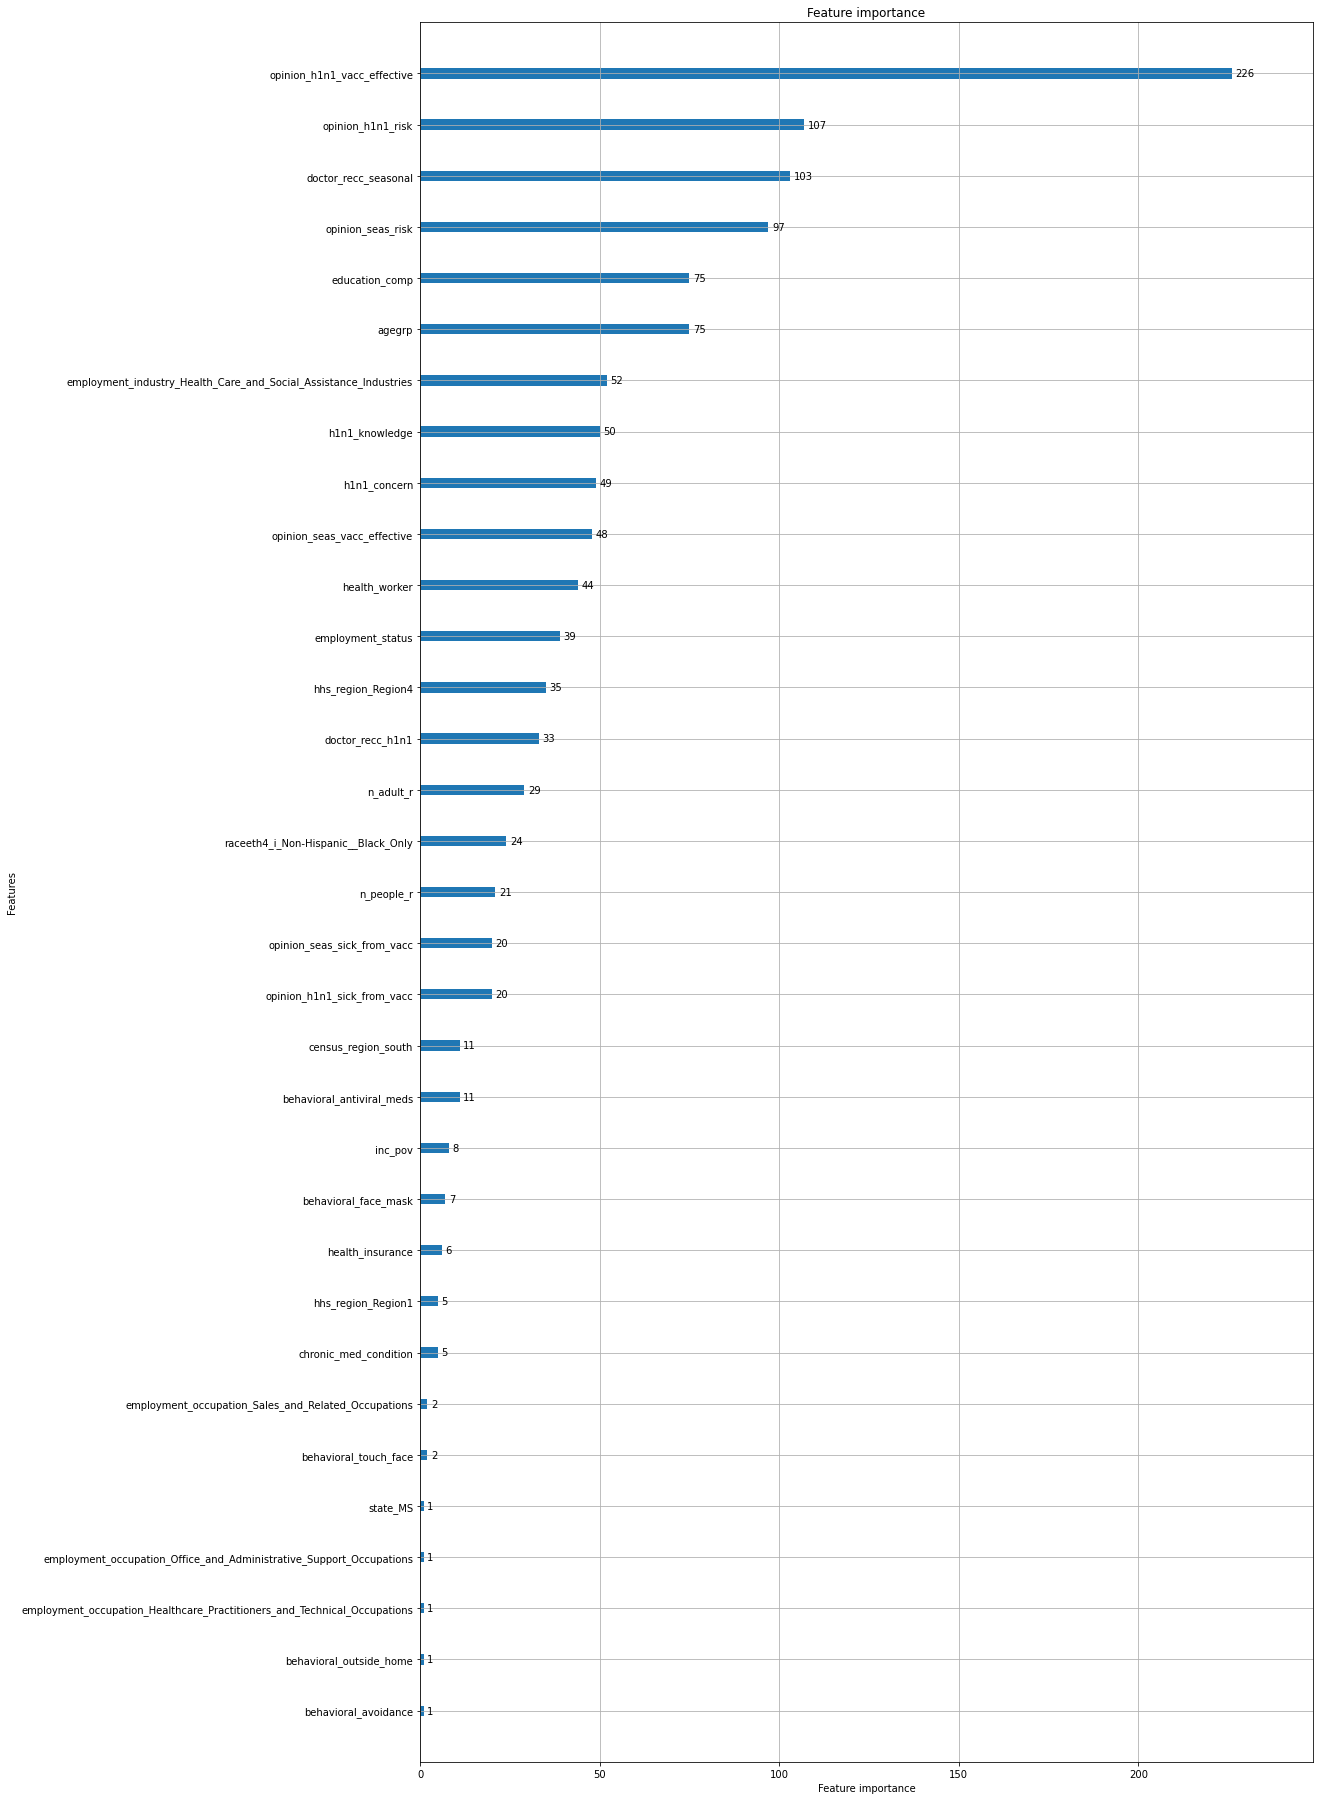

In [ ]:
plot_importance(clf,figsize=(16,32))

In [ ]:
f_i = pd.DataFrame(np.column_stack((list(map(lambda x:x/sum(clf.feature_importances_),clf.feature_importances_)),X_train.columns)),columns=['f_i','col']).sort_values(by='f_i',ascending=False).reset_index(drop=True)

In [ ]:
f_i=f_i['col'].head(6).tolist()

In [ ]:
f_i

['opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'doctor_recc_seasonal',
 'opinion_seas_risk',
 'education_comp',
 'agegrp']

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

accuracy : 0.8108368452739314
precision : 0.6219336219336219
recall : 0.45154531168150863
f1 : 0.5232169954476479


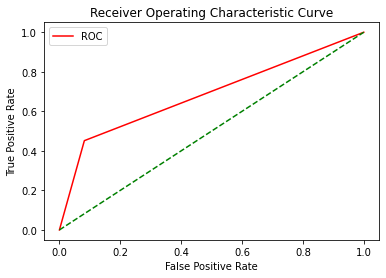

In [ ]:
a=accuracy_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'accuracy : {a}')
p = precision_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'precision : {p}')
r = recall_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'recall : {r}')
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'f1 : {f1}')
fper, tper, thresholds = roc_curve(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
plot_roc_curve(fper, tper)


In [ ]:
pred = clf.predict_proba(encoder(test))
first_pred=pd.DataFrame(map(round,pred[:,1]),columns=['vacc_h1n1_f'])
first_pred.index.name='Id'
first_pred.to_csv('first_pred.csv')

kaggle score is 0.49657, it is heavily overfitted

- Akaike Information Criterion

In [ ]:
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
def all_aic(df):
    aic=[]
    for column in df.columns:
        if column not in ['vacc_h1n1_f','vacc_seas_f']:
            df_temp = df[[column,'vacc_h1n1_f']].dropna()
            x=df_temp[column]
            y=df_temp['vacc_h1n1_f']
            model = Logit(np.array(y),np.array(sm.add_constant(x),dtype=float)).fit(method='bfgs')
            aic.append([column,model.aic,model.bic])
    return pd.DataFrame(aic,columns=['col','aic','bic'])

In [ ]:
aic = all_aic(df_encoded)
clear_output()

<AxesSubplot:>

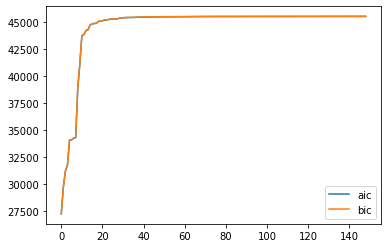

In [ ]:
aic.sort_values(by=['aic']).reset_index(drop=True)[['aic','bic']].plot()

In [ ]:
aic = aic[aic['aic']<35000].col.tolist()

In [ ]:
def aic_sec(df):
    cols=['doctor_recc_h1n1','opinion_h1n1_vacc_effective','opinion_h1n1_risk']
    cols2=[]
    x=df[cols]
    y=df['vacc_h1n1_f']
    model = Logit(np.array(y),np.array(sm.add_constant(x),dtype=float)).fit(method='bfgs')
    aic=model.bic
    for column in df.columns.tolist():
        if column not in ['vacc_h1n1_f','vacc_seas_f']+cols:
            x=df[cols+[column]]
            y=df['vacc_h1n1_f']
            model = Logit(np.array(y),np.array(sm.add_constant(x),dtype=float)).fit(method='bfgs')
            if aic>model.bic:
                cols2.append(column)
    return cols2+cols
    

In [ ]:
aic_cols=aic_sec(df_encoded.dropna())
clear_output()

In [ ]:
print(aic_cols)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_avoidance', 'behavioral_large_gatherings', 'behavioral_outside_home', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_insurance', 'health_worker', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp', 'education_comp', 'inc_pov', 'marital', 'rent_own_r', 'raceeth4_i_Hispanic', 'raceeth4_i_Non-Hispanic__Black_Only', 'raceeth4_i_Non-Hispanic__White_Only', 'census_region_south', 'employment_industry_Accommodation_and_Food_Services_Industries', 'employment_industry_Administrative_and_Support_and_Waste_Management', 'employment_industry_Armed_Forces', 'employment_industry_Construction_Industries', 'employment_industry_Finance_and_Insurance_Industries', 'employment_industry_Health_Care_and_Social_Assistance_Industries', 'employment_industry_Information_Industries', 'employment_industry_Other_Services_(except_Public)', 'employment_industry_Public

In [ ]:
selected=list((set(aic)|set(f_i))|set(aic_cols))

##### Result of Feature Selection

In [ ]:
X_train = train_encoded[selected].iloc[train_index]
y_train = target['vacc_h1n1_f'].iloc[train_index]
X_test = train_encoded[selected].iloc[test_index]
y_test = target['vacc_h1n1_f'].iloc[test_index]
X_val = train_encoded[selected].iloc[validate_index]
y_val = target['vacc_h1n1_f'].iloc[validate_index]
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]

In [ ]:
print(max_target_param)

{'target': 0.5317198386505317, 'params': {'colsample_bytree': 0.8493082489945825, 'max_bin': 60.235647296656765, 'max_depth': 14.142905952469782, 'min_child_samples': 86.64229491517457, 'min_child_weight': 4.556258163931574, 'num_leaves': 40.59432754318935, 'reg_alpha': 1.5637508555602182, 'reg_lambda': 5.760379490617139, 'subsample': 0.782670064683513}}


In [ ]:

clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    subsample=round(max_target_param['params']['subsample'],3),
    max_depth=int(max_target_param['params']['max_depth']),
    colsample_bytree=round(max_target_param['params']['colsample_bytree'],3),
    max_bin=int(max_target_param['params']['max_bin']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[1]	training's binary_logloss: 0.547663	valid_1's binary_logloss: 0.544279
[2]	training's binary_logloss: 0.542685	valid_1's binary_logloss: 0.539729
[3]	training's binary_logloss: 0.538496	valid_1's binary_logloss: 0.536015
[4]	training's binary_logloss: 0.534225	valid_1's binary_logloss: 0.532196
[5]	training's binary_logloss: 0.530295	valid_1's binary_logloss: 0.528695
[6]	training's binary_logloss: 0.526716	valid_1's binary_logloss: 0.525455
[7]	training's binary_logloss: 0.523642	valid_1's binary_logloss: 0.522717
[8]	training's binary_logloss: 0.520561	valid_1's binary_logloss: 0.519974
[9]	training's binary_logloss: 0.517748	valid_1's binary_logloss: 0.517479
[10]	training's binary_logloss: 0.515093	valid_1's binary_logloss: 0.51515
[11]	training's binary_logloss: 0.51266	valid_1's binary_logloss: 0.513045
[12]	training's binary_logloss: 0.51139	valid_1's binary_logloss: 0.512043
[13]	training's binary_logloss: 0.509238	valid_1's binary_logloss: 0.510203
[14]	training's binary_l

LGBMClassifier(colsample_bytree=0.849, learning_rate=0.02, max_bin=60,
               max_depth=14, min_child_samples=87, min_child_weight=5,
               n_estimators=1000, num_leaves=41, reg_alpha=1.564,
               reg_lambda=5.76, scale_pos_weight=3.168366546367488, silent=-1,
               subsample=0.783, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

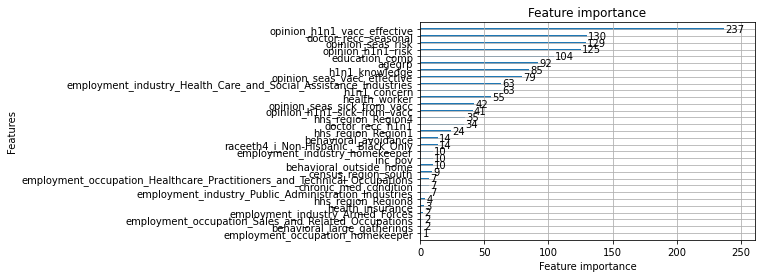

In [ ]:
plot_importance(clf)

accuracy : 0.8157736303431667
precision : 0.6465583913379737
recall : 0.43792561550550024
f1 : 0.5221736414740786


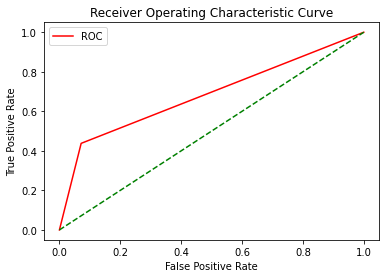

In [ ]:
a=accuracy_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'accuracy : {a}')
p = precision_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'precision : {p}')
r = recall_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'recall : {r}')
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'f1 : {f1}')
fper, tper, thresholds = roc_curve(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
plot_roc_curve(fper, tper)


### PMM imputation

### Multiple imputation

In [ ]:
strategy={}
for column in train_encoded[selected].columns:
    if len(train_encoded[column].dropna().unique())==2:
        strategy[column]='bayesian binary logistic'
    else:
        strategy[column]='pmm'
strategy

{'employment_industry_Transportation_and_Warehousing_Industries': 'bayesian binary logistic',
 'employment_industry_Accommodation_and_Food_Services_Industries': 'bayesian binary logistic',
 'employment_industry_Construction_Industries': 'bayesian binary logistic',
 'behavioral_outside_home': 'bayesian binary logistic',
 'raceeth4_i_Non-Hispanic__Black_Only': 'bayesian binary logistic',
 'behavioral_large_gatherings': 'bayesian binary logistic',
 'h1n1_concern': 'pmm',
 'employment_industry_Retail_Trade_Industries': 'bayesian binary logistic',
 'opinion_h1n1_risk': 'pmm',
 'raceeth4_i_Non-Hispanic__White_Only': 'bayesian binary logistic',
 'employment_industry_Information_Industries': 'bayesian binary logistic',
 'health_insurance': 'bayesian binary logistic',
 'employment_industry_Public_Administration_Industries': 'bayesian binary logistic',
 'rent_own_r': 'bayesian binary logistic',
 'employment_occupation_Transportation_and_Material_Moving_Occupations': 'bayesian binary logistic',
 

In [ ]:

imp = MiceImputer(
    k=3,
    n=5,
    strategy=strategy, 
    imp_kwgs={"pmm": {"fill_value": "random",'neighbors':6}}, 
    predictors={"salary": "all", "gender": ["salary", "education", "weight"]},
    visit="left-to-right", 
    return_list=True,
    seed=random_seed
    )
df_imputed=imp.fit_transform(train_encoded[selected].astype(float))

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains

### Scaling

In [ ]:

scaler = StandardScaler()
scaler.fit(df_imputed)
df_scaled = scaler.transform(df_imputed)

## Modeling and Evaluation

In [ ]:
X_train = df_scaled[selected].iloc[train_index]
y_train = target['vacc_h1n1_f'].iloc[train_index]
X_test = df_scaled[selected].iloc[test_index]
y_test = target['vacc_h1n1_f'].iloc[test_index]
X_val = df_scaled[selected].iloc[validate_index]
y_val = target['vacc_h1n1_f'].iloc[validate_index]
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]

In [ ]:
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    subsample=round(max_target_param['params']['subsample'],3),
    max_depth=int(max_target_param['params']['max_depth']),
    colsample_bytree=round(max_target_param['params']['colsample_bytree'],3),
    max_bin=int(max_target_param['params']['max_bin']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)

### Evaluation 1

In [ ]:
plot_importance(clf)

In [ ]:
a=accuracy_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'accuracy : {a}')
p = precision_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'precision : {p}')
r = recall_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'recall : {r}')
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'f1 : {f1}')
fper, tper, thresholds = roc_curve(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
plot_roc_curve(fper, tper)

### Feature engineering 2

### Evaluation 2

### XGBOOST

## Conclusion